# Deep cortical machine learning: Policy gradients + Q-learning + GAN


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('MountainCarContinuous-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
batch = []
for _ in range(1111):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

In [4]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [5]:
batch[0], 
batch[0][1].shape, state.shape

((4,), (4,))

In [6]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
# print(rewards[-20:])
print('shapes:', np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print('dtypes:', np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('states:', np.max(np.array(states)), np.min(np.array(states)))
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

shapes: (1111,) (1111, 4) (1111,) (1111,)
dtypes: float64 float64 int64 bool
states: 2.5757600231305036 -3.075645411924883
actions: 1 0
rewards: 1.0 1.0


In [8]:
actions[:10]

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [9]:
rewards[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [10]:
# import numpy as np
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))

In [11]:
sigmoid(np.max(np.array(rewards))), sigmoid(np.min(np.array(rewards)))

(0.7310585786300049, 0.7310585786300049)

In [12]:
print('rewards:', np.max(np.array(rewards))/100, np.min(np.array(rewards))/100)

rewards: 0.01 0.01


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [13]:
# Data of the model
def model_input(state_size):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    reward = tf.placeholder(tf.float32, [], name='reward')
    return states, actions, targetQs, reward

In [14]:
# How to use batch-norm
#   x_norm = tf.layers.batch_normalization(x, training=training)

#   # ...

#   update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
#   with tf.control_dependencies(update_ops):
#     train_op = optimizer.minimize(loss)

In [15]:
# training: Either a Python boolean, or a TensorFlow boolean scalar tensor (e.g. a placeholder). 
# Whether to return the output in: 
# training mode (normalized with statistics of the current batch) or 
# inference mode (normalized with moving statistics). 
# NOTE: make sure to set this parameter correctly, or else your training/inference will not work properly.

In [16]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [17]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusion/merge states and actions/ SA/ SM
        x_fused = tf.concat(axis=1, values=[states, actions])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [37]:
def model_loss(action_size, hidden_size, states, actions, targetQs, reward):
    # G
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob_actions = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels)
    g_loss = tf.reduce_mean(neg_log_prob_actions[:-1] * targetQs[1:])
    #targetQs = tf.reshape(targetQs, shape=[-1, 1])
    #Qs_labels = tf.concat(axis=0, values=[targetQs[1:], tf.zeros(shape=[1, 1])])
    #g_loss = tf.reduce_mean(neg_log_prob_actions * Qs_labels)
    
    # D
    Qs_logits = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    d_lossR = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs_logits,
                                                                     labels=reward*tf.ones_like(Qs_logits)))
    targetQs = tf.reshape(targetQs, shape=[-1, 1])
    d_lossQ = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs_logits[:-1],
                                                                     labels=tf.nn.sigmoid(targetQs[1:])))
    # d_lossQ = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs_logits,
    #                                                                  labels=tf.nn.sigmoid(Qs_labels)))
    d_loss = d_lossR #+ d_lossQ

    return actions_logits, Qs_logits, g_loss, d_loss, d_lossR, d_lossQ

In [38]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param g_loss: Generator loss Tensor for action prediction
    :param d_loss: Discriminator loss Tensor for reward prediction for generated/prob/logits action
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return g_opt, d_opt

In [39]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.reward = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_loss, self.d_lossR, self.d_lossQ = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, # model input
            targetQs=self.targetQs, reward=self.reward) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss, learning_rate=learning_rate)

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [40]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print('action size:{}'.format(np.max(actions) - np.min(actions)+1))

state size:(500, 4) actions:(500,)
action size:2


In [41]:
# Training parameters
# Network parameters
state_size = 4               # number of units for the input state/observation -- simulation
action_size = 2              # number of units for the output actions -- simulation
hidden_size = 64             # number of units in each Q-network hidden layer -- simulation
learning_rate = 0.001          # learning rate for adam

In [42]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [43]:
# import gym

# ## Create the Cart-Pole game environment
# env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# # env = gym.make('MountainCar-v0')
# # env = gym.make('Pendulum-v0')
# # env = gym.make('Blackjack-v0')
# # env = gym.make('FrozenLake-v0')
# # env = gym.make('AirRaid-ram-v0')
# # env = gym.make('AirRaid-v0')
# # env = gym.make('BipedalWalker-v2')
# # env = gym.make('Copy-v0')
# # env = gym.make('CarRacing-v0')
# # env = gym.make('Ant-v2') #mujoco
# # env = gym.make('FetchPickAndPlace-v1') # mujoco required!

In [ ]:
from collections import deque
episodes_total_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
saver = tf.train.Saver()
rewards_list, g_loss_list, d_loss_list = [], [], []
rates_list, d_lossR_list, d_lossQ_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    for ep in range(111111):
        batch = [] # every data batch
        total_reward = 0
        state = env.reset() # env first state

        # Training steps/batches
        while True:
            action_logits, Q_logits = sess.run(fetches=[model.actions_logits, model.Qs_logits], 
                                               feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            batch.append([state, action, Q_logits])
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done is True: # episode ended success/failure
                episodes_total_reward.append(total_reward) # stopping criteria
                rate = total_reward/ 500 # success is 500 points
                break

        # Training using batches
        #batch = memory.buffer
        states = np.array([each[0] for each in batch])
        actions = np.array([each[1] for each in batch])
        targetQs = np.array([each[2] for each in batch])
        g_loss, d_loss, d_lossR, d_lossQ, _, _ = sess.run([model.g_loss, model.d_loss, 
                                                           model.d_lossR, model.d_lossQ, 
                                                           model.g_opt, model.d_opt],
                                                          feed_dict = {model.states: states, 
                                                                       model.actions: actions,
                                                                       model.reward: rate,
                                                                       model.targetQs: targetQs.reshape([-1])})
        # Average 100 episode total reward
        # Print out
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episodes_total_reward)),
              'rate:{:.4f}'.format(rate),
              'gloss:{:.4f}'.format(g_loss),
              'dloss:{:.4f}'.format(d_loss),
              'dlossR:{:.4f}'.format(d_lossR),
              'dlossQ:{:.4f}'.format(d_lossQ))
        # Ploting out
        rewards_list.append([ep, np.mean(episodes_total_reward)])
        rates_list.append([ep, rate])
        g_loss_list.append([ep, g_loss])
        d_loss_list.append([ep, d_loss])
        d_lossR_list.append([ep, d_lossR])
        d_lossQ_list.append([ep, d_lossQ])
        # Break episode/epoch loop
        if np.mean(episodes_total_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:12.0000 rate:0.0240 gloss:-0.0559 dloss:0.6477 dlossR:0.6477 dlossQ:0.6910
Episode:1 meanR:22.0000 rate:0.0640 gloss:-0.0649 dloss:0.6509 dlossR:0.6509 dlossQ:0.6903
Episode:2 meanR:28.3333 rate:0.0820 gloss:-0.1066 dloss:0.6285 dlossR:0.6285 dlossQ:0.6858
Episode:3 meanR:26.5000 rate:0.0420 gloss:-0.0759 dloss:0.6452 dlossR:0.6452 dlossQ:0.6917
Episode:4 meanR:25.8000 rate:0.0460 gloss:-0.1043 dloss:0.6286 dlossR:0.6286 dlossQ:0.6905
Episode:5 meanR:23.8333 rate:0.0280 gloss:-0.1515 dloss:0.5985 dlossR:0.5985 dlossQ:0.6873
Episode:6 meanR:23.0000 rate:0.0360 gloss:-0.1857 dloss:0.5800 dlossR:0.5800 dlossQ:0.6844
Episode:7 meanR:22.6250 rate:0.0400 gloss:-0.2199 dloss:0.5621 dlossR:0.5621 dlossQ:0.6809
Episode:8 meanR:22.1111 rate:0.0360 gloss:-0.2631 dloss:0.5395 dlossR:0.5395 dlossQ:0.6758
Episode:9 meanR:20.9000 rate:0.0200 gloss:-0.3870 dloss:0.4787 dlossR:0.4787 dlossQ:0.6539
Episode:10 meanR:21.4545 rate:0.0540 gloss:-0.2217 dloss:0.5645 dlossR:0.5645 dlossQ:0.681

Episode:92 meanR:60.8387 rate:0.1400 gloss:-1.3151 dloss:0.4126 dlossR:0.4126 dlossQ:0.3893
Episode:93 meanR:60.3617 rate:0.0320 gloss:-1.1944 dloss:0.2269 dlossR:0.2269 dlossQ:0.4268
Episode:94 meanR:60.2000 rate:0.0900 gloss:-1.2691 dloss:0.3209 dlossR:0.3209 dlossQ:0.4039
Episode:95 meanR:59.6771 rate:0.0200 gloss:-1.2430 dloss:0.2040 dlossR:0.2040 dlossQ:0.4117
Episode:96 meanR:59.1753 rate:0.0220 gloss:-1.2135 dloss:0.2110 dlossR:0.2110 dlossQ:0.4209
Episode:97 meanR:58.6837 rate:0.0220 gloss:-1.3444 dloss:0.1953 dlossR:0.1953 dlossQ:0.3807
Episode:98 meanR:58.1919 rate:0.0200 gloss:-1.3328 dloss:0.1959 dlossR:0.1959 dlossQ:0.3834
Episode:99 meanR:57.7200 rate:0.0220 gloss:-1.3939 dloss:0.1896 dlossR:0.1896 dlossQ:0.3666
Episode:100 meanR:57.7400 rate:0.0280 gloss:-1.3578 dloss:0.2012 dlossR:0.2012 dlossQ:0.3776
Episode:101 meanR:57.5500 rate:0.0260 gloss:-1.3678 dloss:0.1980 dlossR:0.1980 dlossQ:0.3755
Episode:102 meanR:57.6900 rate:0.1100 gloss:-0.9786 dloss:0.4028 dlossR:0.4028

Episode:187 meanR:45.2900 rate:0.0280 gloss:-1.8726 dloss:0.1485 dlossR:0.1485 dlossQ:0.2409
Episode:188 meanR:44.5900 rate:0.0220 gloss:-1.9951 dloss:0.1312 dlossR:0.1312 dlossQ:0.2191
Episode:189 meanR:43.8600 rate:0.0200 gloss:-2.1415 dloss:0.1226 dlossR:0.1226 dlossQ:0.1946
Episode:190 meanR:43.3600 rate:0.0280 gloss:-1.9739 dloss:0.1446 dlossR:0.1446 dlossQ:0.2209
Episode:191 meanR:42.8700 rate:0.0340 gloss:-1.7344 dloss:0.1734 dlossR:0.1734 dlossQ:0.2808
Episode:192 meanR:42.2800 rate:0.0220 gloss:-1.6709 dloss:0.1451 dlossR:0.1451 dlossQ:0.2896
Episode:193 meanR:42.3000 rate:0.0360 gloss:-1.5023 dloss:0.1888 dlossR:0.1888 dlossQ:0.3350
Episode:194 meanR:42.0400 rate:0.0380 gloss:-1.5353 dloss:0.1904 dlossR:0.1904 dlossQ:0.3257
Episode:195 meanR:42.1900 rate:0.0500 gloss:-1.5152 dloss:0.2181 dlossR:0.2181 dlossQ:0.3314
Episode:196 meanR:42.2800 rate:0.0400 gloss:-1.5129 dloss:0.1963 dlossR:0.1963 dlossQ:0.3314
Episode:197 meanR:42.3200 rate:0.0300 gloss:-1.7506 dloss:0.1595 dloss

Episode:277 meanR:33.7200 rate:0.0240 gloss:-2.5155 dloss:0.1218 dlossR:0.1218 dlossQ:0.1313
Episode:278 meanR:33.5900 rate:0.0220 gloss:-2.6164 dloss:0.1161 dlossR:0.1161 dlossQ:0.1245
Episode:279 meanR:33.6300 rate:0.0660 gloss:-1.7757 dloss:0.2515 dlossR:0.2515 dlossQ:0.2694
Episode:280 meanR:33.4800 rate:0.0180 gloss:-2.4673 dloss:0.1061 dlossR:0.1061 dlossQ:0.1464
Episode:281 meanR:33.4000 rate:0.0200 gloss:-2.6111 dloss:0.1136 dlossR:0.1136 dlossQ:0.1372
Episode:282 meanR:33.5000 rate:0.0580 gloss:-1.7325 dloss:0.2256 dlossR:0.2256 dlossQ:0.2715
Episode:283 meanR:33.5800 rate:0.0500 gloss:-1.7661 dloss:0.2046 dlossR:0.2046 dlossQ:0.2627
Episode:284 meanR:34.0400 rate:0.1180 gloss:-1.7338 dloss:0.3750 dlossR:0.3750 dlossQ:0.2687
Episode:285 meanR:35.7400 rate:0.3600 gloss:-1.7315 dloss:0.9814 dlossR:0.9814 dlossQ:0.2687
Episode:286 meanR:36.3900 rate:0.1580 gloss:-1.6736 dloss:0.4682 dlossR:0.4682 dlossQ:0.2839
Episode:287 meanR:36.5800 rate:0.0660 gloss:-1.6988 dloss:0.2451 dloss

Episode:366 meanR:42.0300 rate:0.4920 gloss:-1.8878 dloss:1.4092 dlossR:1.4092 dlossQ:0.2366
Episode:367 meanR:42.5800 rate:0.1500 gloss:-1.8660 dloss:0.4724 dlossR:0.4724 dlossQ:0.2416
Episode:368 meanR:43.0100 rate:0.1240 gloss:-1.8506 dloss:0.4010 dlossR:0.4010 dlossQ:0.2450
Episode:369 meanR:43.6300 rate:0.1560 gloss:-1.8532 dloss:0.4882 dlossR:0.4882 dlossQ:0.2468
Episode:370 meanR:44.1400 rate:0.1380 gloss:-1.8690 dloss:0.4414 dlossR:0.4414 dlossQ:0.2433
Episode:371 meanR:44.5100 rate:0.1140 gloss:-1.8666 dloss:0.3759 dlossR:0.3759 dlossQ:0.2431
Episode:372 meanR:45.1200 rate:0.1480 gloss:-1.7927 dloss:0.4591 dlossR:0.4591 dlossQ:0.2600
Episode:373 meanR:45.6700 rate:0.1480 gloss:-1.7353 dloss:0.4523 dlossR:0.4523 dlossQ:0.2736
Episode:374 meanR:46.2600 rate:0.1460 gloss:-1.7246 dloss:0.4460 dlossR:0.4460 dlossQ:0.2758
Episode:375 meanR:46.8500 rate:0.1500 gloss:-1.6567 dloss:0.4486 dlossR:0.4486 dlossQ:0.2926
Episode:376 meanR:47.3800 rate:0.1360 gloss:-1.6140 dloss:0.4118 dloss

Episode:458 meanR:55.0800 rate:0.7560 gloss:-1.4993 dloss:1.7478 dlossR:1.7478 dlossQ:0.3327
Episode:459 meanR:55.6300 rate:0.1540 gloss:-1.5401 dloss:0.4472 dlossR:0.4472 dlossQ:0.3231
Episode:460 meanR:56.2500 rate:0.1500 gloss:-1.5338 dloss:0.4376 dlossR:0.4376 dlossQ:0.3249
Episode:461 meanR:56.7200 rate:0.1160 gloss:-1.5704 dloss:0.3635 dlossR:0.3635 dlossQ:0.3158
Episode:462 meanR:56.9000 rate:0.0560 gloss:-1.6472 dloss:0.2239 dlossR:0.2239 dlossQ:0.2956
Episode:463 meanR:57.0900 rate:0.0640 gloss:-1.6291 dloss:0.2435 dlossR:0.2435 dlossQ:0.3005
Episode:464 meanR:56.7700 rate:0.0780 gloss:-1.5940 dloss:0.2772 dlossR:0.2772 dlossQ:0.3102
Episode:465 meanR:54.7200 rate:0.0540 gloss:-1.6472 dloss:0.2201 dlossR:0.2201 dlossQ:0.2971
Episode:466 meanR:52.6300 rate:0.0740 gloss:-1.6014 dloss:0.2682 dlossR:0.2682 dlossQ:0.3089
Episode:467 meanR:52.1400 rate:0.0520 gloss:-1.6500 dloss:0.2148 dlossR:0.2148 dlossQ:0.2959
Episode:468 meanR:51.7700 rate:0.0500 gloss:-1.6619 dloss:0.2100 dloss

Episode:552 meanR:40.4200 rate:0.1080 gloss:-1.7560 dloss:0.3588 dlossR:0.3588 dlossQ:0.2764
Episode:553 meanR:40.6400 rate:0.0640 gloss:-1.6416 dloss:0.2440 dlossR:0.2440 dlossQ:0.2984
Episode:554 meanR:40.8100 rate:0.0540 gloss:-1.6634 dloss:0.2202 dlossR:0.2202 dlossQ:0.2936
Episode:555 meanR:41.1900 rate:0.0960 gloss:-1.7624 dloss:0.3284 dlossR:0.3284 dlossQ:0.2740
Episode:556 meanR:41.5900 rate:0.0980 gloss:-1.6840 dloss:0.3288 dlossR:0.3288 dlossQ:0.2898
Episode:557 meanR:42.0000 rate:0.1220 gloss:-1.6463 dloss:0.3838 dlossR:0.3838 dlossQ:0.2977
Episode:558 meanR:38.7500 rate:0.1060 gloss:-1.6761 dloss:0.3502 dlossR:0.3502 dlossQ:0.2970
Episode:559 meanR:38.3300 rate:0.0700 gloss:-1.6351 dloss:0.2617 dlossR:0.2617 dlossQ:0.3035
Episode:560 meanR:38.0800 rate:0.1000 gloss:-1.6544 dloss:0.3357 dlossR:0.3357 dlossQ:0.3022
Episode:561 meanR:42.5000 rate:1.0000 gloss:-1.6776 dloss:2.5115 dlossR:2.5115 dlossQ:0.2844
Episode:562 meanR:43.1700 rate:0.1900 gloss:-1.5110 dloss:0.5229 dloss

Episode:645 meanR:66.8600 rate:0.0640 gloss:-1.7264 dloss:0.2525 dlossR:0.2525 dlossQ:0.2894
Episode:646 meanR:66.4400 rate:0.0200 gloss:-1.9830 dloss:0.1246 dlossR:0.1246 dlossQ:0.2206
Episode:647 meanR:65.9000 rate:0.0180 gloss:-2.1916 dloss:0.1190 dlossR:0.1190 dlossQ:0.1944
Episode:648 meanR:65.6900 rate:0.0300 gloss:-1.9322 dloss:0.1533 dlossR:0.1533 dlossQ:0.2338
Episode:649 meanR:65.4400 rate:0.0260 gloss:-2.0208 dloss:0.1371 dlossR:0.1371 dlossQ:0.2119
Episode:650 meanR:65.3000 rate:0.0260 gloss:-2.0175 dloss:0.1381 dlossR:0.1381 dlossQ:0.2136
Episode:651 meanR:66.1200 rate:0.1980 gloss:-1.4742 dloss:0.5392 dlossR:0.5392 dlossQ:0.3459
Episode:652 meanR:66.4100 rate:0.1660 gloss:-1.4620 dloss:0.4709 dlossR:0.4709 dlossQ:0.3491
Episode:653 meanR:66.4400 rate:0.0700 gloss:-1.5084 dloss:0.2635 dlossR:0.2635 dlossQ:0.3341
Episode:654 meanR:66.4100 rate:0.0480 gloss:-1.6266 dloss:0.2068 dlossR:0.2068 dlossQ:0.3005
Episode:655 meanR:66.1000 rate:0.0340 gloss:-1.6185 dloss:0.1748 dloss

Episode:735 meanR:47.5700 rate:0.1700 gloss:-1.6468 dloss:0.4944 dlossR:0.4944 dlossQ:0.2942
Episode:736 meanR:48.0200 rate:0.1360 gloss:-1.6205 dloss:0.4120 dlossR:0.4120 dlossQ:0.3017
Episode:737 meanR:48.3300 rate:0.1120 gloss:-1.6986 dloss:0.3597 dlossR:0.3597 dlossQ:0.2835
Episode:738 meanR:47.1700 rate:0.0860 gloss:-1.6529 dloss:0.2967 dlossR:0.2967 dlossQ:0.2957
Episode:739 meanR:45.2300 rate:0.0740 gloss:-1.7212 dloss:0.2686 dlossR:0.2686 dlossQ:0.2805
Episode:740 meanR:44.9400 rate:0.0380 gloss:-1.9148 dloss:0.1701 dlossR:0.1701 dlossQ:0.2345
Episode:741 meanR:44.9600 rate:0.0420 gloss:-2.1035 dloss:0.1788 dlossR:0.1788 dlossQ:0.1967
Episode:742 meanR:45.2200 rate:0.0820 gloss:-1.6960 dloss:0.2872 dlossR:0.2872 dlossQ:0.2843
Episode:743 meanR:44.9100 rate:0.0260 gloss:-2.2130 dloss:0.1293 dlossR:0.1293 dlossQ:0.1766
Episode:744 meanR:44.9200 rate:0.0840 gloss:-1.5895 dloss:0.2905 dlossR:0.2905 dlossQ:0.3105
Episode:745 meanR:45.0500 rate:0.0900 gloss:-1.5881 dloss:0.3045 dloss

Episode:827 meanR:48.1700 rate:0.1800 gloss:-1.3788 dloss:0.4943 dlossR:0.4943 dlossQ:0.3774
Episode:828 meanR:48.8600 rate:0.1920 gloss:-1.3978 dloss:0.5206 dlossR:0.5206 dlossQ:0.3723
Episode:829 meanR:49.1600 rate:0.1620 gloss:-1.3066 dloss:0.4565 dlossR:0.4565 dlossQ:0.4002
Episode:830 meanR:53.8500 rate:1.0000 gloss:-1.2022 dloss:1.9004 dlossR:1.9004 dlossQ:0.4269
Episode:831 meanR:58.2400 rate:1.0000 gloss:-1.1664 dloss:1.8557 dlossR:1.8557 dlossQ:0.4378
Episode:832 meanR:62.1700 rate:0.8740 gloss:-1.2483 dloss:1.7318 dlossR:1.7318 dlossQ:0.4153
Episode:833 meanR:61.7900 rate:0.0220 gloss:-1.9592 dloss:0.1401 dlossR:0.1401 dlossQ:0.2319
Episode:834 meanR:61.5000 rate:0.0800 gloss:-1.2092 dloss:0.3108 dlossR:0.3108 dlossQ:0.4301
Episode:835 meanR:61.3100 rate:0.1320 gloss:-1.0728 dloss:0.4054 dlossR:0.4054 dlossQ:0.4709
Episode:836 meanR:61.2300 rate:0.1200 gloss:-1.0977 dloss:0.3806 dlossR:0.3806 dlossQ:0.4633
Episode:837 meanR:61.0900 rate:0.0840 gloss:-1.2381 dloss:0.3116 dloss

Episode:918 meanR:65.8000 rate:0.2920 gloss:-1.2372 dloss:0.6784 dlossR:0.6784 dlossQ:0.4156
Episode:919 meanR:65.9300 rate:0.1580 gloss:-1.3145 dloss:0.4412 dlossR:0.4412 dlossQ:0.3895
Episode:920 meanR:66.3800 rate:0.1240 gloss:-1.4006 dloss:0.3762 dlossR:0.3762 dlossQ:0.3629
Episode:921 meanR:66.7000 rate:0.1000 gloss:-1.3922 dloss:0.3283 dlossR:0.3283 dlossQ:0.3666
Episode:922 meanR:66.8900 rate:0.0680 gloss:-1.4661 dloss:0.2606 dlossR:0.2606 dlossQ:0.3477
Episode:923 meanR:67.0500 rate:0.0520 gloss:-1.5667 dloss:0.2213 dlossR:0.2213 dlossQ:0.3209
Episode:924 meanR:66.5700 rate:0.0440 gloss:-1.6670 dloss:0.1979 dlossR:0.1979 dlossQ:0.2950
Episode:925 meanR:66.3100 rate:0.0360 gloss:-1.5916 dloss:0.1840 dlossR:0.1840 dlossQ:0.3144
Episode:926 meanR:66.3700 rate:0.0360 gloss:-1.6938 dloss:0.1797 dlossR:0.1797 dlossQ:0.2903
Episode:927 meanR:65.6400 rate:0.0340 gloss:-1.8435 dloss:0.1658 dlossR:0.1658 dlossQ:0.2512
Episode:928 meanR:64.8200 rate:0.0280 gloss:-2.0075 dloss:0.1448 dloss

Episode:1008 meanR:50.7700 rate:0.0840 gloss:-1.4846 dloss:0.3029 dlossR:0.3029 dlossQ:0.3499
Episode:1009 meanR:50.9800 rate:0.0840 gloss:-1.4035 dloss:0.3003 dlossR:0.3003 dlossQ:0.3674
Episode:1010 meanR:50.8500 rate:0.0420 gloss:-1.5819 dloss:0.1977 dlossR:0.1977 dlossQ:0.3154
Episode:1011 meanR:50.8900 rate:0.0500 gloss:-1.4847 dloss:0.2223 dlossR:0.2223 dlossQ:0.3431
Episode:1012 meanR:50.7900 rate:0.0360 gloss:-1.5772 dloss:0.1851 dlossR:0.1851 dlossQ:0.3165
Episode:1013 meanR:50.6800 rate:0.0400 gloss:-1.6268 dloss:0.1901 dlossR:0.1901 dlossQ:0.3031
Episode:1014 meanR:50.6000 rate:0.0380 gloss:-1.5917 dloss:0.1883 dlossR:0.1883 dlossQ:0.3127
Episode:1015 meanR:50.3300 rate:0.0260 gloss:-1.7639 dloss:0.1501 dlossR:0.1501 dlossQ:0.2687
Episode:1016 meanR:49.8500 rate:0.0300 gloss:-1.6721 dloss:0.1647 dlossR:0.1647 dlossQ:0.2916
Episode:1017 meanR:49.5800 rate:0.0540 gloss:-1.5522 dloss:0.2260 dlossR:0.2260 dlossQ:0.3248
Episode:1018 meanR:48.3500 rate:0.0460 gloss:-1.6221 dloss:0

Episode:1100 meanR:67.4300 rate:0.0360 gloss:-1.5214 dloss:0.1955 dlossR:0.1955 dlossQ:0.3355
Episode:1101 meanR:66.9900 rate:0.0400 gloss:-1.4481 dloss:0.2105 dlossR:0.2105 dlossQ:0.3577
Episode:1102 meanR:66.6600 rate:0.0300 gloss:-1.7078 dloss:0.1699 dlossR:0.1699 dlossQ:0.2872
Episode:1103 meanR:66.7400 rate:0.0400 gloss:-1.5806 dloss:0.1988 dlossR:0.1988 dlossQ:0.3205
Episode:1104 meanR:67.5500 rate:0.1820 gloss:-1.1328 dloss:0.4858 dlossR:0.4858 dlossQ:0.4559
Episode:1105 meanR:68.5200 rate:0.2460 gloss:-1.0954 dloss:0.5847 dlossR:0.5847 dlossQ:0.4684
Episode:1106 meanR:68.3300 rate:0.0200 gloss:-2.4503 dloss:0.1413 dlossR:0.1413 dlossQ:0.1811
Episode:1107 meanR:68.0500 rate:0.0180 gloss:-1.8458 dloss:0.1486 dlossR:0.1486 dlossQ:0.2642
Episode:1108 meanR:67.7400 rate:0.0220 gloss:-1.7819 dloss:0.1599 dlossR:0.1599 dlossQ:0.2765
Episode:1109 meanR:67.4500 rate:0.0260 gloss:-1.7009 dloss:0.1673 dlossR:0.1673 dlossQ:0.2912
Episode:1110 meanR:67.9100 rate:0.1340 gloss:-1.2698 dloss:0

Episode:1188 meanR:57.3600 rate:0.0640 gloss:-1.3845 dloss:0.2602 dlossR:0.2602 dlossQ:0.3763
Episode:1189 meanR:56.7800 rate:0.0760 gloss:-1.5110 dloss:0.2794 dlossR:0.2794 dlossQ:0.3380
Episode:1190 meanR:53.0500 rate:0.1100 gloss:-1.3474 dloss:0.3536 dlossR:0.3536 dlossQ:0.3863
Episode:1191 meanR:51.7900 rate:0.0900 gloss:-1.2254 dloss:0.3242 dlossR:0.3242 dlossQ:0.4246
Episode:1192 meanR:53.8000 rate:0.5360 gloss:-1.2876 dloss:1.1450 dlossR:1.1450 dlossQ:0.4014
Episode:1193 meanR:54.4900 rate:0.1980 gloss:-1.4257 dloss:0.5364 dlossR:0.5364 dlossQ:0.3637
Episode:1194 meanR:55.2800 rate:0.2180 gloss:-0.9816 dloss:0.5317 dlossR:0.5317 dlossQ:0.5005
Episode:1195 meanR:55.5500 rate:0.1080 gloss:-1.2628 dloss:0.3543 dlossR:0.3543 dlossQ:0.4105
Episode:1196 meanR:55.8500 rate:0.1020 gloss:-1.2754 dloss:0.3420 dlossR:0.3420 dlossQ:0.4069
Episode:1197 meanR:55.8500 rate:0.0420 gloss:-1.4431 dloss:0.2111 dlossR:0.2111 dlossQ:0.3551
Episode:1198 meanR:55.9200 rate:0.0520 gloss:-1.3670 dloss:0

Episode:1278 meanR:60.0900 rate:1.0000 gloss:-1.1812 dloss:1.8737 dlossR:1.8737 dlossQ:0.4331
Episode:1279 meanR:59.6700 rate:0.0600 gloss:-1.8001 dloss:0.2430 dlossR:0.2430 dlossQ:0.2778
Episode:1280 meanR:59.4000 rate:0.0320 gloss:-2.0554 dloss:0.1636 dlossR:0.1636 dlossQ:0.2265
Episode:1281 meanR:60.1900 rate:0.2340 gloss:-1.5035 dloss:0.6306 dlossR:0.6306 dlossQ:0.3449
Episode:1282 meanR:61.1400 rate:0.2340 gloss:-1.5387 dloss:0.6363 dlossR:0.6363 dlossQ:0.3359
Episode:1283 meanR:64.1500 rate:0.6360 gloss:-1.4091 dloss:1.4301 dlossR:1.4301 dlossQ:0.3726
Episode:1284 meanR:64.2300 rate:0.0680 gloss:-1.8206 dloss:0.2673 dlossR:0.2673 dlossQ:0.2773
Episode:1285 meanR:64.3700 rate:0.0720 gloss:-1.8749 dloss:0.2675 dlossR:0.2675 dlossQ:0.2487
Episode:1286 meanR:64.2800 rate:0.0340 gloss:-2.0708 dloss:0.1620 dlossR:0.1620 dlossQ:0.2082
Episode:1287 meanR:64.1500 rate:0.0260 gloss:-2.0054 dloss:0.1431 dlossR:0.1431 dlossQ:0.2242
Episode:1288 meanR:63.9500 rate:0.0240 gloss:-2.0286 dloss:0

Episode:1367 meanR:104.7100 rate:0.1840 gloss:-0.9709 dloss:0.4843 dlossR:0.4843 dlossQ:0.4998
Episode:1368 meanR:105.2700 rate:0.1480 gloss:-1.2665 dloss:0.4353 dlossR:0.4353 dlossQ:0.4141
Episode:1369 meanR:105.5700 rate:0.1020 gloss:-1.2580 dloss:0.3542 dlossR:0.3542 dlossQ:0.4217
Episode:1370 meanR:105.6300 rate:0.0600 gloss:-1.4303 dloss:0.2554 dlossR:0.2554 dlossQ:0.3676
Episode:1371 meanR:105.7500 rate:0.0700 gloss:-1.3508 dloss:0.2783 dlossR:0.2783 dlossQ:0.3915
Episode:1372 meanR:105.7700 rate:0.0460 gloss:-1.5215 dloss:0.2175 dlossR:0.2175 dlossQ:0.3407
Episode:1373 meanR:105.7600 rate:0.0380 gloss:-1.6916 dloss:0.1857 dlossR:0.1857 dlossQ:0.2919
Episode:1374 meanR:105.7400 rate:0.0320 gloss:-1.8007 dloss:0.1714 dlossR:0.1714 dlossQ:0.2722
Episode:1375 meanR:105.6600 rate:0.0180 gloss:-2.4931 dloss:0.1258 dlossR:0.1258 dlossQ:0.1655
Episode:1376 meanR:105.9500 rate:0.0920 gloss:-1.4124 dloss:0.3229 dlossR:0.3229 dlossQ:0.3749
Episode:1377 meanR:110.7900 rate:1.0000 gloss:-1.5

Episode:1456 meanR:52.8500 rate:0.1780 gloss:-1.2406 dloss:0.4883 dlossR:0.4883 dlossQ:0.4248
Episode:1457 meanR:53.6100 rate:0.2040 gloss:-1.1277 dloss:0.5287 dlossR:0.5287 dlossQ:0.4582
Episode:1458 meanR:53.9400 rate:0.1060 gloss:-1.3012 dloss:0.3626 dlossR:0.3626 dlossQ:0.4068
Episode:1459 meanR:56.2800 rate:0.5120 gloss:-0.9041 dloss:0.9218 dlossR:0.9218 dlossQ:0.5252
Episode:1460 meanR:57.1900 rate:0.2180 gloss:-1.1804 dloss:0.5535 dlossR:0.5535 dlossQ:0.4428
Episode:1461 meanR:58.6600 rate:0.3220 gloss:-1.0811 dloss:0.7005 dlossR:0.7005 dlossQ:0.4670
Episode:1462 meanR:59.1000 rate:0.1200 gloss:-0.9913 dloss:0.3994 dlossR:0.3994 dlossQ:0.4966
Episode:1463 meanR:59.4800 rate:0.1000 gloss:-1.0999 dloss:0.3547 dlossR:0.3547 dlossQ:0.4625
Episode:1464 meanR:59.5100 rate:0.0300 gloss:-1.5776 dloss:0.1883 dlossR:0.1883 dlossQ:0.3241
Episode:1465 meanR:61.4400 rate:0.4320 gloss:-0.7531 dloss:0.7663 dlossR:0.7663 dlossQ:0.5671
Episode:1466 meanR:65.8500 rate:0.9760 gloss:-0.6228 dloss:1

Episode:1551 meanR:177.6400 rate:0.0700 gloss:-0.4543 dloss:0.4869 dlossR:0.4869 dlossQ:0.6366
Episode:1552 meanR:178.3100 rate:0.1700 gloss:-0.3954 dloss:0.5610 dlossR:0.5610 dlossQ:0.6478
Episode:1553 meanR:182.8300 rate:1.0000 gloss:-0.3036 dloss:0.9383 dlossR:0.9383 dlossQ:0.6705
Episode:1554 meanR:184.7700 rate:0.4300 gloss:-0.2328 dloss:0.6938 dlossR:0.6938 dlossQ:0.6731
Episode:1555 meanR:185.1000 rate:0.1820 gloss:-0.4554 dloss:0.5607 dlossR:0.5607 dlossQ:0.6300
Episode:1556 meanR:184.6800 rate:0.0940 gloss:-0.8303 dloss:0.3997 dlossR:0.3997 dlossQ:0.5388
Episode:1557 meanR:183.9700 rate:0.0620 gloss:-0.7770 dloss:0.3781 dlossR:0.3781 dlossQ:0.5542
Episode:1558 meanR:183.5900 rate:0.0300 gloss:-0.8259 dloss:0.3490 dlossR:0.3490 dlossQ:0.5388
Episode:1559 meanR:181.1300 rate:0.0200 gloss:-1.0138 dloss:0.2899 dlossR:0.2899 dlossQ:0.4861
Episode:1560 meanR:180.1400 rate:0.0200 gloss:-0.9715 dloss:0.3033 dlossR:0.3033 dlossQ:0.4983
Episode:1561 meanR:178.6200 rate:0.0180 gloss:-1.1

Episode:1638 meanR:195.4800 rate:0.3220 gloss:-0.1260 dloss:0.6736 dlossR:0.6736 dlossQ:0.6826
Episode:1639 meanR:192.0400 rate:0.3120 gloss:-0.1688 dloss:0.6731 dlossR:0.6731 dlossQ:0.6715
Episode:1640 meanR:188.4700 rate:0.2860 gloss:-0.2087 dloss:0.6568 dlossR:0.6568 dlossQ:0.6693
Episode:1641 meanR:188.4100 rate:0.2560 gloss:-0.1321 dloss:0.6603 dlossR:0.6603 dlossQ:0.6816
Episode:1642 meanR:188.4100 rate:0.1640 gloss:-0.1219 dloss:0.6477 dlossR:0.6477 dlossQ:0.6828
Episode:1643 meanR:189.1300 rate:0.2040 gloss:-0.2018 dloss:0.6266 dlossR:0.6266 dlossQ:0.6765
Episode:1644 meanR:189.9300 rate:0.1900 gloss:-0.2846 dloss:0.6016 dlossR:0.6016 dlossQ:0.6620
Episode:1645 meanR:190.6100 rate:0.1600 gloss:-0.3600 dloss:0.5600 dlossR:0.5600 dlossQ:0.6552
Episode:1646 meanR:190.9400 rate:0.0920 gloss:-0.3446 dloss:0.5427 dlossR:0.5427 dlossQ:0.6525
Episode:1647 meanR:191.5700 rate:0.1480 gloss:-0.8350 dloss:0.4808 dlossR:0.4808 dlossQ:0.5303
Episode:1648 meanR:191.7900 rate:0.0680 gloss:-0.4

Episode:1725 meanR:232.0000 rate:0.4880 gloss:0.0530 dloss:0.6977 dlossR:0.6977 dlossQ:0.6902
Episode:1726 meanR:232.3000 rate:0.4340 gloss:0.0376 dloss:0.7016 dlossR:0.7016 dlossQ:0.6893
Episode:1727 meanR:232.3600 rate:0.4100 gloss:0.0518 dloss:0.7042 dlossR:0.7042 dlossQ:0.6897
Episode:1728 meanR:232.2200 rate:0.3400 gloss:0.0555 dloss:0.7114 dlossR:0.7114 dlossQ:0.6886
Episode:1729 meanR:230.6400 rate:0.0200 gloss:-0.5659 dloss:0.4688 dlossR:0.4688 dlossQ:0.5891
Episode:1730 meanR:231.5200 rate:0.4640 gloss:0.0435 dloss:0.7032 dlossR:0.7032 dlossQ:0.6861
Episode:1731 meanR:234.9500 rate:1.0000 gloss:0.1180 dloss:0.6117 dlossR:0.6117 dlossQ:0.6895
Episode:1732 meanR:237.8300 rate:1.0000 gloss:0.1029 dloss:0.6217 dlossR:0.6217 dlossQ:0.6904
Episode:1733 meanR:241.4900 rate:1.0000 gloss:0.0885 dloss:0.6314 dlossR:0.6314 dlossQ:0.6913
Episode:1734 meanR:245.0600 rate:1.0000 gloss:0.0903 dloss:0.6303 dlossR:0.6303 dlossQ:0.6913
Episode:1735 meanR:244.4300 rate:0.1660 gloss:-0.0608 dloss

Episode:1812 meanR:321.5400 rate:0.7580 gloss:0.1742 dloss:0.6502 dlossR:0.6502 dlossQ:0.6730
Episode:1813 meanR:321.5400 rate:1.0000 gloss:0.2216 dloss:0.5586 dlossR:0.5586 dlossQ:0.6694
Episode:1814 meanR:321.5400 rate:1.0000 gloss:0.2878 dloss:0.5069 dlossR:0.5069 dlossQ:0.6722
Episode:1815 meanR:320.4600 rate:0.7840 gloss:0.1077 dloss:0.6872 dlossR:0.6872 dlossQ:0.6591
Episode:1816 meanR:320.4600 rate:1.0000 gloss:0.3148 dloss:0.4929 dlossR:0.4929 dlossQ:0.6674
Episode:1817 meanR:318.1500 rate:0.5380 gloss:0.0309 dloss:0.7421 dlossR:0.7421 dlossQ:0.6493
Episode:1818 meanR:314.3700 rate:0.2440 gloss:-0.0298 dloss:0.7081 dlossR:0.7081 dlossQ:0.6715
Episode:1819 meanR:310.5100 rate:0.2280 gloss:-0.1706 dloss:0.6634 dlossR:0.6634 dlossQ:0.6617
Episode:1820 meanR:306.8000 rate:0.2580 gloss:-0.0537 dloss:0.7206 dlossR:0.7206 dlossQ:0.6527
Episode:1821 meanR:302.8600 rate:0.2120 gloss:-0.6107 dloss:0.5615 dlossR:0.5615 dlossQ:0.5882
Episode:1822 meanR:299.9500 rate:0.2180 gloss:-1.0802 dl

Episode:1899 meanR:139.0300 rate:1.0000 gloss:-0.1799 dloss:0.8318 dlossR:0.8318 dlossQ:0.6862
Episode:1900 meanR:140.2900 rate:0.4420 gloss:-0.4353 dloss:0.7167 dlossR:0.7167 dlossQ:0.6419
Episode:1901 meanR:140.7700 rate:0.4780 gloss:-0.4099 dloss:0.7377 dlossR:0.7377 dlossQ:0.6446
Episode:1902 meanR:141.2300 rate:0.7300 gloss:-0.3108 dloss:0.8302 dlossR:0.8302 dlossQ:0.6643
Episode:1903 meanR:138.0800 rate:0.3700 gloss:-0.3993 dloss:0.6718 dlossR:0.6718 dlossQ:0.6488
Episode:1904 meanR:139.1900 rate:0.6040 gloss:-0.3024 dloss:0.7734 dlossR:0.7734 dlossQ:0.6638
Episode:1905 meanR:138.1400 rate:0.5240 gloss:-0.2973 dloss:0.7355 dlossR:0.7355 dlossQ:0.6665
Episode:1906 meanR:138.8700 rate:0.4780 gloss:-0.0395 dloss:0.7081 dlossR:0.7081 dlossQ:0.6825
Episode:1907 meanR:140.3100 rate:0.5220 gloss:-0.0482 dloss:0.7101 dlossR:0.7101 dlossQ:0.6831
Episode:1908 meanR:141.2400 rate:0.4360 gloss:-0.2795 dloss:0.6972 dlossR:0.6972 dlossQ:0.6685
Episode:1909 meanR:141.9900 rate:0.4500 gloss:-0.2

Episode:1986 meanR:188.2800 rate:0.3740 gloss:0.0169 dloss:0.7070 dlossR:0.7070 dlossQ:0.6859
Episode:1987 meanR:189.5600 rate:0.3760 gloss:-0.0098 dloss:0.7020 dlossR:0.7020 dlossQ:0.6863
Episode:1988 meanR:190.7300 rate:0.3840 gloss:-0.0055 dloss:0.7048 dlossR:0.7048 dlossQ:0.6841
Episode:1989 meanR:191.3500 rate:0.2720 gloss:-0.0260 dloss:0.6984 dlossR:0.6984 dlossQ:0.6838
Episode:1990 meanR:191.8000 rate:0.3080 gloss:-0.0465 dloss:0.6941 dlossR:0.6941 dlossQ:0.6832
Episode:1991 meanR:191.8300 rate:0.2520 gloss:-0.0533 dloss:0.6904 dlossR:0.6904 dlossQ:0.6819
Episode:1992 meanR:191.4500 rate:0.1820 gloss:-0.1587 dloss:0.6427 dlossR:0.6427 dlossQ:0.6771
Episode:1993 meanR:191.4100 rate:0.2520 gloss:-0.0951 dloss:0.6745 dlossR:0.6745 dlossQ:0.6825
Episode:1994 meanR:191.2400 rate:0.2200 gloss:-0.0953 dloss:0.6717 dlossR:0.6717 dlossQ:0.6809
Episode:1995 meanR:191.4900 rate:0.2920 gloss:-0.0894 dloss:0.6825 dlossR:0.6825 dlossQ:0.6816
Episode:1996 meanR:191.0600 rate:0.2720 gloss:-0.08

Episode:2073 meanR:153.5600 rate:1.0000 gloss:-0.2927 dloss:0.9301 dlossR:0.9301 dlossQ:0.6717
Episode:2074 meanR:153.0400 rate:0.1060 gloss:-0.9624 dloss:0.4087 dlossR:0.4087 dlossQ:0.5075
Episode:2075 meanR:151.6100 rate:0.0300 gloss:-0.9648 dloss:0.3030 dlossR:0.3030 dlossQ:0.5089
Episode:2076 meanR:149.8600 rate:0.0260 gloss:-1.2680 dloss:0.2601 dlossR:0.2601 dlossQ:0.4183
Episode:2077 meanR:148.3700 rate:0.0220 gloss:-1.4257 dloss:0.2347 dlossR:0.2347 dlossQ:0.3767
Episode:2078 meanR:146.0700 rate:0.0340 gloss:-1.0261 dloss:0.2990 dlossR:0.2990 dlossQ:0.4918
Episode:2079 meanR:143.1700 rate:0.0400 gloss:-1.0087 dloss:0.2950 dlossR:0.2950 dlossQ:0.4951
Episode:2080 meanR:140.7700 rate:0.0420 gloss:-0.9732 dloss:0.3068 dlossR:0.3068 dlossQ:0.5051
Episode:2081 meanR:136.4900 rate:0.0620 gloss:-0.8017 dloss:0.3796 dlossR:0.3796 dlossQ:0.5555
Episode:2082 meanR:132.6400 rate:0.0760 gloss:-0.8616 dloss:0.3896 dlossR:0.3896 dlossQ:0.5302
Episode:2083 meanR:129.0100 rate:0.0880 gloss:-0.9

Episode:2162 meanR:167.4000 rate:0.0220 gloss:-1.0673 dloss:0.3267 dlossR:0.3267 dlossQ:0.4662
Episode:2163 meanR:166.8700 rate:0.0980 gloss:-0.3750 dloss:0.5244 dlossR:0.5244 dlossQ:0.6559
Episode:2164 meanR:170.7600 rate:1.0000 gloss:-0.1093 dloss:0.7812 dlossR:0.7812 dlossQ:0.6880
Episode:2165 meanR:174.5500 rate:1.0000 gloss:0.0056 dloss:0.6930 dlossR:0.6930 dlossQ:0.6924
Episode:2166 meanR:177.5400 rate:1.0000 gloss:0.0606 dloss:0.6517 dlossR:0.6517 dlossQ:0.6923
Episode:2167 meanR:180.5600 rate:1.0000 gloss:0.0872 dloss:0.6327 dlossR:0.6327 dlossQ:0.6921
Episode:2168 meanR:181.8000 rate:1.0000 gloss:0.0944 dloss:0.6278 dlossR:0.6278 dlossQ:0.6920
Episode:2169 meanR:186.3900 rate:1.0000 gloss:0.0675 dloss:0.6499 dlossR:0.6499 dlossQ:0.6983
Episode:2170 meanR:191.2800 rate:1.0000 gloss:0.0569 dloss:0.6598 dlossR:0.6598 dlossQ:0.6979
Episode:2171 meanR:195.4600 rate:1.0000 gloss:0.0238 dloss:0.6836 dlossR:0.6836 dlossQ:0.7023
Episode:2172 meanR:200.3700 rate:1.0000 gloss:0.0413 dlos

Episode:2249 meanR:179.2800 rate:0.5520 gloss:-0.3819 dloss:0.7838 dlossR:0.7838 dlossQ:0.6452
Episode:2250 meanR:182.1500 rate:0.8940 gloss:-0.0637 dloss:0.7634 dlossR:0.7634 dlossQ:0.6676
Episode:2251 meanR:185.4900 rate:1.0000 gloss:0.1274 dloss:0.6074 dlossR:0.6074 dlossQ:0.6918
Episode:2252 meanR:188.7500 rate:1.0000 gloss:0.0717 dloss:0.6449 dlossR:0.6449 dlossQ:0.6938
Episode:2253 meanR:192.1500 rate:1.0000 gloss:0.0603 dloss:0.6581 dlossR:0.6581 dlossQ:0.6956
Episode:2254 meanR:196.5900 rate:1.0000 gloss:0.0372 dloss:0.6776 dlossR:0.6776 dlossQ:0.6960
Episode:2255 meanR:199.6000 rate:1.0000 gloss:-0.0037 dloss:0.7119 dlossR:0.7119 dlossQ:0.6945
Episode:2256 meanR:198.9300 rate:0.1880 gloss:-0.3407 dloss:0.6180 dlossR:0.6180 dlossQ:0.6426
Episode:2257 meanR:197.9600 rate:0.0280 gloss:-0.9351 dloss:0.4152 dlossR:0.4152 dlossQ:0.5125
Episode:2258 meanR:201.8600 rate:1.0000 gloss:0.1600 dloss:0.5927 dlossR:0.5927 dlossQ:0.6898
Episode:2259 meanR:205.1500 rate:1.0000 gloss:0.2440 dl

Episode:2337 meanR:128.1000 rate:0.3240 gloss:-0.7192 dloss:0.6859 dlossR:0.6859 dlossQ:0.5746
Episode:2338 meanR:128.2900 rate:0.3860 gloss:-0.6003 dloss:0.7146 dlossR:0.7146 dlossQ:0.6089
Episode:2339 meanR:128.5800 rate:0.2000 gloss:-0.8394 dloss:0.5282 dlossR:0.5282 dlossQ:0.5440
Episode:2340 meanR:129.4100 rate:0.2040 gloss:-0.9525 dloss:0.5779 dlossR:0.5779 dlossQ:0.5194
Episode:2341 meanR:129.9100 rate:0.1220 gloss:-1.3122 dloss:0.4353 dlossR:0.4353 dlossQ:0.4296
Episode:2342 meanR:130.2500 rate:0.0960 gloss:-1.4801 dloss:0.3745 dlossR:0.3745 dlossQ:0.3830
Episode:2343 meanR:130.5500 rate:0.0840 gloss:-1.4976 dloss:0.3428 dlossR:0.3428 dlossQ:0.3780
Episode:2344 meanR:130.9600 rate:0.1040 gloss:-1.3339 dloss:0.4000 dlossR:0.4000 dlossQ:0.4233
Episode:2345 meanR:133.3100 rate:0.4940 gloss:-0.3490 dloss:0.7319 dlossR:0.7319 dlossQ:0.6589
Episode:2346 meanR:133.4400 rate:0.1340 gloss:-1.1505 dloss:0.4633 dlossR:0.4633 dlossQ:0.4698
Episode:2347 meanR:130.1700 rate:0.0860 gloss:-1.5

Episode:2433 meanR:176.9300 rate:0.0240 gloss:-1.7420 dloss:0.2213 dlossR:0.2213 dlossQ:0.3065
Episode:2434 meanR:176.5400 rate:0.0220 gloss:-1.7488 dloss:0.2154 dlossR:0.2154 dlossQ:0.3024
Episode:2435 meanR:176.1600 rate:0.0320 gloss:-1.7754 dloss:0.2036 dlossR:0.2036 dlossQ:0.2907
Episode:2436 meanR:174.4900 rate:0.0240 gloss:-1.6593 dloss:0.2134 dlossR:0.2134 dlossQ:0.3244
Episode:2437 meanR:173.0200 rate:0.0300 gloss:-1.7064 dloss:0.2010 dlossR:0.2010 dlossQ:0.3089
Episode:2438 meanR:171.6200 rate:0.1060 gloss:-1.2755 dloss:0.3640 dlossR:0.3640 dlossQ:0.4218
Episode:2439 meanR:171.4500 rate:0.1660 gloss:-0.7395 dloss:0.5065 dlossR:0.5065 dlossQ:0.5733
Episode:2440 meanR:172.2100 rate:0.3560 gloss:-0.2585 dloss:0.6730 dlossR:0.6730 dlossQ:0.6861
Episode:2441 meanR:173.4100 rate:0.3620 gloss:-0.8757 dloss:0.7497 dlossR:0.7497 dlossQ:0.5677
Episode:2442 meanR:173.5400 rate:0.1220 gloss:-1.3968 dloss:0.4334 dlossR:0.4334 dlossQ:0.4396
Episode:2443 meanR:173.9000 rate:0.1560 gloss:-1.5

Episode:2520 meanR:161.8300 rate:0.3140 gloss:-0.2140 dloss:0.7004 dlossR:0.7004 dlossQ:0.6528
Episode:2521 meanR:164.3900 rate:0.6460 gloss:0.2795 dloss:0.6689 dlossR:0.6689 dlossQ:0.6641
Episode:2522 meanR:169.1900 rate:1.0000 gloss:0.3162 dloss:0.4955 dlossR:0.4955 dlossQ:0.6684
Episode:2523 meanR:171.5900 rate:0.5140 gloss:0.2835 dloss:0.7215 dlossR:0.7215 dlossQ:0.6643
Episode:2524 meanR:173.7200 rate:0.4580 gloss:-0.0743 dloss:0.7271 dlossR:0.7271 dlossQ:0.6672
Episode:2525 meanR:176.6500 rate:0.6120 gloss:0.3548 dloss:0.6780 dlossR:0.6780 dlossQ:0.6545
Episode:2526 meanR:179.0000 rate:0.5000 gloss:-0.0682 dloss:0.7330 dlossR:0.7330 dlossQ:0.6661
Episode:2527 meanR:181.7200 rate:0.5740 gloss:0.3351 dloss:0.6990 dlossR:0.6990 dlossQ:0.6549
Episode:2528 meanR:184.7100 rate:0.6280 gloss:-0.0180 dloss:0.7263 dlossR:0.7263 dlossQ:0.6735
Episode:2529 meanR:188.4000 rate:0.7660 gloss:0.2984 dloss:0.6123 dlossR:0.6123 dlossQ:0.6633
Episode:2530 meanR:191.3600 rate:0.6200 gloss:-0.0072 dl

Episode:2607 meanR:266.4100 rate:0.3580 gloss:0.0108 dloss:0.7359 dlossR:0.7359 dlossQ:0.6561
Episode:2608 meanR:265.5900 rate:0.3460 gloss:-0.0222 dloss:0.7520 dlossR:0.7520 dlossQ:0.6363
Episode:2609 meanR:267.8300 rate:0.7660 gloss:0.1667 dloss:0.6506 dlossR:0.6506 dlossQ:0.6733
Episode:2610 meanR:268.9300 rate:0.7440 gloss:0.1620 dloss:0.6576 dlossR:0.6576 dlossQ:0.6732
Episode:2611 meanR:268.8700 rate:0.6120 gloss:0.2311 dloss:0.7148 dlossR:0.7148 dlossQ:0.6389
Episode:2612 meanR:267.9400 rate:0.2920 gloss:-0.0260 dloss:0.7425 dlossR:0.7425 dlossQ:0.6430
Episode:2613 meanR:268.0300 rate:0.4100 gloss:0.0859 dloss:0.7553 dlossR:0.7553 dlossQ:0.6477
Episode:2614 meanR:269.2300 rate:0.5960 gloss:0.2927 dloss:0.7089 dlossR:0.7089 dlossQ:0.6411
Episode:2615 meanR:269.4200 rate:0.3240 gloss:0.1018 dloss:0.7616 dlossR:0.7616 dlossQ:0.6549
Episode:2616 meanR:270.0500 rate:0.3980 gloss:0.0420 dloss:0.7213 dlossR:0.7213 dlossQ:0.6736
Episode:2617 meanR:269.9200 rate:0.2920 gloss:-0.0315 dlos

Episode:2698 meanR:150.7800 rate:0.1020 gloss:-0.7610 dloss:0.4438 dlossR:0.4438 dlossQ:0.5619
Episode:2699 meanR:148.9600 rate:0.0540 gloss:-1.0336 dloss:0.3311 dlossR:0.3311 dlossQ:0.4952
Episode:2700 meanR:147.5000 rate:0.0400 gloss:-1.2264 dloss:0.2706 dlossR:0.2706 dlossQ:0.4389
Episode:2701 meanR:146.1600 rate:0.0760 gloss:-0.9149 dloss:0.3912 dlossR:0.3912 dlossQ:0.5315
Episode:2702 meanR:142.3600 rate:0.0840 gloss:-1.0001 dloss:0.3888 dlossR:0.3888 dlossQ:0.5077
Episode:2703 meanR:142.1800 rate:0.5580 gloss:-0.0482 dloss:0.7136 dlossR:0.7136 dlossQ:0.6832
Episode:2704 meanR:141.5700 rate:0.1620 gloss:-0.8617 dloss:0.4796 dlossR:0.4796 dlossQ:0.5353
Episode:2705 meanR:140.4000 rate:0.0260 gloss:-1.9912 dloss:0.1869 dlossR:0.1869 dlossQ:0.2465
Episode:2706 meanR:138.7500 rate:0.0180 gloss:-2.2951 dloss:0.1725 dlossR:0.1725 dlossQ:0.2213
Episode:2707 meanR:137.0500 rate:0.0180 gloss:-2.4757 dloss:0.1623 dlossR:0.1623 dlossQ:0.1972
Episode:2708 meanR:135.4200 rate:0.0200 gloss:-2.4

Episode:2788 meanR:54.4400 rate:0.0260 gloss:-1.7773 dloss:0.1755 dlossR:0.1755 dlossQ:0.2821
Episode:2789 meanR:54.4200 rate:0.0280 gloss:-1.7371 dloss:0.1830 dlossR:0.1830 dlossQ:0.2923
Episode:2790 meanR:54.4200 rate:0.0340 gloss:-1.6456 dloss:0.1975 dlossR:0.1975 dlossQ:0.3148
Episode:2791 meanR:54.4200 rate:0.0280 gloss:-1.6900 dloss:0.1873 dlossR:0.1873 dlossQ:0.3032
Episode:2792 meanR:54.4700 rate:0.0380 gloss:-1.6405 dloss:0.2113 dlossR:0.2113 dlossQ:0.3211
Episode:2793 meanR:54.4800 rate:0.0300 gloss:-1.8390 dloss:0.1760 dlossR:0.1760 dlossQ:0.2675
Episode:2794 meanR:54.5400 rate:0.0320 gloss:-1.8633 dloss:0.1807 dlossR:0.1807 dlossQ:0.2618
Episode:2795 meanR:54.5700 rate:0.0340 gloss:-1.7889 dloss:0.1841 dlossR:0.1841 dlossQ:0.2753
Episode:2796 meanR:54.6500 rate:0.0460 gloss:-1.7931 dloss:0.2128 dlossR:0.2128 dlossQ:0.2794
Episode:2797 meanR:54.2400 rate:0.0500 gloss:-1.8490 dloss:0.2221 dlossR:0.2221 dlossQ:0.2693
Episode:2798 meanR:54.0600 rate:0.0660 gloss:-1.7657 dloss:0

Episode:2877 meanR:105.9500 rate:0.0580 gloss:-1.2719 dloss:0.2759 dlossR:0.2759 dlossQ:0.4119
Episode:2878 meanR:106.1100 rate:0.0580 gloss:-1.1987 dloss:0.2922 dlossR:0.2922 dlossQ:0.4373
Episode:2879 meanR:106.1100 rate:0.0380 gloss:-1.3262 dloss:0.2385 dlossR:0.2385 dlossQ:0.3976
Episode:2880 meanR:105.9600 rate:0.0380 gloss:-1.2679 dloss:0.2487 dlossR:0.2487 dlossQ:0.4140
Episode:2881 meanR:103.5000 rate:0.0300 gloss:-1.4867 dloss:0.2203 dlossR:0.2203 dlossQ:0.3535
Episode:2882 meanR:103.0900 rate:0.0260 gloss:-1.7120 dloss:0.1983 dlossR:0.1983 dlossQ:0.2990
Episode:2883 meanR:102.9500 rate:0.0240 gloss:-1.5767 dloss:0.2159 dlossR:0.2159 dlossQ:0.3344
Episode:2884 meanR:102.8100 rate:0.0180 gloss:-2.1670 dloss:0.1635 dlossR:0.1635 dlossQ:0.2356
Episode:2885 meanR:103.2300 rate:0.1220 gloss:-1.0195 dloss:0.4059 dlossR:0.4059 dlossQ:0.4894
Episode:2886 meanR:106.4000 rate:0.6680 gloss:-0.0378 dloss:0.7421 dlossR:0.7421 dlossQ:0.6623
Episode:2887 meanR:106.3500 rate:0.0180 gloss:-2.8

Episode:2971 meanR:82.4500 rate:0.0500 gloss:-1.7041 dloss:0.2245 dlossR:0.2245 dlossQ:0.3010
Episode:2972 meanR:80.3400 rate:0.0560 gloss:-1.6628 dloss:0.2388 dlossR:0.2388 dlossQ:0.3104
Episode:2973 meanR:79.4500 rate:0.0820 gloss:-1.5141 dloss:0.3038 dlossR:0.3038 dlossQ:0.3516
Episode:2974 meanR:79.0900 rate:0.1240 gloss:-1.3305 dloss:0.3916 dlossR:0.3916 dlossQ:0.4026
Episode:2975 meanR:79.0700 rate:0.1680 gloss:-1.1432 dloss:0.4708 dlossR:0.4708 dlossQ:0.4552
Episode:2976 meanR:79.4000 rate:0.2220 gloss:-0.9537 dloss:0.5423 dlossR:0.5423 dlossQ:0.5100
Episode:2977 meanR:80.9500 rate:0.3680 gloss:-0.7907 dloss:0.7045 dlossR:0.7045 dlossQ:0.5592
Episode:2978 meanR:82.0000 rate:0.2680 gloss:-0.9246 dloss:0.6035 dlossR:0.6035 dlossQ:0.5183
Episode:2979 meanR:82.2500 rate:0.0880 gloss:-1.4050 dloss:0.3273 dlossR:0.3273 dlossQ:0.3867
Episode:2980 meanR:82.4700 rate:0.0820 gloss:-1.4461 dloss:0.3090 dlossR:0.3090 dlossQ:0.3711
Episode:2981 meanR:82.8700 rate:0.1100 gloss:-1.3868 dloss:0

Episode:3062 meanR:99.7700 rate:0.0300 gloss:-1.3934 dloss:0.2128 dlossR:0.2128 dlossQ:0.3723
Episode:3063 meanR:99.8100 rate:0.0420 gloss:-1.3229 dloss:0.2457 dlossR:0.2457 dlossQ:0.3961
Episode:3064 meanR:99.7900 rate:0.0360 gloss:-1.3738 dloss:0.2284 dlossR:0.2284 dlossQ:0.3790
Episode:3065 meanR:99.8200 rate:0.0400 gloss:-1.5563 dloss:0.2115 dlossR:0.2115 dlossQ:0.3283
Episode:3066 meanR:99.9400 rate:0.0660 gloss:-1.4897 dloss:0.2710 dlossR:0.2710 dlossQ:0.3491
Episode:3067 meanR:100.2000 rate:0.0780 gloss:-1.4028 dloss:0.2991 dlossR:0.2991 dlossQ:0.3735
Episode:3068 meanR:100.4400 rate:0.0880 gloss:-1.2981 dloss:0.3244 dlossR:0.3244 dlossQ:0.4037
Episode:3069 meanR:100.6900 rate:0.0880 gloss:-1.2577 dloss:0.3259 dlossR:0.3259 dlossQ:0.4165
Episode:3070 meanR:101.3100 rate:0.1760 gloss:-1.1660 dloss:0.4860 dlossR:0.4860 dlossQ:0.4475
Episode:3071 meanR:101.9900 rate:0.1860 gloss:-1.3788 dloss:0.5469 dlossR:0.5469 dlossQ:0.4135
Episode:3072 meanR:101.8800 rate:0.0340 gloss:-2.2442 d

Episode:3150 meanR:114.9700 rate:0.8900 gloss:0.1615 dloss:0.6263 dlossR:0.6263 dlossQ:0.6755
Episode:3151 meanR:118.5900 rate:0.7940 gloss:0.2494 dloss:0.6295 dlossR:0.6295 dlossQ:0.6578
Episode:3152 meanR:121.8000 rate:0.7320 gloss:0.2379 dloss:0.6576 dlossR:0.6576 dlossQ:0.6556
Episode:3153 meanR:123.9900 rate:0.5700 gloss:0.1535 dloss:0.7056 dlossR:0.7056 dlossQ:0.6688
Episode:3154 meanR:125.2900 rate:0.5520 gloss:0.3184 dloss:0.7278 dlossR:0.7278 dlossQ:0.6425
Episode:3155 meanR:126.9900 rate:0.7260 gloss:0.4183 dloss:0.6522 dlossR:0.6522 dlossQ:0.6118
Episode:3156 meanR:128.3700 rate:0.4460 gloss:0.1278 dloss:0.7326 dlossR:0.7326 dlossQ:0.6667
Episode:3157 meanR:129.2200 rate:0.3000 gloss:-0.0841 dloss:0.7095 dlossR:0.7095 dlossQ:0.6599
Episode:3158 meanR:130.3500 rate:0.2820 gloss:-0.2221 dloss:0.6800 dlossR:0.6800 dlossQ:0.6463
Episode:3159 meanR:131.0300 rate:0.1760 gloss:-0.5747 dloss:0.5612 dlossR:0.5612 dlossQ:0.5880
Episode:3160 meanR:130.9600 rate:0.0240 gloss:-1.5090 dlo

Episode:3237 meanR:239.4900 rate:0.5560 gloss:0.0725 dloss:0.7016 dlossR:0.7016 dlossQ:0.6807
Episode:3238 meanR:241.5800 rate:0.5640 gloss:0.0976 dloss:0.6974 dlossR:0.6974 dlossQ:0.6811
Episode:3239 meanR:245.0400 rate:0.8360 gloss:0.0135 dloss:0.6982 dlossR:0.6982 dlossQ:0.6852
Episode:3240 meanR:247.6000 rate:0.5340 gloss:0.1043 dloss:0.6993 dlossR:0.6993 dlossQ:0.6834
Episode:3241 meanR:249.2000 rate:0.5300 gloss:0.0998 dloss:0.7003 dlossR:0.7003 dlossQ:0.6831
Episode:3242 meanR:249.1000 rate:0.4160 gloss:0.1384 dloss:0.7202 dlossR:0.7202 dlossQ:0.6839
Episode:3243 meanR:249.2100 rate:0.5160 gloss:0.0670 dloss:0.7036 dlossR:0.7036 dlossQ:0.6835
Episode:3244 meanR:248.5700 rate:0.4960 gloss:0.0728 dloss:0.7045 dlossR:0.7045 dlossQ:0.6844
Episode:3245 meanR:246.5100 rate:0.4420 gloss:0.0601 dloss:0.7090 dlossR:0.7090 dlossQ:0.6840
Episode:3246 meanR:243.3300 rate:0.3640 gloss:0.0783 dloss:0.7160 dlossR:0.7160 dlossQ:0.6872
Episode:3247 meanR:239.9600 rate:0.3260 gloss:0.0321 dloss:0

Episode:3332 meanR:121.0500 rate:0.0400 gloss:-1.5997 dloss:0.2172 dlossR:0.2172 dlossQ:0.3246
Episode:3333 meanR:118.1700 rate:0.0300 gloss:-1.8936 dloss:0.1686 dlossR:0.1686 dlossQ:0.2495
Episode:3334 meanR:115.1600 rate:0.0480 gloss:-1.5169 dloss:0.2342 dlossR:0.2342 dlossQ:0.3449
Episode:3335 meanR:111.7700 rate:0.1560 gloss:-1.0689 dloss:0.4523 dlossR:0.4523 dlossQ:0.4753
Episode:3336 meanR:110.8200 rate:0.6000 gloss:-0.5655 dloss:0.8620 dlossR:0.8620 dlossQ:0.6175
Episode:3337 meanR:108.3200 rate:0.0560 gloss:-1.1901 dloss:0.2855 dlossR:0.2855 dlossQ:0.4387
Episode:3338 meanR:105.6800 rate:0.0360 gloss:-1.5101 dloss:0.2065 dlossR:0.2065 dlossQ:0.3446
Episode:3339 meanR:102.3600 rate:0.1720 gloss:-0.9034 dloss:0.4856 dlossR:0.4856 dlossQ:0.5211
Episode:3340 meanR:101.1000 rate:0.2820 gloss:-0.4974 dloss:0.6129 dlossR:0.6129 dlossQ:0.6299
Episode:3341 meanR:99.3000 rate:0.1700 gloss:-0.9372 dloss:0.4833 dlossR:0.4833 dlossQ:0.5140
Episode:3342 meanR:97.6100 rate:0.0780 gloss:-1.342

Episode:3422 meanR:92.2000 rate:0.0260 gloss:-1.8250 dloss:0.1910 dlossR:0.1910 dlossQ:0.2826
Episode:3423 meanR:91.9700 rate:0.0260 gloss:-1.9040 dloss:0.1869 dlossR:0.1869 dlossQ:0.2691
Episode:3424 meanR:91.8700 rate:0.0240 gloss:-1.9611 dloss:0.1825 dlossR:0.1825 dlossQ:0.2548
Episode:3425 meanR:92.3600 rate:0.1340 gloss:-1.1407 dloss:0.4219 dlossR:0.4219 dlossQ:0.4491
Episode:3426 meanR:93.2200 rate:0.2040 gloss:-0.5720 dloss:0.5634 dlossR:0.5634 dlossQ:0.6006
Episode:3427 meanR:94.4800 rate:0.2800 gloss:-0.3149 dloss:0.6547 dlossR:0.6547 dlossQ:0.6430
Episode:3428 meanR:96.0100 rate:0.3400 gloss:-0.1570 dloss:0.6962 dlossR:0.6962 dlossQ:0.6613
Episode:3429 meanR:98.0200 rate:0.4300 gloss:-0.0317 dloss:0.7147 dlossR:0.7147 dlossQ:0.6715
Episode:3430 meanR:100.4000 rate:0.5140 gloss:0.1290 dloss:0.7079 dlossR:0.7079 dlossQ:0.6782
Episode:3431 meanR:105.2100 rate:1.0000 gloss:-0.0868 dloss:0.7906 dlossR:0.7906 dlossQ:0.6710
Episode:3432 meanR:108.3800 rate:0.6740 gloss:-0.5546 dloss

Episode:3511 meanR:149.6000 rate:0.5440 gloss:-0.1644 dloss:0.7237 dlossR:0.7237 dlossQ:0.6866
Episode:3512 meanR:150.4100 rate:0.4300 gloss:-0.4940 dloss:0.7145 dlossR:0.7145 dlossQ:0.6324
Episode:3513 meanR:146.0000 rate:0.1180 gloss:-1.2643 dloss:0.3852 dlossR:0.3852 dlossQ:0.4088
Episode:3514 meanR:141.4900 rate:0.0520 gloss:-1.2791 dloss:0.2871 dlossR:0.2871 dlossQ:0.4184
Episode:3515 meanR:138.5700 rate:0.0460 gloss:-1.2947 dloss:0.2824 dlossR:0.2824 dlossQ:0.4177
Episode:3516 meanR:136.2000 rate:0.0320 gloss:-1.4288 dloss:0.2321 dlossR:0.2321 dlossQ:0.3720
Episode:3517 meanR:134.3100 rate:0.0360 gloss:-1.1919 dloss:0.2807 dlossR:0.2807 dlossQ:0.4415
Episode:3518 meanR:133.3300 rate:0.0320 gloss:-1.6208 dloss:0.2101 dlossR:0.2101 dlossQ:0.3216
Episode:3519 meanR:132.4600 rate:0.0260 gloss:-1.8473 dloss:0.1708 dlossR:0.1708 dlossQ:0.2643
Episode:3520 meanR:131.9700 rate:0.0300 gloss:-1.8638 dloss:0.1903 dlossR:0.1903 dlossQ:0.2693
Episode:3521 meanR:131.9600 rate:0.0300 gloss:-1.8

Episode:3598 meanR:121.4000 rate:0.3940 gloss:-0.0457 dloss:0.7021 dlossR:0.7021 dlossQ:0.6795
Episode:3599 meanR:123.5500 rate:0.4680 gloss:0.0769 dloss:0.7160 dlossR:0.7160 dlossQ:0.6768
Episode:3600 meanR:126.3000 rate:0.5900 gloss:0.0775 dloss:0.7094 dlossR:0.7094 dlossQ:0.6710
Episode:3601 meanR:129.3900 rate:0.6460 gloss:0.1772 dloss:0.6821 dlossR:0.6821 dlossQ:0.6708
Episode:3602 meanR:132.2400 rate:0.5940 gloss:0.2546 dloss:0.6925 dlossR:0.6925 dlossQ:0.6628
Episode:3603 meanR:137.1200 rate:1.0000 gloss:0.2351 dloss:0.5518 dlossR:0.5518 dlossQ:0.6691
Episode:3604 meanR:141.9900 rate:1.0000 gloss:0.3692 dloss:0.4706 dlossR:0.4706 dlossQ:0.6548
Episode:3605 meanR:146.8600 rate:1.0000 gloss:0.0669 dloss:0.6523 dlossR:0.6523 dlossQ:0.6912
Episode:3606 meanR:149.8500 rate:0.6220 gloss:0.0732 dloss:0.6891 dlossR:0.6891 dlossQ:0.6893
Episode:3607 meanR:154.7100 rate:1.0000 gloss:0.2378 dloss:0.5402 dlossR:0.5402 dlossQ:0.6811
Episode:3608 meanR:156.8900 rate:0.4740 gloss:0.0779 dloss:

Episode:3686 meanR:266.5100 rate:0.1940 gloss:-0.8569 dloss:0.5093 dlossR:0.5093 dlossQ:0.5295
Episode:3687 meanR:263.1800 rate:0.1560 gloss:-0.9695 dloss:0.4458 dlossR:0.4458 dlossQ:0.4986
Episode:3688 meanR:261.4800 rate:0.3220 gloss:-0.6716 dloss:0.6474 dlossR:0.6474 dlossQ:0.5820
Episode:3689 meanR:260.2000 rate:0.2840 gloss:-0.7117 dloss:0.6028 dlossR:0.6028 dlossQ:0.5758
Episode:3690 meanR:258.4700 rate:0.1880 gloss:-0.8389 dloss:0.4922 dlossR:0.4922 dlossQ:0.5390
Episode:3691 meanR:256.8400 rate:0.1200 gloss:-0.9254 dloss:0.3997 dlossR:0.3997 dlossQ:0.5125
Episode:3692 meanR:255.8200 rate:0.2360 gloss:-0.7015 dloss:0.5656 dlossR:0.5656 dlossQ:0.5723
Episode:3693 meanR:255.1100 rate:0.2280 gloss:-0.7277 dloss:0.5483 dlossR:0.5483 dlossQ:0.5701
Episode:3694 meanR:255.5300 rate:0.1100 gloss:-0.8918 dloss:0.3915 dlossR:0.3915 dlossQ:0.5229
Episode:3695 meanR:256.9600 rate:0.3100 gloss:-0.5788 dloss:0.6407 dlossR:0.6407 dlossQ:0.6012
Episode:3696 meanR:255.9600 rate:0.1920 gloss:-0.7

Episode:3774 meanR:135.1700 rate:0.3520 gloss:-0.3824 dloss:0.6656 dlossR:0.6656 dlossQ:0.6503
Episode:3775 meanR:135.4600 rate:0.1760 gloss:-0.8640 dloss:0.4987 dlossR:0.4987 dlossQ:0.5385
Episode:3776 meanR:135.8400 rate:0.1900 gloss:-1.0499 dloss:0.5354 dlossR:0.5354 dlossQ:0.4868
Episode:3777 meanR:135.5300 rate:0.1000 gloss:-1.4832 dloss:0.3657 dlossR:0.3657 dlossQ:0.3762
Episode:3778 meanR:135.6400 rate:0.1680 gloss:-1.1059 dloss:0.4997 dlossR:0.4997 dlossQ:0.4670
Episode:3779 meanR:134.9400 rate:0.1620 gloss:-1.0899 dloss:0.4812 dlossR:0.4812 dlossQ:0.4801
Episode:3780 meanR:134.7200 rate:0.2520 gloss:-0.7519 dloss:0.5894 dlossR:0.5894 dlossQ:0.5722
Episode:3781 meanR:134.2400 rate:0.3320 gloss:-0.6496 dloss:0.6674 dlossR:0.6674 dlossQ:0.5984
Episode:3782 meanR:136.7400 rate:1.0000 gloss:-0.4865 dloss:1.1079 dlossR:1.1079 dlossQ:0.6433
Episode:3783 meanR:138.1600 rate:0.5140 gloss:-0.1083 dloss:0.7157 dlossR:0.7157 dlossQ:0.6805
Episode:3784 meanR:135.9000 rate:0.5480 gloss:-0.1

Episode:3862 meanR:100.3300 rate:0.0400 gloss:-1.9918 dloss:0.2037 dlossR:0.2037 dlossQ:0.2400
Episode:3863 meanR:99.0200 rate:0.0360 gloss:-2.0404 dloss:0.1953 dlossR:0.1953 dlossQ:0.2332
Episode:3864 meanR:98.7700 rate:0.0380 gloss:-2.0120 dloss:0.2067 dlossR:0.2067 dlossQ:0.2460
Episode:3865 meanR:98.6400 rate:0.0400 gloss:-2.0811 dloss:0.2004 dlossR:0.2004 dlossQ:0.2258
Episode:3866 meanR:98.6200 rate:0.0360 gloss:-2.1843 dloss:0.1700 dlossR:0.1700 dlossQ:0.1916
Episode:3867 meanR:98.6200 rate:0.0420 gloss:-2.0735 dloss:0.1945 dlossR:0.1945 dlossQ:0.2153
Episode:3868 meanR:98.7900 rate:0.0660 gloss:-1.8469 dloss:0.2585 dlossR:0.2585 dlossQ:0.2624
Episode:3869 meanR:99.1000 rate:0.0980 gloss:-1.6254 dloss:0.3363 dlossR:0.3363 dlossQ:0.3165
Episode:3870 meanR:99.5500 rate:0.1220 gloss:-1.3903 dloss:0.3871 dlossR:0.3871 dlossQ:0.3835
Episode:3871 meanR:100.3500 rate:0.1960 gloss:-1.1001 dloss:0.5060 dlossR:0.5060 dlossQ:0.4629
Episode:3872 meanR:101.8400 rate:0.3620 gloss:-0.4893 dlos

Episode:3949 meanR:116.4000 rate:0.3960 gloss:-0.3424 dloss:0.6921 dlossR:0.6921 dlossQ:0.6589
Episode:3950 meanR:118.3800 rate:0.4140 gloss:-0.4153 dloss:0.7106 dlossR:0.7106 dlossQ:0.6474
Episode:3951 meanR:119.6900 rate:0.3540 gloss:-0.3790 dloss:0.6697 dlossR:0.6697 dlossQ:0.6524
Episode:3952 meanR:120.4000 rate:0.3720 gloss:-0.4783 dloss:0.6736 dlossR:0.6736 dlossQ:0.6328
Episode:3953 meanR:119.2200 rate:0.1800 gloss:-0.7769 dloss:0.5019 dlossR:0.5019 dlossQ:0.5597
Episode:3954 meanR:117.7000 rate:0.1600 gloss:-0.9135 dloss:0.4705 dlossR:0.4705 dlossQ:0.5211
Episode:3955 meanR:117.6300 rate:0.1480 gloss:-0.9369 dloss:0.4530 dlossR:0.4530 dlossQ:0.5145
Episode:3956 meanR:117.5900 rate:0.1360 gloss:-0.8672 dloss:0.4412 dlossR:0.4412 dlossQ:0.5344
Episode:3957 meanR:118.0800 rate:0.2020 gloss:-0.7252 dloss:0.5269 dlossR:0.5269 dlossQ:0.5749
Episode:3958 meanR:119.2400 rate:0.3160 gloss:-0.5541 dloss:0.6327 dlossR:0.6327 dlossQ:0.6180
Episode:3959 meanR:121.4200 rate:0.5300 gloss:-0.3

Episode:4036 meanR:255.5300 rate:0.7940 gloss:0.2638 dloss:0.6133 dlossR:0.6133 dlossQ:0.6631
Episode:4037 meanR:256.7000 rate:0.4320 gloss:0.0018 dloss:0.7060 dlossR:0.7060 dlossQ:0.6816
Episode:4038 meanR:257.4300 rate:0.6140 gloss:0.0442 dloss:0.6957 dlossR:0.6957 dlossQ:0.6845
Episode:4039 meanR:257.6100 rate:0.3660 gloss:-0.1431 dloss:0.6788 dlossR:0.6788 dlossQ:0.6818
Episode:4040 meanR:257.0400 rate:0.3540 gloss:-0.1682 dloss:0.6736 dlossR:0.6736 dlossQ:0.6791
Episode:4041 meanR:257.3700 rate:0.3800 gloss:0.3163 dloss:0.7898 dlossR:0.7898 dlossQ:0.6533
Episode:4042 meanR:257.4400 rate:0.2220 gloss:-0.3455 dloss:0.5907 dlossR:0.5907 dlossQ:0.6594
Episode:4043 meanR:258.5100 rate:0.3060 gloss:-0.1833 dloss:0.6693 dlossR:0.6693 dlossQ:0.6688
Episode:4044 meanR:259.1100 rate:0.2260 gloss:0.1358 dloss:0.7652 dlossR:0.7652 dlossQ:0.6766
Episode:4045 meanR:259.6900 rate:0.2000 gloss:-0.4246 dloss:0.5668 dlossR:0.5668 dlossQ:0.6426
Episode:4046 meanR:260.6300 rate:0.3580 gloss:-0.2068 d

Episode:4126 meanR:164.5100 rate:0.0480 gloss:-1.4348 dloss:0.2406 dlossR:0.2406 dlossQ:0.3615
Episode:4127 meanR:162.2400 rate:0.1300 gloss:-1.3725 dloss:0.3940 dlossR:0.3940 dlossQ:0.3758
Episode:4128 meanR:161.6800 rate:0.2700 gloss:-0.7799 dloss:0.5974 dlossR:0.5974 dlossQ:0.5541
Episode:4129 meanR:159.8900 rate:0.2980 gloss:-0.6336 dloss:0.6194 dlossR:0.6194 dlossQ:0.5950
Episode:4130 meanR:159.3300 rate:0.2940 gloss:-0.5816 dloss:0.6128 dlossR:0.6128 dlossQ:0.6092
Episode:4131 meanR:157.7300 rate:0.3940 gloss:-0.5596 dloss:0.6949 dlossR:0.6949 dlossQ:0.6140
Episode:4132 meanR:155.2000 rate:0.3380 gloss:-0.6115 dloss:0.6525 dlossR:0.6525 dlossQ:0.6018
Episode:4133 meanR:155.6000 rate:0.4780 gloss:-0.5560 dloss:0.7658 dlossR:0.7658 dlossQ:0.6138
Episode:4134 meanR:155.6200 rate:0.4480 gloss:-0.3428 dloss:0.7105 dlossR:0.7105 dlossQ:0.6556
Episode:4135 meanR:157.5900 rate:1.0000 gloss:-0.5158 dloss:1.1382 dlossR:1.1382 dlossQ:0.6331
Episode:4136 meanR:155.6200 rate:0.4000 gloss:-0.3

Episode:4213 meanR:117.8300 rate:0.6180 gloss:-0.0223 dloss:0.7084 dlossR:0.7084 dlossQ:0.6838
Episode:4214 meanR:121.6600 rate:0.9920 gloss:-0.0725 dloss:0.7639 dlossR:0.7639 dlossQ:0.6787
Episode:4215 meanR:124.0800 rate:0.5040 gloss:-0.0760 dloss:0.7077 dlossR:0.7077 dlossQ:0.6806
Episode:4216 meanR:126.5100 rate:0.8080 gloss:-0.1337 dloss:0.7683 dlossR:0.7683 dlossQ:0.6799
Episode:4217 meanR:128.6600 rate:0.5020 gloss:-0.1112 dloss:0.7042 dlossR:0.7042 dlossQ:0.6836
Episode:4218 meanR:131.1200 rate:0.5100 gloss:-0.1899 dloss:0.7228 dlossR:0.7228 dlossQ:0.6700
Episode:4219 meanR:133.1800 rate:0.4280 gloss:-0.1789 dloss:0.7012 dlossR:0.7012 dlossQ:0.6704
Episode:4220 meanR:133.3300 rate:0.4180 gloss:-0.2133 dloss:0.7034 dlossR:0.7034 dlossQ:0.6628
Episode:4221 meanR:133.8700 rate:0.3340 gloss:-0.1853 dloss:0.6787 dlossR:0.6787 dlossQ:0.6663
Episode:4222 meanR:135.5900 rate:0.3620 gloss:-0.2307 dloss:0.6844 dlossR:0.6844 dlossQ:0.6617
Episode:4223 meanR:137.3800 rate:0.3780 gloss:-0.2

Episode:4306 meanR:150.9200 rate:0.2060 gloss:-0.8583 dloss:0.5464 dlossR:0.5464 dlossQ:0.5273
Episode:4307 meanR:150.7900 rate:0.1840 gloss:-0.7869 dloss:0.5189 dlossR:0.5189 dlossQ:0.5584
Episode:4308 meanR:150.3700 rate:0.0980 gloss:-0.9685 dloss:0.3926 dlossR:0.3926 dlossQ:0.5091
Episode:4309 meanR:151.0200 rate:0.4320 gloss:-0.4929 dloss:0.7310 dlossR:0.7310 dlossQ:0.6294
Episode:4310 meanR:151.5400 rate:0.3940 gloss:-0.4698 dloss:0.7068 dlossR:0.7068 dlossQ:0.6383
Episode:4311 meanR:149.1500 rate:0.3880 gloss:-0.1405 dloss:0.6818 dlossR:0.6818 dlossQ:0.6857
Episode:4312 meanR:148.8200 rate:0.4080 gloss:-0.3681 dloss:0.6895 dlossR:0.6895 dlossQ:0.6565
Episode:4313 meanR:147.1800 rate:0.2900 gloss:-0.5484 dloss:0.6193 dlossR:0.6193 dlossQ:0.6174
Episode:4314 meanR:143.3300 rate:0.2220 gloss:-0.7045 dloss:0.5567 dlossR:0.5567 dlossQ:0.5763
Episode:4315 meanR:141.3100 rate:0.1000 gloss:-1.3751 dloss:0.3625 dlossR:0.3625 dlossQ:0.3930
Episode:4316 meanR:137.7600 rate:0.0980 gloss:-1.3

Episode:4393 meanR:152.5600 rate:0.5800 gloss:-0.0559 dloss:0.7080 dlossR:0.7080 dlossQ:0.6855
Episode:4394 meanR:151.4400 rate:0.3200 gloss:-0.3312 dloss:0.6649 dlossR:0.6649 dlossQ:0.6411
Episode:4395 meanR:149.9700 rate:0.1960 gloss:-0.4009 dloss:0.6535 dlossR:0.6535 dlossQ:0.5819
Episode:4396 meanR:147.9500 rate:0.0420 gloss:-1.1155 dloss:0.3115 dlossR:0.3115 dlossQ:0.4544
Episode:4397 meanR:146.6000 rate:0.0400 gloss:-0.9822 dloss:0.3440 dlossR:0.3440 dlossQ:0.4948
Episode:4398 meanR:145.5600 rate:0.0340 gloss:-1.1794 dloss:0.2998 dlossR:0.2998 dlossQ:0.4318
Episode:4399 meanR:145.5500 rate:0.0260 gloss:-1.2890 dloss:0.2858 dlossR:0.2858 dlossQ:0.4028
Episode:4400 meanR:145.5400 rate:0.0240 gloss:-1.4692 dloss:0.2505 dlossR:0.2505 dlossQ:0.3600
Episode:4401 meanR:145.6000 rate:0.0300 gloss:-1.4172 dloss:0.2708 dlossR:0.2708 dlossQ:0.3732
Episode:4402 meanR:145.5800 rate:0.0260 gloss:-1.5327 dloss:0.2436 dlossR:0.2436 dlossQ:0.3427
Episode:4403 meanR:145.6000 rate:0.0340 gloss:-1.3

Episode:4480 meanR:138.1000 rate:0.0220 gloss:-1.9708 dloss:0.2165 dlossR:0.2165 dlossQ:0.2819
Episode:4481 meanR:136.2800 rate:0.0220 gloss:-1.9818 dloss:0.2070 dlossR:0.2070 dlossQ:0.2757
Episode:4482 meanR:134.4500 rate:0.0200 gloss:-1.9970 dloss:0.2066 dlossR:0.2066 dlossQ:0.2675
Episode:4483 meanR:134.5200 rate:0.0340 gloss:-1.6748 dloss:0.2130 dlossR:0.2130 dlossQ:0.3087
Episode:4484 meanR:130.8000 rate:0.1340 gloss:-1.8751 dloss:0.4725 dlossR:0.4725 dlossQ:0.2805
Episode:4485 meanR:132.2000 rate:0.3020 gloss:-0.7802 dloss:0.6319 dlossR:0.6319 dlossQ:0.5561
Episode:4486 meanR:134.5800 rate:0.4920 gloss:-0.3309 dloss:0.7261 dlossR:0.7261 dlossQ:0.6596
Episode:4487 meanR:134.9900 rate:0.5120 gloss:-0.4131 dloss:0.7639 dlossR:0.7639 dlossQ:0.6348
Episode:4488 meanR:137.2700 rate:0.4740 gloss:-0.2369 dloss:0.8234 dlossR:0.8234 dlossQ:0.5762
Episode:4489 meanR:138.0200 rate:0.1720 gloss:-1.5501 dloss:0.4983 dlossR:0.4983 dlossQ:0.3274
Episode:4490 meanR:137.3700 rate:0.0940 gloss:-1.7

Episode:4569 meanR:82.4500 rate:0.4320 gloss:-0.7501 dloss:0.7704 dlossR:0.7704 dlossQ:0.5633
Episode:4570 meanR:80.3000 rate:0.0540 gloss:-1.6118 dloss:0.2540 dlossR:0.2540 dlossQ:0.3412
Episode:4571 meanR:78.0100 rate:0.0240 gloss:-2.2412 dloss:0.1532 dlossR:0.1532 dlossQ:0.2004
Episode:4572 meanR:76.5600 rate:0.0280 gloss:-1.9885 dloss:0.1703 dlossR:0.1703 dlossQ:0.2404
Episode:4573 meanR:75.4000 rate:0.0500 gloss:-1.7066 dloss:0.2281 dlossR:0.2281 dlossQ:0.3008
Episode:4574 meanR:74.8000 rate:0.1180 gloss:-1.3347 dloss:0.3840 dlossR:0.3840 dlossQ:0.3995
Episode:4575 meanR:74.6500 rate:0.2160 gloss:-0.7047 dloss:0.5411 dlossR:0.5411 dlossQ:0.5781
Episode:4576 meanR:77.0500 rate:0.5020 gloss:-0.5250 dloss:0.7807 dlossR:0.7807 dlossQ:0.6160
Episode:4577 meanR:77.4900 rate:0.2040 gloss:-0.7790 dloss:0.5328 dlossR:0.5328 dlossQ:0.5502
Episode:4578 meanR:77.8300 rate:0.0880 gloss:-0.9851 dloss:0.3588 dlossR:0.3588 dlossQ:0.4932
Episode:4579 meanR:77.1200 rate:0.0380 gloss:-1.7895 dloss:0

Episode:4656 meanR:141.1900 rate:0.5280 gloss:0.0899 dloss:0.7109 dlossR:0.7109 dlossQ:0.6808
Episode:4657 meanR:141.9500 rate:0.1800 gloss:-0.8684 dloss:0.5192 dlossR:0.5192 dlossQ:0.5277
Episode:4658 meanR:141.6000 rate:0.0280 gloss:-1.4655 dloss:0.2673 dlossR:0.2673 dlossQ:0.3603
Episode:4659 meanR:138.9500 rate:0.0240 gloss:-1.5742 dloss:0.2538 dlossR:0.2538 dlossQ:0.3409
Episode:4660 meanR:138.7900 rate:0.0340 gloss:-1.5866 dloss:0.2493 dlossR:0.2493 dlossQ:0.3422
Episode:4661 meanR:140.7700 rate:0.5380 gloss:-0.0330 dloss:0.7259 dlossR:0.7259 dlossQ:0.6788
Episode:4662 meanR:144.1500 rate:0.7760 gloss:0.3159 dloss:0.6111 dlossR:0.6111 dlossQ:0.6544
Episode:4663 meanR:146.3600 rate:0.4600 gloss:-0.1273 dloss:0.7198 dlossR:0.7198 dlossQ:0.6656
Episode:4664 meanR:144.8500 rate:0.0200 gloss:-1.9140 dloss:0.2329 dlossR:0.2329 dlossQ:0.3176
Episode:4665 meanR:149.7600 rate:1.0000 gloss:0.2151 dloss:0.5629 dlossR:0.5629 dlossQ:0.6727
Episode:4666 meanR:149.4200 rate:0.0300 gloss:-1.7050

Episode:4744 meanR:111.1300 rate:0.4840 gloss:-0.5744 dloss:0.7733 dlossR:0.7733 dlossQ:0.6144
Episode:4745 meanR:114.2600 rate:1.0000 gloss:0.4363 dloss:0.4836 dlossR:0.4836 dlossQ:0.6102
Episode:4746 meanR:113.2800 rate:0.0880 gloss:-1.1312 dloss:0.3340 dlossR:0.3340 dlossQ:0.4477
Episode:4747 meanR:113.2500 rate:0.0200 gloss:-1.6528 dloss:0.1929 dlossR:0.1929 dlossQ:0.3139
Episode:4748 meanR:113.6400 rate:0.1060 gloss:-1.2183 dloss:0.3574 dlossR:0.3574 dlossQ:0.4216
Episode:4749 meanR:114.2700 rate:0.1500 gloss:-0.9398 dloss:0.4588 dlossR:0.4588 dlossQ:0.5005
Episode:4750 meanR:114.8900 rate:0.1440 gloss:-0.9084 dloss:0.4438 dlossR:0.4438 dlossQ:0.5146
Episode:4751 meanR:119.7500 rate:1.0000 gloss:0.2253 dloss:0.6153 dlossR:0.6153 dlossQ:0.6298
Episode:4752 meanR:119.1800 rate:0.2360 gloss:-0.6898 dloss:0.5615 dlossR:0.5615 dlossQ:0.5801
Episode:4753 meanR:121.7900 rate:1.0000 gloss:0.7029 dloss:0.3884 dlossR:0.3884 dlossQ:0.5293
Episode:4754 meanR:121.9200 rate:0.7420 gloss:0.5479 

Episode:4837 meanR:163.7100 rate:0.2040 gloss:-1.0374 dloss:0.5137 dlossR:0.5137 dlossQ:0.4784
Episode:4838 meanR:164.0400 rate:0.0880 gloss:-1.4563 dloss:0.3093 dlossR:0.3093 dlossQ:0.3512
Episode:4839 meanR:163.5600 rate:0.0300 gloss:-2.0726 dloss:0.1656 dlossR:0.1656 dlossQ:0.2179
Episode:4840 meanR:162.3100 rate:0.0200 gloss:-2.3530 dloss:0.1368 dlossR:0.1368 dlossQ:0.1785
Episode:4841 meanR:157.5300 rate:0.0180 gloss:-2.4070 dloss:0.1296 dlossR:0.1296 dlossQ:0.1733
Episode:4842 meanR:157.2500 rate:0.0200 gloss:-2.3452 dloss:0.1277 dlossR:0.1277 dlossQ:0.1712
Episode:4843 meanR:156.9900 rate:0.0260 gloss:-2.2078 dloss:0.1410 dlossR:0.1410 dlossQ:0.1844
Episode:4844 meanR:156.0900 rate:0.3040 gloss:-0.7425 dloss:0.6270 dlossR:0.6270 dlossQ:0.5664
Episode:4845 meanR:151.3500 rate:0.0520 gloss:-2.0319 dloss:0.2191 dlossR:0.2191 dlossQ:0.2207
Episode:4846 meanR:151.0400 rate:0.0260 gloss:-2.4253 dloss:0.1519 dlossR:0.1519 dlossQ:0.1722
Episode:4847 meanR:151.0900 rate:0.0300 gloss:-2.2

Episode:4924 meanR:135.2100 rate:0.2580 gloss:-0.4350 dloss:0.5955 dlossR:0.5955 dlossQ:0.6449
Episode:4925 meanR:134.3500 rate:0.2100 gloss:-0.4870 dloss:0.5547 dlossR:0.5547 dlossQ:0.6344
Episode:4926 meanR:135.6100 rate:0.3220 gloss:-0.4174 dloss:0.6348 dlossR:0.6348 dlossQ:0.6484
Episode:4927 meanR:137.2600 rate:0.3860 gloss:-0.3714 dloss:0.6854 dlossR:0.6854 dlossQ:0.6441
Episode:4928 meanR:136.2200 rate:0.0200 gloss:-0.8100 dloss:0.4229 dlossR:0.4229 dlossQ:0.5232
Episode:4929 meanR:140.6000 rate:1.0000 gloss:0.6729 dloss:0.3382 dlossR:0.3382 dlossQ:0.5793
Episode:4930 meanR:143.0200 rate:0.5660 gloss:0.6937 dloss:0.8133 dlossR:0.8133 dlossQ:0.5421
Episode:4931 meanR:143.9000 rate:0.2060 gloss:0.2792 dloss:0.9195 dlossR:0.9195 dlossQ:0.5965
Episode:4932 meanR:144.4200 rate:0.1220 gloss:-0.1962 dloss:0.7290 dlossR:0.7290 dlossQ:0.5745
Episode:4933 meanR:144.3600 rate:0.0380 gloss:-1.1333 dloss:0.2832 dlossR:0.2832 dlossQ:0.4473
Episode:4934 meanR:144.4000 rate:0.0260 gloss:-0.9163

Episode:5011 meanR:114.8700 rate:0.6480 gloss:-0.1293 dloss:0.7422 dlossR:0.7422 dlossQ:0.6797
Episode:5012 meanR:117.5600 rate:1.0000 gloss:-0.2313 dloss:0.8828 dlossR:0.8828 dlossQ:0.6747
Episode:5013 meanR:120.0200 rate:0.7580 gloss:-0.3488 dloss:0.8604 dlossR:0.8604 dlossQ:0.6586
Episode:5014 meanR:120.8200 rate:0.3980 gloss:-0.5175 dloss:0.6933 dlossR:0.6933 dlossQ:0.6253
Episode:5015 meanR:120.7500 rate:0.2620 gloss:-0.6594 dloss:0.5863 dlossR:0.5863 dlossQ:0.5915
Episode:5016 meanR:120.5700 rate:0.1480 gloss:-0.9735 dloss:0.4357 dlossR:0.4357 dlossQ:0.5000
Episode:5017 meanR:120.0900 rate:0.1200 gloss:-1.1269 dloss:0.3949 dlossR:0.3949 dlossQ:0.4555
Episode:5018 meanR:119.2300 rate:0.0880 gloss:-1.2142 dloss:0.3327 dlossR:0.3327 dlossQ:0.4290
Episode:5019 meanR:118.5800 rate:0.0740 gloss:-1.3248 dloss:0.3011 dlossR:0.3011 dlossQ:0.3954
Episode:5020 meanR:117.5400 rate:0.0500 gloss:-1.2814 dloss:0.2536 dlossR:0.2536 dlossQ:0.4060
Episode:5021 meanR:116.3400 rate:0.0420 gloss:-1.2

Episode:5098 meanR:157.8500 rate:0.3400 gloss:-0.2241 dloss:0.6902 dlossR:0.6902 dlossQ:0.6601
Episode:5099 meanR:159.4000 rate:0.3980 gloss:-0.0593 dloss:0.7074 dlossR:0.7074 dlossQ:0.6798
Episode:5100 meanR:162.0800 rate:0.5580 gloss:-0.0154 dloss:0.7204 dlossR:0.7204 dlossQ:0.6766
Episode:5101 meanR:165.6100 rate:0.7260 gloss:0.1807 dloss:0.6563 dlossR:0.6563 dlossQ:0.6759
Episode:5102 meanR:170.0800 rate:1.0000 gloss:0.2407 dloss:0.5440 dlossR:0.5440 dlossQ:0.6732
Episode:5103 meanR:170.7300 rate:1.0000 gloss:0.1868 dloss:0.5751 dlossR:0.5751 dlossQ:0.6803
Episode:5104 meanR:174.2700 rate:1.0000 gloss:0.1964 dloss:0.5640 dlossR:0.5640 dlossQ:0.6843
Episode:5105 meanR:178.4900 rate:1.0000 gloss:-0.0406 dloss:0.7244 dlossR:0.7244 dlossQ:0.6949
Episode:5106 meanR:183.3600 rate:1.0000 gloss:0.1859 dloss:0.5750 dlossR:0.5750 dlossQ:0.6799
Episode:5107 meanR:188.2600 rate:1.0000 gloss:0.1958 dloss:0.5695 dlossR:0.5695 dlossQ:0.6787
Episode:5108 meanR:191.6100 rate:0.7740 gloss:0.0280 dlo

Episode:5185 meanR:241.9400 rate:1.0000 gloss:0.5307 dloss:0.3826 dlossR:0.3826 dlossQ:0.6254
Episode:5186 meanR:245.1900 rate:1.0000 gloss:0.6601 dloss:0.3272 dlossR:0.3272 dlossQ:0.5916
Episode:5187 meanR:248.9400 rate:1.0000 gloss:0.8300 dloss:0.2688 dlossR:0.2688 dlossQ:0.5403
Episode:5188 meanR:253.5900 rate:1.0000 gloss:0.8051 dloss:0.2788 dlossR:0.2788 dlossQ:0.5474
Episode:5189 meanR:258.1300 rate:1.0000 gloss:0.6765 dloss:0.3225 dlossR:0.3225 dlossQ:0.5860
Episode:5190 meanR:262.7400 rate:1.0000 gloss:1.0938 dloss:0.1956 dlossR:0.1956 dlossQ:0.4588
Episode:5191 meanR:267.6400 rate:1.0000 gloss:1.0549 dloss:0.2058 dlossR:0.2058 dlossQ:0.4701
Episode:5192 meanR:269.6000 rate:0.8920 gloss:1.0446 dloss:0.3806 dlossR:0.3806 dlossQ:0.4713
Episode:5193 meanR:268.8000 rate:0.8400 gloss:0.9632 dloss:0.4673 dlossR:0.4673 dlossQ:0.4932
Episode:5194 meanR:270.7400 rate:0.7580 gloss:0.9524 dloss:0.5774 dlossR:0.5774 dlossQ:0.4979
Episode:5195 meanR:274.1700 rate:0.7180 gloss:0.9867 dloss:0

Episode:5273 meanR:242.7100 rate:0.4000 gloss:-0.5387 dloss:0.7819 dlossR:0.7819 dlossQ:0.5704
Episode:5274 meanR:238.6600 rate:0.1900 gloss:-1.4338 dloss:0.5500 dlossR:0.5500 dlossQ:0.3741
Episode:5275 meanR:233.7600 rate:0.0200 gloss:-2.6756 dloss:0.1261 dlossR:0.1261 dlossQ:0.1393
Episode:5276 meanR:229.5200 rate:0.0580 gloss:-1.9308 dloss:0.2349 dlossR:0.2349 dlossQ:0.2386
Episode:5277 meanR:227.1900 rate:0.0200 gloss:-2.9008 dloss:0.1597 dlossR:0.1597 dlossQ:0.1788
Episode:5278 meanR:227.3300 rate:0.4960 gloss:-0.4822 dloss:0.7762 dlossR:0.7762 dlossQ:0.6216
Episode:5279 meanR:225.0800 rate:0.0180 gloss:-2.2765 dloss:0.1684 dlossR:0.1684 dlossQ:0.2359
Episode:5280 meanR:221.7400 rate:0.0200 gloss:-2.0527 dloss:0.1763 dlossR:0.1763 dlossQ:0.2692
Episode:5281 meanR:219.0700 rate:0.0300 gloss:-1.9588 dloss:0.1809 dlossR:0.1809 dlossQ:0.2567
Episode:5282 meanR:215.4900 rate:0.2840 gloss:-0.9598 dloss:0.6651 dlossR:0.6651 dlossQ:0.4926
Episode:5283 meanR:215.4900 rate:1.0000 gloss:-0.1

Episode:5364 meanR:99.2200 rate:0.4100 gloss:-0.3352 dloss:0.7145 dlossR:0.7145 dlossQ:0.6409
Episode:5365 meanR:102.2700 rate:0.8820 gloss:-0.1552 dloss:0.7976 dlossR:0.7976 dlossQ:0.6775
Episode:5366 meanR:101.8200 rate:0.0800 gloss:-0.7028 dloss:0.4200 dlossR:0.4200 dlossQ:0.5748
Episode:5367 meanR:101.2100 rate:0.0200 gloss:-1.8577 dloss:0.1890 dlossR:0.1890 dlossQ:0.2829
Episode:5368 meanR:102.7600 rate:0.4660 gloss:-0.1967 dloss:0.7062 dlossR:0.7062 dlossQ:0.6743
Episode:5369 meanR:103.8900 rate:0.4940 gloss:-0.1532 dloss:0.7056 dlossR:0.7056 dlossQ:0.6834
Episode:5370 meanR:103.8500 rate:0.2060 gloss:-0.6481 dloss:0.5348 dlossR:0.5348 dlossQ:0.5956
Episode:5371 meanR:103.3200 rate:0.1340 gloss:-0.9986 dloss:0.4195 dlossR:0.4195 dlossQ:0.4959
Episode:5372 meanR:102.7900 rate:0.1120 gloss:-1.1019 dloss:0.3831 dlossR:0.3831 dlossQ:0.4650
Episode:5373 meanR:101.4200 rate:0.1260 gloss:-1.1234 dloss:0.3960 dlossR:0.3960 dlossQ:0.4539
Episode:5374 meanR:101.2100 rate:0.1480 gloss:-1.03

Episode:5451 meanR:116.0600 rate:0.1140 gloss:-1.2836 dloss:0.3909 dlossR:0.3909 dlossQ:0.4290
Episode:5452 meanR:116.5800 rate:0.1580 gloss:-0.9900 dloss:0.4683 dlossR:0.4683 dlossQ:0.5053
Episode:5453 meanR:118.4000 rate:0.3900 gloss:-0.5889 dloss:0.6985 dlossR:0.6985 dlossQ:0.6150
Episode:5454 meanR:119.1500 rate:0.2580 gloss:-0.7622 dloss:0.5874 dlossR:0.5874 dlossQ:0.5671
Episode:5455 meanR:119.7700 rate:0.2320 gloss:-0.8405 dloss:0.5550 dlossR:0.5550 dlossQ:0.5415
Episode:5456 meanR:119.4700 rate:0.0960 gloss:-1.1177 dloss:0.3637 dlossR:0.3637 dlossQ:0.4659
Episode:5457 meanR:118.8300 rate:0.1000 gloss:-1.0761 dloss:0.3725 dlossR:0.3725 dlossQ:0.4755
Episode:5458 meanR:114.8600 rate:0.2060 gloss:-0.9221 dloss:0.5269 dlossR:0.5269 dlossQ:0.5209
Episode:5459 meanR:110.8300 rate:0.1940 gloss:-0.8652 dloss:0.5126 dlossR:0.5126 dlossQ:0.5347
Episode:5460 meanR:113.4400 rate:0.5440 gloss:-0.8899 dloss:0.9752 dlossR:0.9752 dlossQ:0.5334
Episode:5461 meanR:114.4900 rate:0.3480 gloss:-0.6

Episode:5538 meanR:134.7500 rate:0.7400 gloss:-0.4951 dloss:0.9352 dlossR:0.9352 dlossQ:0.6344
Episode:5539 meanR:135.3800 rate:0.2740 gloss:-0.8139 dloss:0.6055 dlossR:0.6055 dlossQ:0.5515
Episode:5540 meanR:135.6300 rate:0.1960 gloss:-0.9871 dloss:0.5178 dlossR:0.5178 dlossQ:0.5029
Episode:5541 meanR:134.7300 rate:0.1320 gloss:-1.2169 dloss:0.4179 dlossR:0.4179 dlossQ:0.4404
Episode:5542 meanR:133.4300 rate:0.1400 gloss:-1.1817 dloss:0.4354 dlossR:0.4354 dlossQ:0.4502
Episode:5543 meanR:133.4600 rate:0.1260 gloss:-1.2251 dloss:0.4040 dlossR:0.4040 dlossQ:0.4321
Episode:5544 meanR:133.4500 rate:0.1120 gloss:-1.2243 dloss:0.3692 dlossR:0.3692 dlossQ:0.4241
Episode:5545 meanR:133.2600 rate:0.0980 gloss:-1.3178 dloss:0.3502 dlossR:0.3502 dlossQ:0.4043
Episode:5546 meanR:132.2400 rate:0.1200 gloss:-1.2290 dloss:0.3964 dlossR:0.3964 dlossQ:0.4331
Episode:5547 meanR:131.7600 rate:0.1580 gloss:-1.0604 dloss:0.4600 dlossR:0.4600 dlossQ:0.4769
Episode:5548 meanR:131.5200 rate:0.1800 gloss:-0.9

Episode:5630 meanR:63.1400 rate:0.1580 gloss:-1.2725 dloss:0.4434 dlossR:0.4434 dlossQ:0.4064
Episode:5631 meanR:66.9100 rate:1.0000 gloss:-0.4927 dloss:1.1543 dlossR:1.1543 dlossQ:0.6083
Episode:5632 meanR:68.4000 rate:0.4600 gloss:-0.4394 dloss:0.7540 dlossR:0.7540 dlossQ:0.6238
Episode:5633 meanR:69.2100 rate:0.2820 gloss:-0.6256 dloss:0.6693 dlossR:0.6693 dlossQ:0.5824
Episode:5634 meanR:68.9200 rate:0.0220 gloss:-3.0589 dloss:0.1464 dlossR:0.1464 dlossQ:0.1233
Episode:5635 meanR:68.9100 rate:0.0220 gloss:-3.0261 dloss:0.1454 dlossR:0.1454 dlossQ:0.1210
Episode:5636 meanR:70.7400 rate:0.6540 gloss:-0.2283 dloss:0.8012 dlossR:0.8012 dlossQ:0.6448
Episode:5637 meanR:70.1700 rate:0.3360 gloss:-0.7940 dloss:0.6721 dlossR:0.6721 dlossQ:0.5511
Episode:5638 meanR:66.5700 rate:0.0200 gloss:-2.2877 dloss:0.1338 dlossR:0.1338 dlossQ:0.1819
Episode:5639 meanR:65.3200 rate:0.0240 gloss:-1.9695 dloss:0.1547 dlossR:0.1547 dlossQ:0.2341
Episode:5640 meanR:66.1600 rate:0.3640 gloss:-0.8447 dloss:0

Episode:5717 meanR:216.8800 rate:0.7020 gloss:0.3553 dloss:0.6707 dlossR:0.6707 dlossQ:0.6379
Episode:5718 meanR:219.4300 rate:0.5800 gloss:0.2574 dloss:0.7347 dlossR:0.7347 dlossQ:0.6445
Episode:5719 meanR:221.9200 rate:0.5520 gloss:0.2721 dloss:0.7565 dlossR:0.7565 dlossQ:0.6310
Episode:5720 meanR:223.9800 rate:0.4640 gloss:0.2042 dloss:0.8027 dlossR:0.8027 dlossQ:0.6179
Episode:5721 meanR:224.7000 rate:0.1960 gloss:-0.9077 dloss:0.5097 dlossR:0.5097 dlossQ:0.5193
Episode:5722 meanR:224.5900 rate:0.0280 gloss:-1.5908 dloss:0.3233 dlossR:0.3233 dlossQ:0.3402
Episode:5723 meanR:224.5300 rate:0.0180 gloss:-1.8414 dloss:0.2783 dlossR:0.2783 dlossQ:0.3125
Episode:5724 meanR:224.4500 rate:0.0260 gloss:-1.6705 dloss:0.2908 dlossR:0.2908 dlossQ:0.3267
Episode:5725 meanR:224.5300 rate:0.0620 gloss:-1.2600 dloss:0.3056 dlossR:0.3056 dlossQ:0.4193
Episode:5726 meanR:225.3600 rate:0.1960 gloss:-0.6271 dloss:0.5369 dlossR:0.5369 dlossQ:0.6026
Episode:5727 meanR:226.7400 rate:0.2980 gloss:-0.2912 

Episode:5804 meanR:201.9300 rate:0.4140 gloss:-0.3448 dloss:0.6901 dlossR:0.6901 dlossQ:0.6614
Episode:5805 meanR:198.3000 rate:0.2740 gloss:-0.5250 dloss:0.5997 dlossR:0.5997 dlossQ:0.6245
Episode:5806 meanR:197.9500 rate:0.8180 gloss:-0.1596 dloss:0.7927 dlossR:0.7927 dlossQ:0.6772
Episode:5807 meanR:197.7200 rate:0.3060 gloss:-0.3946 dloss:0.6352 dlossR:0.6352 dlossQ:0.6498
Episode:5808 meanR:199.3600 rate:0.3640 gloss:-0.3065 dloss:0.6722 dlossR:0.6722 dlossQ:0.6610
Episode:5809 meanR:200.5100 rate:0.2620 gloss:-0.4935 dloss:0.5921 dlossR:0.5921 dlossQ:0.6322
Episode:5810 meanR:202.0700 rate:0.3860 gloss:-0.3429 dloss:0.6887 dlossR:0.6887 dlossQ:0.6503
Episode:5811 meanR:203.7500 rate:0.3620 gloss:-0.3642 dloss:0.6681 dlossR:0.6681 dlossQ:0.6559
Episode:5812 meanR:206.4700 rate:0.5740 gloss:-0.1770 dloss:0.7355 dlossR:0.7355 dlossQ:0.6762
Episode:5813 meanR:205.1500 rate:0.2160 gloss:-0.5242 dloss:0.5634 dlossR:0.5634 dlossQ:0.6202
Episode:5814 meanR:202.0200 rate:0.3380 gloss:-0.3

Episode:5894 meanR:215.9800 rate:0.2380 gloss:-0.5779 dloss:0.5887 dlossR:0.5887 dlossQ:0.5998
Episode:5895 meanR:218.8500 rate:1.0000 gloss:0.5309 dloss:0.3996 dlossR:0.3996 dlossQ:0.6210
Episode:5896 meanR:219.6600 rate:0.5620 gloss:0.2105 dloss:0.7373 dlossR:0.7373 dlossQ:0.6560
Episode:5897 meanR:218.7400 rate:0.1060 gloss:-0.8475 dloss:0.4146 dlossR:0.4146 dlossQ:0.5362
Episode:5898 meanR:217.3000 rate:0.0320 gloss:-1.2434 dloss:0.3690 dlossR:0.3690 dlossQ:0.4546
Episode:5899 meanR:215.1800 rate:0.0280 gloss:-1.0266 dloss:0.4623 dlossR:0.4623 dlossQ:0.5106
Episode:5900 meanR:211.0200 rate:0.0400 gloss:-1.0300 dloss:0.4069 dlossR:0.4069 dlossQ:0.5173
Episode:5901 meanR:209.7900 rate:0.0680 gloss:-0.7917 dloss:0.4475 dlossR:0.4475 dlossQ:0.5600
Episode:5902 meanR:211.9800 rate:0.8940 gloss:0.0259 dloss:0.7833 dlossR:0.7833 dlossQ:0.6389
Episode:5903 meanR:215.5500 rate:1.0000 gloss:0.4509 dloss:0.4349 dlossR:0.4349 dlossQ:0.6476
Episode:5904 meanR:218.4800 rate:1.0000 gloss:0.1837 d

Episode:5981 meanR:231.1000 rate:0.6600 gloss:0.2733 dloss:0.6858 dlossR:0.6858 dlossQ:0.6420
Episode:5982 meanR:232.0500 rate:0.4680 gloss:0.0320 dloss:0.6970 dlossR:0.6970 dlossQ:0.6914
Episode:5983 meanR:232.5000 rate:0.3520 gloss:0.0499 dloss:0.7490 dlossR:0.7490 dlossQ:0.6522
Episode:5984 meanR:233.7700 rate:0.5040 gloss:0.0642 dloss:0.7218 dlossR:0.7218 dlossQ:0.6672
Episode:5985 meanR:235.0900 rate:0.4720 gloss:-0.0009 dloss:0.7203 dlossR:0.7203 dlossQ:0.6695
Episode:5986 meanR:235.1700 rate:0.2180 gloss:-0.4782 dloss:0.5668 dlossR:0.5668 dlossQ:0.6316
Episode:5987 meanR:237.4700 rate:0.6160 gloss:0.0770 dloss:0.7100 dlossR:0.7100 dlossQ:0.6666
Episode:5988 meanR:238.3900 rate:0.2940 gloss:-0.2691 dloss:0.6572 dlossR:0.6572 dlossQ:0.6545
Episode:5989 meanR:240.4600 rate:0.4740 gloss:0.1177 dloss:0.7071 dlossR:0.7071 dlossQ:0.6849
Episode:5990 meanR:245.3500 rate:1.0000 gloss:0.2281 dloss:0.5451 dlossR:0.5451 dlossQ:0.6816
Episode:5991 meanR:248.7600 rate:0.7020 gloss:-0.0688 dlo

Episode:6068 meanR:159.7900 rate:0.2720 gloss:-0.6342 dloss:0.6152 dlossR:0.6152 dlossQ:0.5839
Episode:6069 meanR:159.9500 rate:0.1980 gloss:-0.8728 dloss:0.5367 dlossR:0.5367 dlossQ:0.5242
Episode:6070 meanR:158.1100 rate:0.1660 gloss:-1.1548 dloss:0.5064 dlossR:0.5064 dlossQ:0.4472
Episode:6071 meanR:155.4200 rate:0.0780 gloss:-2.0503 dloss:0.3085 dlossR:0.3085 dlossQ:0.2147
Episode:6072 meanR:152.5300 rate:0.0260 gloss:-1.8234 dloss:0.2138 dlossR:0.2138 dlossQ:0.2931
Episode:6073 meanR:148.7600 rate:0.0200 gloss:-2.0200 dloss:0.1591 dlossR:0.1591 dlossQ:0.2346
Episode:6074 meanR:144.2800 rate:0.0220 gloss:-1.9762 dloss:0.2261 dlossR:0.2261 dlossQ:0.2670
Episode:6075 meanR:142.7700 rate:0.0240 gloss:-1.8464 dloss:0.1893 dlossR:0.1893 dlossQ:0.2711
Episode:6076 meanR:141.8500 rate:0.0880 gloss:-1.8590 dloss:0.3258 dlossR:0.3258 dlossQ:0.2511
Episode:6077 meanR:140.9900 rate:0.1400 gloss:-1.3000 dloss:0.4156 dlossR:0.4156 dlossQ:0.4011
Episode:6078 meanR:139.1900 rate:0.1360 gloss:-1.0

Episode:6158 meanR:179.3300 rate:0.1200 gloss:-1.3454 dloss:0.4099 dlossR:0.4099 dlossQ:0.3820
Episode:6159 meanR:178.3400 rate:0.1080 gloss:-1.5618 dloss:0.3891 dlossR:0.3891 dlossQ:0.3222
Episode:6160 meanR:176.5000 rate:0.0180 gloss:-1.9298 dloss:0.3139 dlossR:0.3139 dlossQ:0.3097
Episode:6161 meanR:174.9200 rate:0.1440 gloss:-1.0719 dloss:0.4519 dlossR:0.4519 dlossQ:0.4692
Episode:6162 meanR:173.6900 rate:0.3240 gloss:-0.3501 dloss:0.6551 dlossR:0.6551 dlossQ:0.6495
Episode:6163 meanR:171.2400 rate:0.5100 gloss:0.2160 dloss:0.7294 dlossR:0.7294 dlossQ:0.6576
Episode:6164 meanR:168.9200 rate:0.5360 gloss:0.4289 dloss:0.7257 dlossR:0.7257 dlossQ:0.6442
Episode:6165 meanR:168.5500 rate:0.5080 gloss:0.2210 dloss:0.7113 dlossR:0.7113 dlossQ:0.6794
Episode:6166 meanR:167.8400 rate:0.3140 gloss:-0.0564 dloss:0.6940 dlossR:0.6940 dlossQ:0.6856
Episode:6167 meanR:167.0900 rate:0.2360 gloss:-0.2608 dloss:0.6360 dlossR:0.6360 dlossQ:0.6664
Episode:6168 meanR:165.8200 rate:0.0180 gloss:-1.7646

Episode:6246 meanR:133.9800 rate:0.1320 gloss:-0.6919 dloss:0.4694 dlossR:0.4694 dlossQ:0.5792
Episode:6247 meanR:132.8000 rate:0.2980 gloss:-0.4148 dloss:0.6510 dlossR:0.6510 dlossQ:0.6337
Episode:6248 meanR:135.4200 rate:0.8320 gloss:-0.0098 dloss:0.7315 dlossR:0.7315 dlossQ:0.6695
Episode:6249 meanR:136.7800 rate:0.4920 gloss:-0.2062 dloss:0.7360 dlossR:0.7360 dlossQ:0.6579
Episode:6250 meanR:135.8900 rate:0.2160 gloss:-0.7197 dloss:0.5544 dlossR:0.5544 dlossQ:0.5704
Episode:6251 meanR:135.6100 rate:0.1600 gloss:-0.7317 dloss:0.4851 dlossR:0.4851 dlossQ:0.5705
Episode:6252 meanR:135.5400 rate:0.1880 gloss:-0.7811 dloss:0.5268 dlossR:0.5268 dlossQ:0.5520
Episode:6253 meanR:135.0400 rate:0.0680 gloss:-1.0103 dloss:0.3573 dlossR:0.3573 dlossQ:0.5066
Episode:6254 meanR:138.0300 rate:0.7080 gloss:0.2959 dloss:0.6523 dlossR:0.6523 dlossQ:0.6498
Episode:6255 meanR:140.3100 rate:0.5720 gloss:0.0063 dloss:0.7137 dlossR:0.7137 dlossQ:0.6764
Episode:6256 meanR:140.9500 rate:0.1480 gloss:-0.610

Episode:6337 meanR:120.5300 rate:0.4480 gloss:-0.6376 dloss:0.7622 dlossR:0.7622 dlossQ:0.5952
Episode:6338 meanR:118.6800 rate:0.0400 gloss:-1.6696 dloss:0.2234 dlossR:0.2234 dlossQ:0.3233
Episode:6339 meanR:117.3200 rate:0.0580 gloss:-1.6710 dloss:0.2531 dlossR:0.2531 dlossQ:0.3160
Episode:6340 meanR:112.9000 rate:0.0320 gloss:-1.9899 dloss:0.1907 dlossR:0.1907 dlossQ:0.2472
Episode:6341 meanR:110.9900 rate:0.0600 gloss:-1.6667 dloss:0.2434 dlossR:0.2434 dlossQ:0.2991
Episode:6342 meanR:110.6400 rate:0.1520 gloss:-1.0229 dloss:0.4546 dlossR:0.4546 dlossQ:0.4859
Episode:6343 meanR:110.8900 rate:0.2300 gloss:-0.7370 dloss:0.5519 dlossR:0.5519 dlossQ:0.5698
Episode:6344 meanR:111.6000 rate:0.3340 gloss:-0.6912 dloss:0.6556 dlossR:0.6556 dlossQ:0.5832
Episode:6345 meanR:111.9900 rate:0.2060 gloss:-0.9360 dloss:0.5194 dlossR:0.5194 dlossQ:0.5124
Episode:6346 meanR:112.3700 rate:0.2080 gloss:-1.0672 dloss:0.5255 dlossR:0.5255 dlossQ:0.4688
Episode:6347 meanR:111.2800 rate:0.0800 gloss:-1.3

Episode:6424 meanR:99.5400 rate:0.3620 gloss:-0.6043 dloss:0.6681 dlossR:0.6681 dlossQ:0.6061
Episode:6425 meanR:104.4200 rate:1.0000 gloss:-0.2917 dloss:0.9361 dlossR:0.9361 dlossQ:0.6674
Episode:6426 meanR:107.3600 rate:0.6140 gloss:-0.4526 dloss:0.8257 dlossR:0.8257 dlossQ:0.6400
Episode:6427 meanR:108.7500 rate:0.2980 gloss:-0.7547 dloss:0.6205 dlossR:0.6205 dlossQ:0.5630
Episode:6428 meanR:109.7300 rate:0.2220 gloss:-0.9135 dloss:0.5377 dlossR:0.5377 dlossQ:0.5143
Episode:6429 meanR:110.1500 rate:0.1240 gloss:-1.3521 dloss:0.3756 dlossR:0.3756 dlossQ:0.3762
Episode:6430 meanR:109.7800 rate:0.1120 gloss:-1.6172 dloss:0.3711 dlossR:0.3711 dlossQ:0.3171
Episode:6431 meanR:109.2300 rate:0.0580 gloss:-1.7329 dloss:0.2581 dlossR:0.2581 dlossQ:0.2975
Episode:6432 meanR:109.4000 rate:0.0600 gloss:-1.9317 dloss:0.2571 dlossR:0.2571 dlossQ:0.2540
Episode:6433 meanR:109.2500 rate:0.0400 gloss:-1.9403 dloss:0.2181 dlossR:0.2181 dlossQ:0.2558
Episode:6434 meanR:109.2900 rate:0.0260 gloss:-2.01

Episode:6511 meanR:87.3200 rate:0.3900 gloss:-0.4245 dloss:0.6782 dlossR:0.6782 dlossQ:0.6464
Episode:6512 meanR:88.3000 rate:0.3600 gloss:-0.5130 dloss:0.6606 dlossR:0.6606 dlossQ:0.6279
Episode:6513 meanR:88.8900 rate:0.1860 gloss:-0.7285 dloss:0.5046 dlossR:0.5046 dlossQ:0.5698
Episode:6514 meanR:89.5100 rate:0.1720 gloss:-1.0016 dloss:0.4673 dlossR:0.4673 dlossQ:0.4905
Episode:6515 meanR:89.7200 rate:0.0760 gloss:-1.4651 dloss:0.2879 dlossR:0.2879 dlossQ:0.3523
Episode:6516 meanR:89.9300 rate:0.0720 gloss:-1.6268 dloss:0.2904 dlossR:0.2904 dlossQ:0.3136
Episode:6517 meanR:89.8700 rate:0.0180 gloss:-2.2273 dloss:0.1664 dlossR:0.1664 dlossQ:0.2178
Episode:6518 meanR:90.5700 rate:0.1700 gloss:-0.9782 dloss:0.4684 dlossR:0.4684 dlossQ:0.4970
Episode:6519 meanR:91.9200 rate:0.3260 gloss:-0.4546 dloss:0.6375 dlossR:0.6375 dlossQ:0.6437
Episode:6520 meanR:96.0000 rate:0.9000 gloss:0.1170 dloss:0.6405 dlossR:0.6405 dlossQ:0.6835
Episode:6521 meanR:96.3500 rate:0.2240 gloss:-0.7627 dloss:0.

Episode:6598 meanR:164.1500 rate:0.6520 gloss:-0.1374 dloss:0.7355 dlossR:0.7355 dlossQ:0.6850
Episode:6599 meanR:160.5100 rate:0.2320 gloss:-0.5668 dloss:0.5708 dlossR:0.5708 dlossQ:0.6108
Episode:6600 meanR:157.4400 rate:0.1200 gloss:-0.9341 dloss:0.4202 dlossR:0.4202 dlossQ:0.5014
Episode:6601 meanR:156.4500 rate:0.0280 gloss:-1.3224 dloss:0.2634 dlossR:0.2634 dlossQ:0.3912
Episode:6602 meanR:155.5900 rate:0.0260 gloss:-1.5194 dloss:0.1879 dlossR:0.1879 dlossQ:0.3369
Episode:6603 meanR:156.2800 rate:0.1660 gloss:-1.0907 dloss:0.5102 dlossR:0.5102 dlossQ:0.4486
Episode:6604 meanR:156.9100 rate:0.1600 gloss:-1.0469 dloss:0.4856 dlossR:0.4856 dlossQ:0.4641
Episode:6605 meanR:157.7300 rate:0.1900 gloss:-1.0184 dloss:0.5285 dlossR:0.5285 dlossQ:0.4698
Episode:6606 meanR:157.6700 rate:0.1760 gloss:-1.0844 dloss:0.5120 dlossR:0.5120 dlossQ:0.4545
Episode:6607 meanR:156.7100 rate:0.0320 gloss:-1.8050 dloss:0.2188 dlossR:0.2188 dlossQ:0.2789
Episode:6608 meanR:155.6800 rate:0.0360 gloss:-1.9

Episode:6688 meanR:119.8300 rate:0.1640 gloss:-0.8024 dloss:0.4805 dlossR:0.4805 dlossQ:0.5496
Episode:6689 meanR:123.7600 rate:1.0000 gloss:-0.0317 dloss:0.7213 dlossR:0.7213 dlossQ:0.6908
Episode:6690 meanR:124.4500 rate:0.1960 gloss:-0.5650 dloss:0.5406 dlossR:0.5406 dlossQ:0.6127
Episode:6691 meanR:119.5400 rate:0.0180 gloss:-1.7695 dloss:0.2051 dlossR:0.2051 dlossQ:0.3035
Episode:6692 meanR:117.4600 rate:0.0180 gloss:-1.8882 dloss:0.1971 dlossR:0.1971 dlossQ:0.2773
Episode:6693 meanR:116.8500 rate:0.0280 gloss:-1.8935 dloss:0.1809 dlossR:0.1809 dlossQ:0.2590
Episode:6694 meanR:116.5400 rate:0.0240 gloss:-1.9180 dloss:0.1766 dlossR:0.1766 dlossQ:0.2535
Episode:6695 meanR:118.5400 rate:0.4220 gloss:-0.1807 dloss:0.6935 dlossR:0.6935 dlossQ:0.6752
Episode:6696 meanR:119.3800 rate:0.3340 gloss:-0.5822 dloss:0.6533 dlossR:0.6533 dlossQ:0.6088
Episode:6697 meanR:117.8700 rate:0.1040 gloss:-1.4084 dloss:0.3409 dlossR:0.3409 dlossQ:0.3626
Episode:6698 meanR:114.7700 rate:0.0320 gloss:-1.7

Episode:6777 meanR:98.4000 rate:0.2120 gloss:-0.9138 dloss:0.5338 dlossR:0.5338 dlossQ:0.5128
Episode:6778 meanR:98.7200 rate:0.3400 gloss:-0.6358 dloss:0.6720 dlossR:0.6720 dlossQ:0.5873
Episode:6779 meanR:99.8400 rate:0.3400 gloss:-0.5399 dloss:0.6655 dlossR:0.6655 dlossQ:0.6090
Episode:6780 meanR:102.6600 rate:0.7200 gloss:-0.3581 dloss:0.8456 dlossR:0.8456 dlossQ:0.6594
Episode:6781 meanR:105.6600 rate:0.6220 gloss:-0.1661 dloss:0.7341 dlossR:0.7341 dlossQ:0.6839
Episode:6782 meanR:106.8200 rate:0.8360 gloss:-0.1079 dloss:0.7547 dlossR:0.7547 dlossQ:0.6869
Episode:6783 meanR:108.5100 rate:0.6240 gloss:-0.4230 dloss:0.8355 dlossR:0.8355 dlossQ:0.6386
Episode:6784 meanR:108.9100 rate:0.3600 gloss:-0.5970 dloss:0.6873 dlossR:0.6873 dlossQ:0.5983
Episode:6785 meanR:109.7500 rate:0.2600 gloss:-0.9222 dloss:0.5947 dlossR:0.5947 dlossQ:0.5115
Episode:6786 meanR:109.8000 rate:0.0980 gloss:-1.5216 dloss:0.3255 dlossR:0.3255 dlossQ:0.3288
Episode:6787 meanR:110.2000 rate:0.1060 gloss:-1.6933

Episode:6865 meanR:120.7500 rate:0.4320 gloss:0.1719 dloss:0.7289 dlossR:0.7289 dlossQ:0.6785
Episode:6866 meanR:122.7100 rate:0.4360 gloss:-0.1625 dloss:0.6939 dlossR:0.6939 dlossQ:0.6817
Episode:6867 meanR:123.5200 rate:0.1900 gloss:-0.6933 dloss:0.5240 dlossR:0.5240 dlossQ:0.5773
Episode:6868 meanR:123.9100 rate:0.1060 gloss:-1.2033 dloss:0.3667 dlossR:0.3667 dlossQ:0.4268
Episode:6869 meanR:123.8900 rate:0.0260 gloss:-1.6029 dloss:0.2328 dlossR:0.2328 dlossQ:0.3330
Episode:6870 meanR:124.3200 rate:0.1100 gloss:-1.2038 dloss:0.3761 dlossR:0.3761 dlossQ:0.4274
Episode:6871 meanR:126.0100 rate:0.3600 gloss:-0.5577 dloss:0.6671 dlossR:0.6671 dlossQ:0.6175
Episode:6872 meanR:128.5600 rate:0.5380 gloss:0.1395 dloss:0.7065 dlossR:0.7065 dlossQ:0.6773
Episode:6873 meanR:129.7200 rate:0.2680 gloss:-0.5929 dloss:0.6020 dlossR:0.6020 dlossQ:0.6035
Episode:6874 meanR:130.1000 rate:0.1200 gloss:-1.0184 dloss:0.3919 dlossR:0.3919 dlossQ:0.4859
Episode:6875 meanR:130.0500 rate:0.0940 gloss:-1.431

Episode:6952 meanR:143.7000 rate:0.7600 gloss:-0.0345 dloss:0.7179 dlossR:0.7179 dlossQ:0.6870
Episode:6953 meanR:145.5000 rate:0.4140 gloss:-0.1428 dloss:0.6862 dlossR:0.6862 dlossQ:0.6902
Episode:6954 meanR:148.5200 rate:0.7340 gloss:0.1963 dloss:0.6539 dlossR:0.6539 dlossQ:0.6688
Episode:6955 meanR:148.2200 rate:0.4400 gloss:-0.2855 dloss:0.7132 dlossR:0.7132 dlossQ:0.6529
Episode:6956 meanR:146.6300 rate:0.2560 gloss:-0.4906 dloss:0.6047 dlossR:0.6047 dlossQ:0.6193
Episode:6957 meanR:144.0600 rate:0.1960 gloss:-0.8607 dloss:0.5112 dlossR:0.5112 dlossQ:0.5364
Episode:6958 meanR:143.4200 rate:0.1360 gloss:-1.2570 dloss:0.4091 dlossR:0.4091 dlossQ:0.4114
Episode:6959 meanR:141.6800 rate:0.0920 gloss:-1.4801 dloss:0.3114 dlossR:0.3114 dlossQ:0.3397
Episode:6960 meanR:141.9100 rate:0.0680 gloss:-1.5961 dloss:0.2837 dlossR:0.2837 dlossQ:0.3240
Episode:6961 meanR:139.8200 rate:0.0540 gloss:-1.5720 dloss:0.2678 dlossR:0.2678 dlossQ:0.3428
Episode:6962 meanR:139.9700 rate:0.0560 gloss:-1.77

Episode:7040 meanR:132.3000 rate:0.4500 gloss:-0.2754 dloss:0.7009 dlossR:0.7009 dlossQ:0.6716
Episode:7041 meanR:132.1900 rate:0.1180 gloss:-1.2977 dloss:0.3855 dlossR:0.3855 dlossQ:0.4116
Episode:7042 meanR:131.5900 rate:0.0220 gloss:-2.2385 dloss:0.1456 dlossR:0.1456 dlossQ:0.2118
Episode:7043 meanR:134.2800 rate:0.6520 gloss:-0.1245 dloss:0.7280 dlossR:0.7280 dlossQ:0.6888
Episode:7044 meanR:134.1500 rate:0.0740 gloss:-1.6226 dloss:0.2703 dlossR:0.2703 dlossQ:0.3023
Episode:7045 meanR:133.8100 rate:0.0240 gloss:-2.0970 dloss:0.1928 dlossR:0.1928 dlossQ:0.2378
Episode:7046 meanR:133.4600 rate:0.0240 gloss:-2.2825 dloss:0.1594 dlossR:0.1594 dlossQ:0.1873
Episode:7047 meanR:134.7100 rate:0.3540 gloss:-0.4714 dloss:0.6548 dlossR:0.6548 dlossQ:0.6425
Episode:7048 meanR:134.5400 rate:0.0800 gloss:-1.4158 dloss:0.3022 dlossR:0.3022 dlossQ:0.3710
Episode:7049 meanR:134.0900 rate:0.0220 gloss:-2.2368 dloss:0.1881 dlossR:0.1881 dlossQ:0.2371
Episode:7050 meanR:133.7000 rate:0.0460 gloss:-2.0

Episode:7128 meanR:97.0100 rate:0.5300 gloss:-0.2228 dloss:0.7364 dlossR:0.7364 dlossQ:0.6676
Episode:7129 meanR:100.1300 rate:0.6860 gloss:-0.0894 dloss:0.7396 dlossR:0.7396 dlossQ:0.6778
Episode:7130 meanR:103.8800 rate:0.7760 gloss:-0.0524 dloss:0.7399 dlossR:0.7399 dlossQ:0.6774
Episode:7131 meanR:108.7700 rate:1.0000 gloss:-0.1034 dloss:0.7764 dlossR:0.7764 dlossQ:0.6910
Episode:7132 meanR:113.3800 rate:1.0000 gloss:0.0717 dloss:0.6593 dlossR:0.6593 dlossQ:0.6818
Episode:7133 meanR:118.2700 rate:1.0000 gloss:0.1991 dloss:0.5804 dlossR:0.5804 dlossQ:0.6709
Episode:7134 meanR:122.4100 rate:1.0000 gloss:0.1672 dloss:0.5920 dlossR:0.5920 dlossQ:0.6784
Episode:7135 meanR:123.5500 rate:0.3940 gloss:0.1395 dloss:0.7422 dlossR:0.7422 dlossQ:0.6703
Episode:7136 meanR:125.0800 rate:0.3400 gloss:-0.2191 dloss:0.6860 dlossR:0.6860 dlossQ:0.6636
Episode:7137 meanR:126.0500 rate:0.2180 gloss:-1.0014 dloss:0.6143 dlossR:0.6143 dlossQ:0.4882
Episode:7138 meanR:126.0200 rate:0.0200 gloss:-1.9554 d

Episode:7215 meanR:181.3400 rate:0.1980 gloss:-0.3699 dloss:0.5776 dlossR:0.5776 dlossQ:0.6562
Episode:7216 meanR:181.2000 rate:0.1600 gloss:-0.5526 dloss:0.5171 dlossR:0.5171 dlossQ:0.6137
Episode:7217 meanR:181.4100 rate:0.2280 gloss:-0.5908 dloss:0.5833 dlossR:0.5833 dlossQ:0.6030
Episode:7218 meanR:181.5700 rate:0.1520 gloss:-0.7555 dloss:0.4804 dlossR:0.4804 dlossQ:0.5702
Episode:7219 meanR:180.7300 rate:0.1180 gloss:-0.8825 dloss:0.4036 dlossR:0.4036 dlossQ:0.5258
Episode:7220 meanR:180.4400 rate:0.1320 gloss:-0.8348 dloss:0.4283 dlossR:0.4283 dlossQ:0.5392
Episode:7221 meanR:180.2800 rate:0.1960 gloss:-0.7277 dloss:0.5293 dlossR:0.5293 dlossQ:0.5675
Episode:7222 meanR:180.2400 rate:0.1900 gloss:-0.8409 dloss:0.4936 dlossR:0.4936 dlossQ:0.5395
Episode:7223 meanR:180.9000 rate:0.3040 gloss:-0.6098 dloss:0.6522 dlossR:0.6522 dlossQ:0.5799
Episode:7224 meanR:181.3800 rate:0.2500 gloss:-0.7818 dloss:0.5671 dlossR:0.5671 dlossQ:0.5587
Episode:7225 meanR:181.6600 rate:0.2500 gloss:-0.6

Episode:7303 meanR:167.1600 rate:0.4820 gloss:-0.1250 dloss:0.7185 dlossR:0.7185 dlossQ:0.6698
Episode:7304 meanR:162.3400 rate:0.0360 gloss:-2.0379 dloss:0.2072 dlossR:0.2072 dlossQ:0.2512
Episode:7305 meanR:157.4500 rate:0.0220 gloss:-2.7287 dloss:0.1635 dlossR:0.1635 dlossQ:0.1803
Episode:7306 meanR:152.6000 rate:0.0300 gloss:-2.2568 dloss:0.2141 dlossR:0.2141 dlossQ:0.2143
Episode:7307 meanR:155.6400 rate:1.0000 gloss:0.5205 dloss:0.4070 dlossR:0.4070 dlossQ:0.6161
Episode:7308 meanR:154.4000 rate:0.1620 gloss:-1.1235 dloss:0.4696 dlossR:0.4696 dlossQ:0.4504
Episode:7309 meanR:149.5300 rate:0.0260 gloss:-1.8979 dloss:0.2459 dlossR:0.2459 dlossQ:0.2759
Episode:7310 meanR:147.5600 rate:0.0200 gloss:-2.3385 dloss:0.1903 dlossR:0.1903 dlossQ:0.2139
Episode:7311 meanR:145.0800 rate:0.0280 gloss:-2.0705 dloss:0.1658 dlossR:0.1658 dlossQ:0.2277
Episode:7312 meanR:143.4300 rate:0.0260 gloss:-2.0952 dloss:0.1627 dlossR:0.1627 dlossQ:0.2165
Episode:7313 meanR:142.4000 rate:0.1320 gloss:-2.00

Episode:7390 meanR:129.1500 rate:0.2100 gloss:-0.4611 dloss:0.5577 dlossR:0.5577 dlossQ:0.6406
Episode:7391 meanR:126.0200 rate:0.1380 gloss:-0.6498 dloss:0.4672 dlossR:0.4672 dlossQ:0.5936
Episode:7392 meanR:125.4900 rate:0.2080 gloss:-0.6207 dloss:0.5330 dlossR:0.5330 dlossQ:0.6026
Episode:7393 meanR:127.0400 rate:0.4100 gloss:-0.3278 dloss:0.6886 dlossR:0.6886 dlossQ:0.6582
Episode:7394 meanR:127.9500 rate:0.2020 gloss:-0.4959 dloss:0.5506 dlossR:0.5506 dlossQ:0.6346
Episode:7395 meanR:128.3300 rate:0.3620 gloss:-0.4209 dloss:0.6611 dlossR:0.6611 dlossQ:0.6515
Episode:7396 meanR:127.4900 rate:0.5540 gloss:-0.2221 dloss:0.7350 dlossR:0.7350 dlossQ:0.6721
Episode:7397 meanR:128.6100 rate:0.2700 gloss:-0.4356 dloss:0.6004 dlossR:0.6004 dlossQ:0.6451
Episode:7398 meanR:131.5200 rate:0.6020 gloss:-0.2320 dloss:0.7536 dlossR:0.7536 dlossQ:0.6701
Episode:7399 meanR:132.9200 rate:0.3060 gloss:-0.4622 dloss:0.6210 dlossR:0.6210 dlossQ:0.6404
Episode:7400 meanR:128.8900 rate:0.1940 gloss:-0.5

Episode:7477 meanR:186.4800 rate:0.9660 gloss:0.0608 dloss:0.6678 dlossR:0.6678 dlossQ:0.6840
Episode:7478 meanR:185.5400 rate:0.2320 gloss:-0.7603 dloss:0.5498 dlossR:0.5498 dlossQ:0.5596
Episode:7479 meanR:181.7900 rate:0.0200 gloss:-1.7209 dloss:0.1965 dlossR:0.1965 dlossQ:0.3112
Episode:7480 meanR:180.0900 rate:0.1320 gloss:-0.9321 dloss:0.4268 dlossR:0.4268 dlossQ:0.5101
Episode:7481 meanR:176.7000 rate:0.0220 gloss:-1.9209 dloss:0.2174 dlossR:0.2174 dlossQ:0.2747
Episode:7482 meanR:173.8500 rate:0.0220 gloss:-1.9264 dloss:0.2476 dlossR:0.2476 dlossQ:0.2782
Episode:7483 meanR:175.0700 rate:0.8600 gloss:0.0123 dloss:0.7003 dlossR:0.7003 dlossQ:0.6825
Episode:7484 meanR:171.2500 rate:0.0280 gloss:-1.7334 dloss:0.2114 dlossR:0.2114 dlossQ:0.2988
Episode:7485 meanR:168.8400 rate:0.0220 gloss:-1.7451 dloss:0.2147 dlossR:0.2147 dlossQ:0.3085
Episode:7486 meanR:166.8100 rate:0.0200 gloss:-1.7122 dloss:0.1529 dlossR:0.1529 dlossQ:0.2866
Episode:7487 meanR:165.8300 rate:0.3380 gloss:-0.403

Episode:7566 meanR:124.3900 rate:0.4000 gloss:0.2520 dloss:0.7571 dlossR:0.7571 dlossQ:0.6685
Episode:7567 meanR:124.0100 rate:0.0760 gloss:-1.5374 dloss:0.2759 dlossR:0.2759 dlossQ:0.3235
Episode:7568 meanR:122.4600 rate:0.0280 gloss:-2.0365 dloss:0.1645 dlossR:0.1645 dlossQ:0.2270
Episode:7569 meanR:119.2700 rate:0.0220 gloss:-1.9355 dloss:0.2202 dlossR:0.2202 dlossQ:0.2744
Episode:7570 meanR:116.7900 rate:0.0220 gloss:-2.0200 dloss:0.2228 dlossR:0.2228 dlossQ:0.2606
Episode:7571 meanR:114.5800 rate:0.0280 gloss:-1.8753 dloss:0.1878 dlossR:0.1878 dlossQ:0.2587
Episode:7572 meanR:112.9700 rate:0.0880 gloss:-1.8532 dloss:0.3115 dlossR:0.3115 dlossQ:0.2489
Episode:7573 meanR:112.1400 rate:0.1400 gloss:-1.1800 dloss:0.4184 dlossR:0.4184 dlossQ:0.4341
Episode:7574 meanR:111.8300 rate:0.3220 gloss:-0.5588 dloss:0.6742 dlossR:0.6742 dlossQ:0.5963
Episode:7575 meanR:113.9100 rate:0.5620 gloss:0.0739 dloss:0.8155 dlossR:0.8155 dlossQ:0.5827
Episode:7576 meanR:117.5400 rate:0.7480 gloss:0.3937

Episode:7655 meanR:109.8200 rate:0.3780 gloss:-0.3066 dloss:0.7255 dlossR:0.7255 dlossQ:0.6194
Episode:7656 meanR:114.1500 rate:1.0000 gloss:-0.0607 dloss:0.7671 dlossR:0.7671 dlossQ:0.6822
Episode:7657 meanR:115.3800 rate:0.4080 gloss:-0.5111 dloss:0.6983 dlossR:0.6983 dlossQ:0.6289
Episode:7658 meanR:115.4600 rate:0.2380 gloss:-1.0419 dloss:0.5672 dlossR:0.5672 dlossQ:0.4779
Episode:7659 meanR:115.6100 rate:0.1160 gloss:-1.6883 dloss:0.3717 dlossR:0.3717 dlossQ:0.2835
Episode:7660 meanR:115.8100 rate:0.0680 gloss:-2.2159 dloss:0.2640 dlossR:0.2640 dlossQ:0.1727
Episode:7661 meanR:115.8000 rate:0.0180 gloss:-2.2219 dloss:0.1862 dlossR:0.1862 dlossQ:0.2331
Episode:7662 meanR:114.3700 rate:0.1540 gloss:-1.4647 dloss:0.4425 dlossR:0.4425 dlossQ:0.3443
Episode:7663 meanR:116.5500 rate:0.4560 gloss:-0.2633 dloss:0.7165 dlossR:0.7165 dlossQ:0.6598
Episode:7664 meanR:119.3900 rate:0.5840 gloss:-0.1139 dloss:0.7577 dlossR:0.7577 dlossQ:0.6572
Episode:7665 meanR:119.7200 rate:0.2740 gloss:-0.3

Episode:7742 meanR:153.0700 rate:0.7500 gloss:-0.0852 dloss:0.7358 dlossR:0.7358 dlossQ:0.6846
Episode:7743 meanR:154.4400 rate:0.3740 gloss:-0.4807 dloss:0.6835 dlossR:0.6835 dlossQ:0.6230
Episode:7744 meanR:153.5200 rate:0.3360 gloss:-0.7602 dloss:0.6844 dlossR:0.6844 dlossQ:0.5535
Episode:7745 meanR:153.4700 rate:0.2040 gloss:-1.2365 dloss:0.5451 dlossR:0.5451 dlossQ:0.4191
Episode:7746 meanR:153.5500 rate:0.1420 gloss:-1.5553 dloss:0.4545 dlossR:0.4545 dlossQ:0.3287
Episode:7747 meanR:153.5800 rate:0.0640 gloss:-1.6915 dloss:0.2491 dlossR:0.2491 dlossQ:0.2863
Episode:7748 meanR:153.2300 rate:0.0460 gloss:-1.7900 dloss:0.2809 dlossR:0.2809 dlossQ:0.2815
Episode:7749 meanR:151.9400 rate:0.0320 gloss:-1.8045 dloss:0.2884 dlossR:0.2884 dlossQ:0.2868
Episode:7750 meanR:148.7000 rate:0.0280 gloss:-1.8645 dloss:0.2566 dlossR:0.2566 dlossQ:0.2823
Episode:7751 meanR:146.6300 rate:0.0200 gloss:-2.1895 dloss:0.2133 dlossR:0.2133 dlossQ:0.2377
Episode:7752 meanR:145.9600 rate:0.0180 gloss:-2.2

Episode:7830 meanR:134.8700 rate:0.2820 gloss:-0.5316 dloss:0.6091 dlossR:0.6091 dlossQ:0.6232
Episode:7831 meanR:134.9300 rate:0.0320 gloss:-1.7486 dloss:0.2074 dlossR:0.2074 dlossQ:0.3035
Episode:7832 meanR:134.7400 rate:0.0180 gloss:-2.1649 dloss:0.2034 dlossR:0.2034 dlossQ:0.2494
Episode:7833 meanR:129.8900 rate:0.0180 gloss:-1.9971 dloss:0.1942 dlossR:0.1942 dlossQ:0.2593
Episode:7834 meanR:129.7000 rate:0.0200 gloss:-1.8847 dloss:0.1822 dlossR:0.1822 dlossQ:0.2764
Episode:7835 meanR:129.6400 rate:0.0180 gloss:-2.1522 dloss:0.1344 dlossR:0.1344 dlossQ:0.2023
Episode:7836 meanR:134.1300 rate:0.9220 gloss:0.3683 dloss:0.5164 dlossR:0.5164 dlossQ:0.6511
Episode:7837 meanR:134.2800 rate:0.0760 gloss:-1.2141 dloss:0.3059 dlossR:0.3059 dlossQ:0.4256
Episode:7838 meanR:133.9100 rate:0.0280 gloss:-1.9769 dloss:0.1818 dlossR:0.1818 dlossQ:0.2432
Episode:7839 meanR:131.6300 rate:0.0240 gloss:-2.1142 dloss:0.2190 dlossR:0.2190 dlossQ:0.2436
Episode:7840 meanR:128.5500 rate:0.0240 gloss:-2.06

Episode:7917 meanR:160.5600 rate:0.0760 gloss:-1.4775 dloss:0.2997 dlossR:0.2997 dlossQ:0.3589
Episode:7918 meanR:159.3000 rate:0.0720 gloss:-1.1614 dloss:0.2998 dlossR:0.2998 dlossQ:0.4399
Episode:7919 meanR:156.4900 rate:0.1340 gloss:-0.8183 dloss:0.4359 dlossR:0.4359 dlossQ:0.5441
Episode:7920 meanR:153.7600 rate:0.1940 gloss:-0.5502 dloss:0.5465 dlossR:0.5465 dlossQ:0.6186
Episode:7921 meanR:150.0600 rate:0.2600 gloss:-0.1550 dloss:0.6642 dlossR:0.6642 dlossQ:0.6713
Episode:7922 meanR:150.1600 rate:0.3240 gloss:-0.3250 dloss:0.6508 dlossR:0.6508 dlossQ:0.6651
Episode:7923 meanR:150.7500 rate:0.3000 gloss:-0.1037 dloss:0.6970 dlossR:0.6970 dlossQ:0.6626
Episode:7924 meanR:151.3300 rate:0.2820 gloss:-0.1136 dloss:0.6846 dlossR:0.6846 dlossQ:0.6712
Episode:7925 meanR:152.2900 rate:0.3460 gloss:-0.0748 dloss:0.6985 dlossR:0.6985 dlossQ:0.6750
Episode:7926 meanR:153.4700 rate:0.3280 gloss:-0.4985 dloss:0.6461 dlossR:0.6461 dlossQ:0.6375
Episode:7927 meanR:155.0000 rate:0.3660 gloss:-0.2

Episode:8005 meanR:116.7700 rate:0.0200 gloss:-2.5405 dloss:0.1432 dlossR:0.1432 dlossQ:0.1589
Episode:8006 meanR:117.1300 rate:0.1660 gloss:-0.7407 dloss:0.5181 dlossR:0.5181 dlossQ:0.5719
Episode:8007 meanR:117.0400 rate:0.0400 gloss:-1.8896 dloss:0.1942 dlossR:0.1942 dlossQ:0.2552
Episode:8008 meanR:116.7000 rate:0.0280 gloss:-2.4943 dloss:0.1759 dlossR:0.1759 dlossQ:0.1692
Episode:8009 meanR:115.2600 rate:0.0280 gloss:-2.5167 dloss:0.1955 dlossR:0.1955 dlossQ:0.1781
Episode:8010 meanR:113.8000 rate:0.0520 gloss:-1.7884 dloss:0.2482 dlossR:0.2482 dlossQ:0.3170
Episode:8011 meanR:111.3700 rate:0.0680 gloss:-1.3757 dloss:0.2804 dlossR:0.2804 dlossQ:0.3837
Episode:8012 meanR:106.6800 rate:0.0620 gloss:-1.8128 dloss:0.2604 dlossR:0.2604 dlossQ:0.2947
Episode:8013 meanR:102.1300 rate:0.0360 gloss:-2.1845 dloss:0.1655 dlossR:0.1655 dlossQ:0.1911
Episode:8014 meanR:98.2000 rate:0.0940 gloss:-1.5618 dloss:0.3185 dlossR:0.3185 dlossQ:0.3215
Episode:8015 meanR:98.6500 rate:0.3820 gloss:-0.647

Episode:8093 meanR:134.4800 rate:0.2480 gloss:-0.5929 dloss:0.5778 dlossR:0.5778 dlossQ:0.6041
Episode:8094 meanR:135.0100 rate:0.2460 gloss:-0.6388 dloss:0.5719 dlossR:0.5719 dlossQ:0.5933
Episode:8095 meanR:135.6900 rate:0.2060 gloss:-0.6585 dloss:0.5323 dlossR:0.5323 dlossQ:0.5888
Episode:8096 meanR:136.5400 rate:0.2040 gloss:-0.7439 dloss:0.5277 dlossR:0.5277 dlossQ:0.5678
Episode:8097 meanR:137.4200 rate:0.2000 gloss:-0.9248 dloss:0.5230 dlossR:0.5230 dlossQ:0.5178
Episode:8098 meanR:138.3900 rate:0.2180 gloss:-1.0421 dloss:0.5684 dlossR:0.5684 dlossQ:0.4805
Episode:8099 meanR:138.8000 rate:0.1040 gloss:-1.5549 dloss:0.3464 dlossR:0.3464 dlossQ:0.3341
Episode:8100 meanR:139.7700 rate:0.2200 gloss:-0.6771 dloss:0.5418 dlossR:0.5418 dlossQ:0.5844
Episode:8101 meanR:142.4300 rate:0.5640 gloss:-0.3075 dloss:0.7583 dlossR:0.7583 dlossQ:0.6670
Episode:8102 meanR:144.8200 rate:0.5200 gloss:-0.2958 dloss:0.7311 dlossR:0.7311 dlossQ:0.6684
Episode:8103 meanR:149.3300 rate:0.9880 gloss:0.79

Episode:8180 meanR:232.5200 rate:0.3500 gloss:-0.6464 dloss:0.6763 dlossR:0.6763 dlossQ:0.6008
Episode:8181 meanR:232.0100 rate:0.2680 gloss:-0.6384 dloss:0.5994 dlossR:0.5994 dlossQ:0.5969
Episode:8182 meanR:232.3800 rate:0.4520 gloss:-0.5144 dloss:0.7414 dlossR:0.7414 dlossQ:0.6259
Episode:8183 meanR:231.5000 rate:0.3280 gloss:-0.6022 dloss:0.6469 dlossR:0.6469 dlossQ:0.6062
Episode:8184 meanR:231.3500 rate:0.3580 gloss:-0.4823 dloss:0.6675 dlossR:0.6675 dlossQ:0.6299
Episode:8185 meanR:233.7700 rate:0.9980 gloss:0.2475 dloss:0.5583 dlossR:0.5583 dlossQ:0.6763
Episode:8186 meanR:234.8100 rate:0.6000 gloss:-0.0018 dloss:0.7126 dlossR:0.7126 dlossQ:0.6845
Episode:8187 meanR:234.4000 rate:0.3280 gloss:-0.4556 dloss:0.6422 dlossR:0.6422 dlossQ:0.6409
Episode:8188 meanR:234.0200 rate:0.2980 gloss:-0.6674 dloss:0.6276 dlossR:0.6276 dlossQ:0.5925
Episode:8189 meanR:233.2300 rate:0.2120 gloss:-0.7661 dloss:0.5401 dlossR:0.5401 dlossQ:0.5551
Episode:8190 meanR:231.9300 rate:0.1120 gloss:-1.65

Episode:8267 meanR:190.9700 rate:0.1860 gloss:-1.1679 dloss:0.4989 dlossR:0.4989 dlossQ:0.4386
Episode:8268 meanR:191.1200 rate:0.0580 gloss:-1.7868 dloss:0.2391 dlossR:0.2391 dlossQ:0.2713
Episode:8269 meanR:190.9700 rate:0.0220 gloss:-2.1010 dloss:0.2767 dlossR:0.2767 dlossQ:0.2698
Episode:8270 meanR:186.0600 rate:0.0180 gloss:-2.6588 dloss:0.1404 dlossR:0.1404 dlossQ:0.1703
Episode:8271 meanR:182.5800 rate:0.0180 gloss:-2.7088 dloss:0.1364 dlossR:0.1364 dlossQ:0.1578
Episode:8272 meanR:182.3800 rate:0.0200 gloss:-2.4137 dloss:0.1597 dlossR:0.1597 dlossQ:0.2133
Episode:8273 meanR:181.8500 rate:0.4240 gloss:-0.2767 dloss:0.7094 dlossR:0.7094 dlossQ:0.6558
Episode:8274 meanR:182.2700 rate:0.1280 gloss:-1.5672 dloss:0.4021 dlossR:0.4021 dlossQ:0.3203
Episode:8275 meanR:182.1900 rate:0.0200 gloss:-2.3066 dloss:0.1272 dlossR:0.1272 dlossQ:0.1780
Episode:8276 meanR:182.0900 rate:0.0240 gloss:-2.1691 dloss:0.1952 dlossR:0.1952 dlossQ:0.2358
Episode:8277 meanR:180.3400 rate:0.0220 gloss:-2.1

Episode:8354 meanR:117.0100 rate:0.3180 gloss:-0.5751 dloss:0.6335 dlossR:0.6335 dlossQ:0.6114
Episode:8355 meanR:117.0100 rate:0.3280 gloss:-0.5424 dloss:0.6413 dlossR:0.6413 dlossQ:0.6192
Episode:8356 meanR:117.5500 rate:0.2060 gloss:-0.6917 dloss:0.5301 dlossR:0.5301 dlossQ:0.5789
Episode:8357 meanR:118.0300 rate:0.2400 gloss:-0.5276 dloss:0.5728 dlossR:0.5728 dlossQ:0.6227
Episode:8358 meanR:118.6200 rate:0.2560 gloss:-0.5910 dloss:0.5778 dlossR:0.5778 dlossQ:0.6102
Episode:8359 meanR:119.6000 rate:0.5060 gloss:-0.4344 dloss:0.7562 dlossR:0.7562 dlossQ:0.6427
Episode:8360 meanR:120.0300 rate:0.2920 gloss:-0.6765 dloss:0.6127 dlossR:0.6127 dlossQ:0.5861
Episode:8361 meanR:119.8000 rate:0.2080 gloss:-0.8129 dloss:0.5195 dlossR:0.5195 dlossQ:0.5462
Episode:8362 meanR:119.6900 rate:0.2680 gloss:-0.7572 dloss:0.5980 dlossR:0.5980 dlossQ:0.5600
Episode:8363 meanR:117.4200 rate:0.2180 gloss:-0.8199 dloss:0.5301 dlossR:0.5301 dlossQ:0.5438
Episode:8364 meanR:116.9700 rate:0.1720 gloss:-0.9

Episode:8441 meanR:98.3300 rate:0.2200 gloss:-0.9574 dloss:0.5355 dlossR:0.5355 dlossQ:0.5032
Episode:8442 meanR:97.5900 rate:0.1900 gloss:-1.0143 dloss:0.4955 dlossR:0.4955 dlossQ:0.4913
Episode:8443 meanR:96.2800 rate:0.1040 gloss:-1.1591 dloss:0.3557 dlossR:0.3557 dlossQ:0.4441
Episode:8444 meanR:94.6900 rate:0.1640 gloss:-1.1203 dloss:0.4503 dlossR:0.4503 dlossQ:0.4571
Episode:8445 meanR:92.6000 rate:0.0900 gloss:-1.1608 dloss:0.3331 dlossR:0.3331 dlossQ:0.4427
Episode:8446 meanR:92.5700 rate:0.1720 gloss:-1.0752 dloss:0.4622 dlossR:0.4622 dlossQ:0.4700
Episode:8447 meanR:91.5400 rate:0.1320 gloss:-1.0639 dloss:0.4042 dlossR:0.4042 dlossQ:0.4710
Episode:8448 meanR:90.6700 rate:0.1720 gloss:-0.9451 dloss:0.4713 dlossR:0.4713 dlossQ:0.5093
Episode:8449 meanR:89.5700 rate:0.3340 gloss:-0.6279 dloss:0.6576 dlossR:0.6576 dlossQ:0.6019
Episode:8450 meanR:89.0500 rate:0.2500 gloss:-0.6325 dloss:0.5725 dlossR:0.5725 dlossQ:0.5984
Episode:8451 meanR:89.6900 rate:0.3520 gloss:-0.3630 dloss:0

Episode:8529 meanR:117.3300 rate:0.0940 gloss:-1.4774 dloss:0.3381 dlossR:0.3381 dlossQ:0.3818
Episode:8530 meanR:118.7600 rate:0.4080 gloss:-0.3470 dloss:0.7079 dlossR:0.7079 dlossQ:0.6499
Episode:8531 meanR:123.0300 rate:1.0000 gloss:0.3035 dloss:0.5258 dlossR:0.5258 dlossQ:0.6751
Episode:8532 meanR:123.5000 rate:1.0000 gloss:0.5160 dloss:0.4467 dlossR:0.4467 dlossQ:0.5986
Episode:8533 meanR:123.2900 rate:0.4220 gloss:-0.2873 dloss:0.7192 dlossR:0.7192 dlossQ:0.6516
Episode:8534 meanR:123.4500 rate:0.2740 gloss:-0.4112 dloss:0.6328 dlossR:0.6328 dlossQ:0.6340
Episode:8535 meanR:123.1300 rate:0.0620 gloss:-1.2451 dloss:0.3650 dlossR:0.3650 dlossQ:0.4465
Episode:8536 meanR:127.7400 rate:1.0000 gloss:0.8002 dloss:0.2955 dlossR:0.2955 dlossQ:0.5478
Episode:8537 meanR:128.7100 rate:0.3540 gloss:-0.2930 dloss:0.6688 dlossR:0.6688 dlossQ:0.6648
Episode:8538 meanR:127.0200 rate:0.1660 gloss:-1.0382 dloss:0.4909 dlossR:0.4909 dlossQ:0.4998
Episode:8539 meanR:124.0400 rate:0.0660 gloss:-1.5195

Episode:8616 meanR:138.8100 rate:0.3400 gloss:-0.2673 dloss:0.6615 dlossR:0.6615 dlossQ:0.6662
Episode:8617 meanR:140.6800 rate:0.4120 gloss:-0.1122 dloss:0.7017 dlossR:0.7017 dlossQ:0.6758
Episode:8618 meanR:143.2700 rate:0.5600 gloss:0.0148 dloss:0.7111 dlossR:0.7111 dlossQ:0.6799
Episode:8619 meanR:147.0100 rate:0.7960 gloss:0.5246 dloss:0.5842 dlossR:0.5842 dlossQ:0.5962
Episode:8620 meanR:149.8300 rate:0.6320 gloss:0.3422 dloss:0.6896 dlossR:0.6896 dlossQ:0.6380
Episode:8621 meanR:151.7500 rate:0.6740 gloss:0.4385 dloss:0.6621 dlossR:0.6621 dlossQ:0.6234
Episode:8622 meanR:149.7300 rate:0.5960 gloss:0.1515 dloss:0.7064 dlossR:0.7064 dlossQ:0.6646
Episode:8623 meanR:150.2400 rate:0.6340 gloss:0.0906 dloss:0.7114 dlossR:0.7114 dlossQ:0.6650
Episode:8624 meanR:151.5900 rate:0.3480 gloss:-0.1018 dloss:0.7055 dlossR:0.7055 dlossQ:0.6651
Episode:8625 meanR:153.6200 rate:0.4440 gloss:-0.1260 dloss:0.7136 dlossR:0.7136 dlossQ:0.6680
Episode:8626 meanR:154.9600 rate:0.2940 gloss:-0.3617 dl

Episode:8703 meanR:128.9100 rate:0.8460 gloss:0.5724 dloss:0.5083 dlossR:0.5083 dlossQ:0.6092
Episode:8704 meanR:132.7300 rate:0.9400 gloss:0.7849 dloss:0.3711 dlossR:0.3711 dlossQ:0.5437
Episode:8705 meanR:137.0900 rate:1.0000 gloss:0.6859 dloss:0.3305 dlossR:0.3305 dlossQ:0.5787
Episode:8706 meanR:139.9000 rate:0.6660 gloss:0.7153 dloss:0.6813 dlossR:0.6813 dlossQ:0.5573
Episode:8707 meanR:142.5100 rate:0.6200 gloss:0.4064 dloss:0.6773 dlossR:0.6773 dlossQ:0.6504
Episode:8708 meanR:146.8800 rate:1.0000 gloss:0.6435 dloss:0.3574 dlossR:0.3574 dlossQ:0.5836
Episode:8709 meanR:151.2500 rate:1.0000 gloss:0.5146 dloss:0.3938 dlossR:0.3938 dlossQ:0.6316
Episode:8710 meanR:155.4200 rate:1.0000 gloss:0.7160 dloss:0.3155 dlossR:0.3155 dlossQ:0.5755
Episode:8711 meanR:158.7800 rate:0.8800 gloss:0.6904 dloss:0.4599 dlossR:0.4599 dlossQ:0.5674
Episode:8712 meanR:162.0900 rate:0.9040 gloss:0.3614 dloss:0.5337 dlossR:0.5337 dlossQ:0.6494
Episode:8713 meanR:162.1200 rate:0.2600 gloss:-0.4630 dloss:

Episode:8790 meanR:209.8600 rate:0.2000 gloss:-0.7521 dloss:0.5174 dlossR:0.5174 dlossQ:0.5628
Episode:8791 meanR:210.9800 rate:0.2700 gloss:-0.7068 dloss:0.5970 dlossR:0.5970 dlossQ:0.5761
Episode:8792 meanR:212.0100 rate:0.2360 gloss:-0.7013 dloss:0.5605 dlossR:0.5605 dlossQ:0.5786
Episode:8793 meanR:212.9200 rate:0.2120 gloss:-0.8484 dloss:0.5269 dlossR:0.5269 dlossQ:0.5369
Episode:8794 meanR:217.5700 rate:1.0000 gloss:0.1822 dloss:0.5770 dlossR:0.5770 dlossQ:0.6840
Episode:8795 meanR:217.0200 rate:0.3600 gloss:-0.1428 dloss:0.6777 dlossR:0.6777 dlossQ:0.6816
Episode:8796 meanR:217.0200 rate:1.0000 gloss:0.0278 dloss:0.6782 dlossR:0.6782 dlossQ:0.6969
Episode:8797 meanR:217.1900 rate:0.4980 gloss:0.1150 dloss:0.7254 dlossR:0.7254 dlossQ:0.6671
Episode:8798 meanR:218.7800 rate:0.4440 gloss:0.1426 dloss:0.7548 dlossR:0.7548 dlossQ:0.6505
Episode:8799 meanR:220.8600 rate:0.4620 gloss:0.1723 dloss:0.7535 dlossR:0.7535 dlossQ:0.6521
Episode:8800 meanR:224.4500 rate:0.8600 gloss:0.2474 dl

Episode:8878 meanR:146.4600 rate:0.1280 gloss:-1.0097 dloss:0.4046 dlossR:0.4046 dlossQ:0.4878
Episode:8879 meanR:145.3000 rate:0.0240 gloss:-2.1106 dloss:0.1600 dlossR:0.1600 dlossQ:0.2147
Episode:8880 meanR:144.1900 rate:0.0240 gloss:-2.0037 dloss:0.2244 dlossR:0.2244 dlossQ:0.2677
Episode:8881 meanR:142.8400 rate:0.0720 gloss:-1.5419 dloss:0.3065 dlossR:0.3065 dlossQ:0.3428
Episode:8882 meanR:142.2500 rate:0.2940 gloss:-0.4971 dloss:0.6179 dlossR:0.6179 dlossQ:0.6273
Episode:8883 meanR:144.8300 rate:1.0000 gloss:0.7161 dloss:0.3107 dlossR:0.3107 dlossQ:0.5741
Episode:8884 meanR:145.5200 rate:0.7660 gloss:0.4380 dloss:0.5898 dlossR:0.5898 dlossQ:0.6360
Episode:8885 meanR:144.7500 rate:0.0640 gloss:-1.2086 dloss:0.3390 dlossR:0.3390 dlossQ:0.4817
Episode:8886 meanR:143.6800 rate:0.1360 gloss:-0.6341 dloss:0.5019 dlossR:0.5019 dlossQ:0.5818
Episode:8887 meanR:142.8900 rate:0.2100 gloss:-0.5910 dloss:0.5866 dlossR:0.5866 dlossQ:0.6038
Episode:8888 meanR:142.6400 rate:0.4820 gloss:-0.047

Episode:8965 meanR:171.4300 rate:0.3140 gloss:-0.3761 dloss:0.6405 dlossR:0.6405 dlossQ:0.6536
Episode:8966 meanR:172.1800 rate:0.4860 gloss:-0.1366 dloss:0.7141 dlossR:0.7141 dlossQ:0.6882
Episode:8967 meanR:174.2000 rate:0.5320 gloss:0.1049 dloss:0.7046 dlossR:0.7046 dlossQ:0.6904
Episode:8968 meanR:178.8500 rate:1.0000 gloss:0.8294 dloss:0.2764 dlossR:0.2764 dlossQ:0.5388
Episode:8969 meanR:183.7400 rate:1.0000 gloss:0.4800 dloss:0.4135 dlossR:0.4135 dlossQ:0.6365
Episode:8970 meanR:185.3900 rate:0.4800 gloss:0.2061 dloss:0.7354 dlossR:0.7354 dlossQ:0.6601
Episode:8971 meanR:182.3300 rate:0.3880 gloss:-0.3583 dloss:0.7003 dlossR:0.7003 dlossQ:0.6549
Episode:8972 meanR:181.6400 rate:0.3160 gloss:-0.5663 dloss:0.6534 dlossR:0.6534 dlossQ:0.6172
Episode:8973 meanR:182.3900 rate:0.1840 gloss:-0.8355 dloss:0.5019 dlossR:0.5019 dlossQ:0.5431
Episode:8974 meanR:182.6900 rate:0.0840 gloss:-1.5352 dloss:0.3337 dlossR:0.3337 dlossQ:0.3492
Episode:8975 meanR:183.2000 rate:0.1620 gloss:-0.9213 

Episode:9052 meanR:164.3100 rate:0.9500 gloss:0.8455 dloss:0.3382 dlossR:0.3382 dlossQ:0.5339
Episode:9053 meanR:164.2400 rate:0.9860 gloss:0.9232 dloss:0.2835 dlossR:0.2835 dlossQ:0.5030
Episode:9054 meanR:167.6600 rate:1.0000 gloss:1.2067 dloss:0.1673 dlossR:0.1673 dlossQ:0.4227
Episode:9055 meanR:169.8300 rate:0.5040 gloss:0.1142 dloss:0.7048 dlossR:0.7048 dlossQ:0.6898
Episode:9056 meanR:174.5100 rate:1.0000 gloss:0.9661 dloss:0.2314 dlossR:0.2314 dlossQ:0.5016
Episode:9057 meanR:176.3100 rate:0.4700 gloss:0.2672 dloss:0.7562 dlossR:0.7562 dlossQ:0.6505
Episode:9058 meanR:175.5700 rate:0.2580 gloss:-0.3734 dloss:0.6106 dlossR:0.6106 dlossQ:0.6530
Episode:9059 meanR:171.9300 rate:0.2720 gloss:-0.4839 dloss:0.5993 dlossR:0.5993 dlossQ:0.6341
Episode:9060 meanR:170.9600 rate:0.2320 gloss:-0.6218 dloss:0.5571 dlossR:0.5571 dlossQ:0.6002
Episode:9061 meanR:171.1000 rate:0.2360 gloss:-0.5434 dloss:0.6513 dlossR:0.6513 dlossQ:0.5610
Episode:9062 meanR:171.4600 rate:0.1680 gloss:-0.7760 dl

Episode:9143 meanR:223.6800 rate:0.1300 gloss:-0.9514 dloss:0.4253 dlossR:0.4253 dlossQ:0.5059
Episode:9144 meanR:221.2300 rate:0.5100 gloss:-0.0207 dloss:0.7124 dlossR:0.7124 dlossQ:0.6765
Episode:9145 meanR:219.3000 rate:0.6140 gloss:-0.1574 dloss:0.7497 dlossR:0.7497 dlossQ:0.6709
Episode:9146 meanR:218.4500 rate:0.3080 gloss:-0.6842 dloss:0.6416 dlossR:0.6416 dlossQ:0.5792
Episode:9147 meanR:215.0900 rate:0.1320 gloss:-1.1225 dloss:0.4130 dlossR:0.4130 dlossQ:0.4680
Episode:9148 meanR:212.9100 rate:0.1400 gloss:-1.1025 dloss:0.4220 dlossR:0.4220 dlossQ:0.4708
Episode:9149 meanR:210.9000 rate:0.4680 gloss:-0.3679 dloss:0.7383 dlossR:0.7383 dlossQ:0.6458
Episode:9150 meanR:209.7800 rate:0.6360 gloss:0.0307 dloss:0.7023 dlossR:0.7023 dlossQ:0.6836
Episode:9151 meanR:207.9700 rate:0.6380 gloss:0.1279 dloss:0.6861 dlossR:0.6861 dlossQ:0.6823
Episode:9152 meanR:208.2200 rate:1.0000 gloss:0.5352 dloss:0.3974 dlossR:0.3974 dlossQ:0.6139
Episode:9153 meanR:203.6900 rate:0.0800 gloss:-1.5173

Episode:9231 meanR:203.8600 rate:1.0000 gloss:1.4882 dloss:0.1159 dlossR:0.1159 dlossQ:0.3387
Episode:9232 meanR:207.8700 rate:1.0000 gloss:1.2812 dloss:0.1674 dlossR:0.1674 dlossQ:0.3994
Episode:9233 meanR:209.9500 rate:0.7020 gloss:1.3269 dloss:0.7455 dlossR:0.7455 dlossQ:0.3871
Episode:9234 meanR:209.0100 rate:0.1920 gloss:-0.5303 dloss:0.5526 dlossR:0.5526 dlossQ:0.6159
Episode:9235 meanR:207.8200 rate:0.1700 gloss:-0.7850 dloss:0.5364 dlossR:0.5364 dlossQ:0.5592
Episode:9236 meanR:204.8900 rate:0.2200 gloss:-0.1613 dloss:0.9059 dlossR:0.9059 dlossQ:0.4904
Episode:9237 meanR:202.9400 rate:0.0900 gloss:-1.4594 dloss:0.3799 dlossR:0.3799 dlossQ:0.4339
Episode:9238 meanR:199.1100 rate:0.0460 gloss:-2.1068 dloss:0.2119 dlossR:0.2119 dlossQ:0.2096
Episode:9239 meanR:198.9000 rate:0.0400 gloss:-1.8231 dloss:0.2688 dlossR:0.2688 dlossQ:0.3563
Episode:9240 meanR:198.8800 rate:0.0480 gloss:-1.4477 dloss:0.3730 dlossR:0.3730 dlossQ:0.4627
Episode:9241 meanR:198.9200 rate:0.0820 gloss:-1.2180

Episode:9318 meanR:156.2500 rate:1.0000 gloss:0.3306 dloss:0.5189 dlossR:0.5189 dlossQ:0.6432
Episode:9319 meanR:156.2500 rate:1.0000 gloss:0.2505 dloss:0.6279 dlossR:0.6279 dlossQ:0.6052
Episode:9320 meanR:157.1900 rate:1.0000 gloss:0.7092 dloss:0.4235 dlossR:0.4235 dlossQ:0.5085
Episode:9321 meanR:154.7300 rate:0.1200 gloss:-0.9253 dloss:0.4256 dlossR:0.4256 dlossQ:0.5335
Episode:9322 meanR:153.4000 rate:0.0560 gloss:-1.4279 dloss:0.3230 dlossR:0.3230 dlossQ:0.4071
Episode:9323 meanR:151.7700 rate:0.0720 gloss:-1.1494 dloss:0.2979 dlossR:0.2979 dlossQ:0.4417
Episode:9324 meanR:156.2300 rate:1.0000 gloss:0.7144 dloss:0.4430 dlossR:0.4430 dlossQ:0.4932
Episode:9325 meanR:160.5500 rate:1.0000 gloss:1.0707 dloss:0.2773 dlossR:0.2773 dlossQ:0.4286
Episode:9326 meanR:164.9600 rate:1.0000 gloss:0.9006 dloss:0.3579 dlossR:0.3579 dlossQ:0.4561
Episode:9327 meanR:167.5500 rate:0.6560 gloss:0.6241 dloss:0.7946 dlossR:0.7946 dlossQ:0.5137
Episode:9328 meanR:169.2900 rate:0.4500 gloss:0.3273 dlos

Episode:9406 meanR:215.1700 rate:0.1980 gloss:-0.7353 dloss:0.5597 dlossR:0.5597 dlossQ:0.5458
Episode:9407 meanR:216.2300 rate:0.2480 gloss:-0.7487 dloss:0.6171 dlossR:0.6171 dlossQ:0.5407
Episode:9408 meanR:217.3400 rate:0.2480 gloss:-0.6677 dloss:0.6314 dlossR:0.6314 dlossQ:0.5502
Episode:9409 meanR:219.4400 rate:0.4420 gloss:-0.1522 dloss:0.7085 dlossR:0.7085 dlossQ:0.6735
Episode:9410 meanR:221.0000 rate:0.3340 gloss:-0.5350 dloss:0.6669 dlossR:0.6669 dlossQ:0.6062
Episode:9411 meanR:223.4900 rate:0.5320 gloss:-0.0028 dloss:0.7101 dlossR:0.7101 dlossQ:0.6812
Episode:9412 meanR:226.5200 rate:0.6680 gloss:0.1417 dloss:0.6854 dlossR:0.6854 dlossQ:0.6715
Episode:9413 meanR:229.3900 rate:0.7440 gloss:0.5959 dloss:0.6009 dlossR:0.6009 dlossQ:0.5954
Episode:9414 meanR:231.6200 rate:0.7320 gloss:0.2029 dloss:0.6635 dlossR:0.6635 dlossQ:0.6624
Episode:9415 meanR:230.5300 rate:0.2460 gloss:-0.5550 dloss:0.5760 dlossR:0.5760 dlossQ:0.6161
Episode:9416 meanR:232.1100 rate:0.9500 gloss:0.2241 

Episode:9494 meanR:197.9900 rate:0.3880 gloss:-0.0742 dloss:0.7046 dlossR:0.7046 dlossQ:0.6745
Episode:9495 meanR:198.6700 rate:0.3680 gloss:0.0292 dloss:0.7163 dlossR:0.7163 dlossQ:0.6788
Episode:9496 meanR:201.2900 rate:0.5740 gloss:0.4337 dloss:0.7326 dlossR:0.7326 dlossQ:0.6179
Episode:9497 meanR:202.9100 rate:0.3720 gloss:-0.1493 dloss:0.6851 dlossR:0.6851 dlossQ:0.6789
Episode:9498 meanR:203.5500 rate:0.1780 gloss:-0.4713 dloss:0.5366 dlossR:0.5366 dlossQ:0.6350
Episode:9499 meanR:206.7800 rate:0.7240 gloss:0.1078 dloss:0.7132 dlossR:0.7132 dlossQ:0.6499
Episode:9500 meanR:206.8000 rate:0.2600 gloss:-0.3500 dloss:0.6171 dlossR:0.6171 dlossQ:0.6535
Episode:9501 meanR:203.3700 rate:0.1740 gloss:-0.6971 dloss:0.5146 dlossR:0.5146 dlossQ:0.5669
Episode:9502 meanR:201.4900 rate:0.1420 gloss:-0.8452 dloss:0.4349 dlossR:0.4349 dlossQ:0.5366
Episode:9503 meanR:200.7700 rate:0.0940 gloss:-0.9042 dloss:0.3656 dlossR:0.3656 dlossQ:0.5184
Episode:9504 meanR:200.4200 rate:0.1080 gloss:-0.8522

Episode:9583 meanR:171.0700 rate:0.1880 gloss:-0.6841 dloss:0.5456 dlossR:0.5456 dlossQ:0.5676
Episode:9584 meanR:170.4100 rate:0.2600 gloss:-0.6088 dloss:0.6215 dlossR:0.6215 dlossQ:0.5882
Episode:9585 meanR:168.4700 rate:0.0720 gloss:-1.1115 dloss:0.3008 dlossR:0.3008 dlossQ:0.4538
Episode:9586 meanR:167.7600 rate:0.4240 gloss:-0.2654 dloss:0.7169 dlossR:0.7169 dlossQ:0.6513
Episode:9587 meanR:166.2400 rate:0.3740 gloss:-0.0465 dloss:0.7000 dlossR:0.7000 dlossQ:0.6823
Episode:9588 meanR:163.6300 rate:0.4180 gloss:-0.1637 dloss:0.7062 dlossR:0.7062 dlossQ:0.6680
Episode:9589 meanR:164.1700 rate:0.5540 gloss:0.2110 dloss:0.7003 dlossR:0.7003 dlossQ:0.6730
Episode:9590 meanR:161.8000 rate:0.3260 gloss:-0.3670 dloss:0.6421 dlossR:0.6421 dlossQ:0.6576
Episode:9591 meanR:160.0500 rate:0.4020 gloss:-0.0938 dloss:0.6981 dlossR:0.6981 dlossQ:0.6792
Episode:9592 meanR:159.4000 rate:0.4060 gloss:-0.1463 dloss:0.6963 dlossR:0.6963 dlossQ:0.6766
Episode:9593 meanR:159.4900 rate:0.2980 gloss:-0.68

Episode:9673 meanR:167.2900 rate:0.2840 gloss:-0.5572 dloss:0.6097 dlossR:0.6097 dlossQ:0.6177
Episode:9674 meanR:168.0300 rate:0.6800 gloss:0.2408 dloss:0.6674 dlossR:0.6674 dlossQ:0.6623
Episode:9675 meanR:167.3200 rate:0.3820 gloss:-0.0429 dloss:0.7002 dlossR:0.7002 dlossQ:0.6849
Episode:9676 meanR:169.5000 rate:1.0000 gloss:0.5253 dloss:0.3862 dlossR:0.3862 dlossQ:0.6267
Episode:9677 meanR:171.1700 rate:1.0000 gloss:0.4967 dloss:0.4096 dlossR:0.4096 dlossQ:0.6274
Episode:9678 meanR:170.6100 rate:0.4280 gloss:-0.4230 dloss:0.7075 dlossR:0.7075 dlossQ:0.6411
Episode:9679 meanR:171.1600 rate:0.2820 gloss:-0.6157 dloss:0.6293 dlossR:0.6293 dlossQ:0.5775
Episode:9680 meanR:169.8000 rate:0.1260 gloss:-1.1315 dloss:0.3946 dlossR:0.3946 dlossQ:0.4476
Episode:9681 meanR:169.4300 rate:0.0600 gloss:-1.5167 dloss:0.3003 dlossR:0.3003 dlossQ:0.3365
Episode:9682 meanR:169.0500 rate:0.0220 gloss:-1.8544 dloss:0.1702 dlossR:0.1702 dlossQ:0.2640
Episode:9683 meanR:168.4300 rate:0.0640 gloss:-1.3751

Episode:9761 meanR:163.3900 rate:0.0280 gloss:-2.3781 dloss:0.2058 dlossR:0.2058 dlossQ:0.2092
Episode:9762 meanR:160.9800 rate:0.0260 gloss:-2.2716 dloss:0.1995 dlossR:0.1995 dlossQ:0.2228
Episode:9763 meanR:158.9800 rate:0.0340 gloss:-2.2338 dloss:0.2446 dlossR:0.2446 dlossQ:0.2125
Episode:9764 meanR:156.8400 rate:0.0520 gloss:-2.0110 dloss:0.2498 dlossR:0.2498 dlossQ:0.2490
Episode:9765 meanR:155.0800 rate:0.0700 gloss:-1.5130 dloss:0.2852 dlossR:0.2852 dlossQ:0.3400
Episode:9766 meanR:154.0900 rate:0.1920 gloss:-1.2338 dloss:0.5137 dlossR:0.5137 dlossQ:0.4322
Episode:9767 meanR:154.7700 rate:0.1820 gloss:-0.9556 dloss:0.4890 dlossR:0.4890 dlossQ:0.5029
Episode:9768 meanR:152.7100 rate:0.2580 gloss:-0.8433 dloss:0.5897 dlossR:0.5897 dlossQ:0.5345
Episode:9769 meanR:152.5200 rate:0.3820 gloss:-0.3802 dloss:0.6810 dlossR:0.6810 dlossQ:0.6457
Episode:9770 meanR:155.5500 rate:0.6340 gloss:-0.0137 dloss:0.7150 dlossR:0.7150 dlossQ:0.6782
Episode:9771 meanR:160.4300 rate:1.0000 gloss:0.33

Episode:9849 meanR:194.5500 rate:0.3340 gloss:-0.3138 dloss:0.6655 dlossR:0.6655 dlossQ:0.6493
Episode:9850 meanR:195.6600 rate:0.2440 gloss:-0.6406 dloss:0.5670 dlossR:0.5670 dlossQ:0.5928
Episode:9851 meanR:195.7100 rate:0.3060 gloss:-0.4208 dloss:0.6338 dlossR:0.6338 dlossQ:0.6410
Episode:9852 meanR:197.1500 rate:0.3820 gloss:-0.4218 dloss:0.6712 dlossR:0.6712 dlossQ:0.6471
Episode:9853 meanR:198.6400 rate:0.3260 gloss:-0.5920 dloss:0.6570 dlossR:0.6570 dlossQ:0.5927
Episode:9854 meanR:200.0200 rate:0.3000 gloss:-0.6661 dloss:0.6229 dlossR:0.6229 dlossQ:0.5959
Episode:9855 meanR:202.0400 rate:0.4240 gloss:-0.3088 dloss:0.7040 dlossR:0.7040 dlossQ:0.6538
Episode:9856 meanR:203.6300 rate:0.3500 gloss:-0.3536 dloss:0.6540 dlossR:0.6540 dlossQ:0.6585
Episode:9857 meanR:204.6900 rate:0.3040 gloss:-0.4864 dloss:0.6276 dlossR:0.6276 dlossQ:0.6277
Episode:9858 meanR:200.9200 rate:0.2460 gloss:-0.5907 dloss:0.5705 dlossR:0.5705 dlossQ:0.6072
Episode:9859 meanR:202.7900 rate:0.6660 gloss:0.80

Episode:9941 meanR:184.3100 rate:0.0320 gloss:-1.9842 dloss:0.2333 dlossR:0.2333 dlossQ:0.2536
Episode:9942 meanR:183.2000 rate:0.0380 gloss:-1.9558 dloss:0.1736 dlossR:0.1736 dlossQ:0.2255
Episode:9943 meanR:182.1800 rate:0.0520 gloss:-1.7761 dloss:0.2212 dlossR:0.2212 dlossQ:0.2686
Episode:9944 meanR:180.3500 rate:0.0660 gloss:-1.7783 dloss:0.2521 dlossR:0.2521 dlossQ:0.2654
Episode:9945 meanR:178.2300 rate:0.0680 gloss:-1.7910 dloss:0.2618 dlossR:0.2618 dlossQ:0.2692
Episode:9946 meanR:176.7900 rate:0.0480 gloss:-1.9329 dloss:0.1999 dlossR:0.1999 dlossQ:0.2284
Episode:9947 meanR:174.6200 rate:0.0360 gloss:-1.9026 dloss:0.1671 dlossR:0.1671 dlossQ:0.2340
Episode:9948 meanR:173.7100 rate:0.0540 gloss:-1.7459 dloss:0.2557 dlossR:0.2557 dlossQ:0.2946
Episode:9949 meanR:172.3900 rate:0.0700 gloss:-1.5440 dloss:0.3042 dlossR:0.3042 dlossQ:0.3769
Episode:9950 meanR:173.2100 rate:0.4080 gloss:-0.5309 dloss:0.7280 dlossR:0.7280 dlossQ:0.6032
Episode:9951 meanR:176.6800 rate:1.0000 gloss:-0.0

Episode:10028 meanR:187.8400 rate:0.3920 gloss:-0.1797 dloss:0.7029 dlossR:0.7029 dlossQ:0.6616
Episode:10029 meanR:187.2100 rate:0.3540 gloss:-0.2584 dloss:0.6657 dlossR:0.6657 dlossQ:0.6680
Episode:10030 meanR:188.1600 rate:0.3400 gloss:-0.2679 dloss:0.6666 dlossR:0.6666 dlossQ:0.6631
Episode:10031 meanR:190.4700 rate:0.4880 gloss:0.3521 dloss:0.7595 dlossR:0.7595 dlossQ:0.6376
Episode:10032 meanR:192.1800 rate:0.3620 gloss:-0.3166 dloss:0.6767 dlossR:0.6767 dlossQ:0.6522
Episode:10033 meanR:192.8400 rate:0.4520 gloss:-0.3263 dloss:0.7239 dlossR:0.7239 dlossQ:0.6503
Episode:10034 meanR:190.0100 rate:0.4340 gloss:0.0973 dloss:0.7139 dlossR:0.7139 dlossQ:0.6833
Episode:10035 meanR:190.9100 rate:0.3440 gloss:-0.2943 dloss:0.6674 dlossR:0.6674 dlossQ:0.6584
Episode:10036 meanR:192.0900 rate:0.2740 gloss:-0.4269 dloss:0.6070 dlossR:0.6070 dlossQ:0.6431
Episode:10037 meanR:193.6000 rate:0.3340 gloss:-0.4297 dloss:0.6552 dlossR:0.6552 dlossQ:0.6347
Episode:10038 meanR:195.0300 rate:0.3060 g

Episode:10114 meanR:189.0100 rate:0.3340 gloss:-0.5243 dloss:0.6490 dlossR:0.6490 dlossQ:0.6204
Episode:10115 meanR:188.1900 rate:0.3020 gloss:-0.5382 dloss:0.6315 dlossR:0.6315 dlossQ:0.6159
Episode:10116 meanR:185.7500 rate:0.2860 gloss:-0.6307 dloss:0.6123 dlossR:0.6123 dlossQ:0.5932
Episode:10117 meanR:184.6200 rate:0.2700 gloss:-0.6681 dloss:0.5983 dlossR:0.5983 dlossQ:0.5840
Episode:10118 meanR:182.9100 rate:0.2240 gloss:-0.6670 dloss:0.5610 dlossR:0.5610 dlossQ:0.5829
Episode:10119 meanR:181.9400 rate:0.2840 gloss:-0.7142 dloss:0.6188 dlossR:0.6188 dlossQ:0.5749
Episode:10120 meanR:181.0900 rate:0.2840 gloss:-0.6776 dloss:0.6188 dlossR:0.6188 dlossQ:0.5827
Episode:10121 meanR:179.8200 rate:0.3080 gloss:-0.6010 dloss:0.6369 dlossR:0.6369 dlossQ:0.6016
Episode:10122 meanR:178.4100 rate:0.3680 gloss:-0.5335 dloss:0.6778 dlossR:0.6778 dlossQ:0.6165
Episode:10123 meanR:177.2600 rate:0.4280 gloss:-0.4762 dloss:0.7168 dlossR:0.7168 dlossQ:0.6288
Episode:10124 meanR:177.4400 rate:0.5180

Episode:10200 meanR:141.8600 rate:0.5900 gloss:-0.0114 dloss:0.7057 dlossR:0.7057 dlossQ:0.6872
Episode:10201 meanR:143.9500 rate:0.7320 gloss:-0.4338 dloss:0.9037 dlossR:0.9037 dlossQ:0.6383
Episode:10202 meanR:143.4700 rate:0.1840 gloss:-0.9532 dloss:0.4794 dlossR:0.4794 dlossQ:0.5035
Episode:10203 meanR:143.4800 rate:0.0860 gloss:-1.1060 dloss:0.3224 dlossR:0.3224 dlossQ:0.4542
Episode:10204 meanR:142.2700 rate:0.0960 gloss:-1.5049 dloss:0.3209 dlossR:0.3209 dlossQ:0.3389
Episode:10205 meanR:140.6000 rate:0.0720 gloss:-1.6826 dloss:0.2661 dlossR:0.2661 dlossQ:0.2960
Episode:10206 meanR:140.0400 rate:0.0440 gloss:-2.0140 dloss:0.2271 dlossR:0.2271 dlossQ:0.2338
Episode:10207 meanR:135.1400 rate:0.0200 gloss:-2.8823 dloss:0.1319 dlossR:0.1319 dlossQ:0.1298
Episode:10208 meanR:130.5500 rate:0.0820 gloss:-1.3978 dloss:0.2967 dlossR:0.2967 dlossQ:0.3731
Episode:10209 meanR:132.7500 rate:0.7740 gloss:-0.3011 dloss:0.8481 dlossR:0.8481 dlossQ:0.6696
Episode:10210 meanR:133.4900 rate:0.1820

Episode:10289 meanR:99.0200 rate:0.0420 gloss:-1.8925 dloss:0.2319 dlossR:0.2319 dlossQ:0.2623
Episode:10290 meanR:99.4600 rate:0.3100 gloss:-0.7072 dloss:0.6468 dlossR:0.6468 dlossQ:0.5820
Episode:10291 meanR:99.7300 rate:0.8360 gloss:0.4661 dloss:0.5586 dlossR:0.5586 dlossQ:0.6172
Episode:10292 meanR:100.2900 rate:0.5300 gloss:-0.1779 dloss:0.7154 dlossR:0.7154 dlossQ:0.6824
Episode:10293 meanR:100.8700 rate:0.2820 gloss:-0.8358 dloss:0.6184 dlossR:0.6184 dlossQ:0.5408
Episode:10294 meanR:101.1100 rate:0.1080 gloss:-1.3829 dloss:0.3623 dlossR:0.3623 dlossQ:0.3754
Episode:10295 meanR:101.1600 rate:0.0460 gloss:-2.0194 dloss:0.1924 dlossR:0.1924 dlossQ:0.2097
Episode:10296 meanR:101.1400 rate:0.0260 gloss:-2.4426 dloss:0.1396 dlossR:0.1396 dlossQ:0.1499
Episode:10297 meanR:101.1300 rate:0.0260 gloss:-2.5146 dloss:0.1366 dlossR:0.1366 dlossQ:0.1386
Episode:10298 meanR:100.9900 rate:0.0360 gloss:-2.1107 dloss:0.1675 dlossR:0.1675 dlossQ:0.1964
Episode:10299 meanR:100.4900 rate:0.0920 glo

Episode:10378 meanR:158.1600 rate:0.0460 gloss:-1.2756 dloss:0.2477 dlossR:0.2477 dlossQ:0.4079
Episode:10379 meanR:162.8400 rate:1.0000 gloss:0.5399 dloss:0.3892 dlossR:0.3892 dlossQ:0.6190
Episode:10380 meanR:166.8800 rate:0.8400 gloss:1.0531 dloss:0.4906 dlossR:0.4906 dlossQ:0.4478
Episode:10381 meanR:169.0900 rate:0.4720 gloss:0.1332 dloss:0.7567 dlossR:0.7567 dlossQ:0.6498
Episode:10382 meanR:171.6400 rate:0.5300 gloss:0.3172 dloss:0.7602 dlossR:0.7602 dlossQ:0.6229
Episode:10383 meanR:173.5200 rate:0.4000 gloss:-0.4660 dloss:0.7220 dlossR:0.7220 dlossQ:0.6198
Episode:10384 meanR:174.3200 rate:0.3180 gloss:-0.5521 dloss:0.6490 dlossR:0.6490 dlossQ:0.6229
Episode:10385 meanR:171.8700 rate:0.1740 gloss:-1.2232 dloss:0.4837 dlossR:0.4837 dlossQ:0.4252
Episode:10386 meanR:171.3800 rate:0.1380 gloss:-1.2301 dloss:0.4086 dlossR:0.4086 dlossQ:0.4163
Episode:10387 meanR:171.8500 rate:0.1260 gloss:-1.5875 dloss:0.4115 dlossR:0.4115 dlossQ:0.3402
Episode:10388 meanR:171.9200 rate:0.0320 glo

Episode:10465 meanR:212.2700 rate:0.0720 gloss:-2.0007 dloss:0.2768 dlossR:0.2768 dlossQ:0.2342
Episode:10466 meanR:211.4800 rate:0.0360 gloss:-2.4103 dloss:0.2571 dlossR:0.2571 dlossQ:0.1922
Episode:10467 meanR:210.3400 rate:0.0220 gloss:-2.9116 dloss:0.1532 dlossR:0.1532 dlossQ:0.1266
Episode:10468 meanR:209.2700 rate:0.0240 gloss:-2.7289 dloss:0.2765 dlossR:0.2765 dlossQ:0.2166
Episode:10469 meanR:208.9900 rate:0.0220 gloss:-3.0201 dloss:0.2442 dlossR:0.2442 dlossQ:0.1775
Episode:10470 meanR:208.1300 rate:0.0240 gloss:-2.9597 dloss:0.1721 dlossR:0.1721 dlossQ:0.1318
Episode:10471 meanR:205.9200 rate:0.0560 gloss:-2.1279 dloss:0.2576 dlossR:0.2576 dlossQ:0.2130
Episode:10472 meanR:202.8300 rate:0.1120 gloss:-1.3243 dloss:0.3696 dlossR:0.3696 dlossQ:0.3946
Episode:10473 meanR:202.1000 rate:0.6240 gloss:-0.2479 dloss:0.7650 dlossR:0.7650 dlossQ:0.6814
Episode:10474 meanR:201.7000 rate:0.5660 gloss:-0.7811 dloss:0.9281 dlossR:0.9281 dlossQ:0.5608
Episode:10475 meanR:202.9200 rate:0.3200

Episode:10551 meanR:123.1300 rate:0.3720 gloss:-0.4258 dloss:0.6700 dlossR:0.6700 dlossQ:0.6495
Episode:10552 meanR:126.7400 rate:0.7400 gloss:0.0472 dloss:0.7101 dlossR:0.7101 dlossQ:0.6732
Episode:10553 meanR:128.7900 rate:0.4280 gloss:0.6072 dloss:0.9133 dlossR:0.9133 dlossQ:0.5720
Episode:10554 meanR:128.9200 rate:0.0540 gloss:-1.1157 dloss:0.3350 dlossR:0.3350 dlossQ:0.4817
Episode:10555 meanR:132.5300 rate:0.8460 gloss:0.2839 dloss:0.6289 dlossR:0.6289 dlossQ:0.6359
Episode:10556 meanR:132.5400 rate:0.4640 gloss:-0.1839 dloss:0.7075 dlossR:0.7075 dlossQ:0.6763
Episode:10557 meanR:134.4600 rate:0.4120 gloss:-0.4609 dloss:0.6984 dlossR:0.6984 dlossQ:0.6434
Episode:10558 meanR:136.2800 rate:0.3840 gloss:-0.5198 dloss:0.6851 dlossR:0.6851 dlossQ:0.6287
Episode:10559 meanR:137.7000 rate:0.3080 gloss:-0.5654 dloss:0.6231 dlossR:0.6231 dlossQ:0.6139
Episode:10560 meanR:138.6700 rate:0.2320 gloss:-0.6771 dloss:0.5525 dlossR:0.5525 dlossQ:0.5859
Episode:10561 meanR:138.5800 rate:0.2460 gl

Episode:10637 meanR:210.1100 rate:0.3080 gloss:-0.3306 dloss:0.6612 dlossR:0.6612 dlossQ:0.6547
Episode:10638 meanR:209.1400 rate:0.1260 gloss:-1.2445 dloss:0.3917 dlossR:0.3917 dlossQ:0.4175
Episode:10639 meanR:208.0000 rate:0.0440 gloss:-1.4903 dloss:0.2153 dlossR:0.2153 dlossQ:0.3497
Episode:10640 meanR:206.7400 rate:0.0360 gloss:-1.7111 dloss:0.1857 dlossR:0.1857 dlossQ:0.2865
Episode:10641 meanR:205.4100 rate:0.0300 gloss:-1.7930 dloss:0.2529 dlossR:0.2529 dlossQ:0.2906
Episode:10642 meanR:204.5400 rate:0.0440 gloss:-1.6138 dloss:0.2977 dlossR:0.2977 dlossQ:0.3454
Episode:10643 meanR:203.8400 rate:0.0400 gloss:-1.7805 dloss:0.2015 dlossR:0.2015 dlossQ:0.2755
Episode:10644 meanR:203.3400 rate:0.0460 gloss:-1.4920 dloss:0.3297 dlossR:0.3297 dlossQ:0.4013
Episode:10645 meanR:203.2400 rate:0.0540 gloss:-1.4356 dloss:0.3185 dlossR:0.3185 dlossQ:0.4504
Episode:10646 meanR:204.9300 rate:0.3620 gloss:-0.4737 dloss:0.6710 dlossR:0.6710 dlossQ:0.6321
Episode:10647 meanR:207.0700 rate:0.4500

Episode:10724 meanR:200.0400 rate:0.3360 gloss:-0.2252 dloss:0.6660 dlossR:0.6660 dlossQ:0.6721
Episode:10725 meanR:198.1900 rate:0.2740 gloss:-0.3184 dloss:0.6220 dlossR:0.6220 dlossQ:0.6642
Episode:10726 meanR:197.6200 rate:0.3660 gloss:-0.4854 dloss:0.6827 dlossR:0.6827 dlossQ:0.6271
Episode:10727 meanR:197.0400 rate:0.4080 gloss:-0.2528 dloss:0.7040 dlossR:0.7040 dlossQ:0.6602
Episode:10728 meanR:196.2000 rate:0.3540 gloss:-0.2339 dloss:0.6770 dlossR:0.6770 dlossQ:0.6672
Episode:10729 meanR:195.5400 rate:0.4020 gloss:-0.2211 dloss:0.6929 dlossR:0.6929 dlossQ:0.6820
Episode:10730 meanR:194.7300 rate:0.4360 gloss:-0.2604 dloss:0.7047 dlossR:0.7047 dlossQ:0.6750
Episode:10731 meanR:194.3800 rate:0.3860 gloss:-0.1839 dloss:0.6791 dlossR:0.6791 dlossQ:0.6801
Episode:10732 meanR:194.4600 rate:0.4800 gloss:-0.2155 dloss:0.7154 dlossR:0.7154 dlossQ:0.6820
Episode:10733 meanR:194.7600 rate:0.4700 gloss:-0.1365 dloss:0.7065 dlossR:0.7065 dlossQ:0.6778
Episode:10734 meanR:195.0800 rate:0.3940

Episode:10811 meanR:235.7900 rate:0.2720 gloss:-0.2473 dloss:0.6296 dlossR:0.6296 dlossQ:0.6770
Episode:10812 meanR:233.1800 rate:0.4160 gloss:0.1890 dloss:0.7503 dlossR:0.7503 dlossQ:0.6609
Episode:10813 meanR:230.6700 rate:0.4040 gloss:-0.1710 dloss:0.6800 dlossR:0.6800 dlossQ:0.6859
Episode:10814 meanR:230.6900 rate:0.5400 gloss:0.1859 dloss:0.7075 dlossR:0.7075 dlossQ:0.6699
Episode:10815 meanR:230.6600 rate:0.5620 gloss:-0.0699 dloss:0.7031 dlossR:0.7031 dlossQ:0.6916
Episode:10816 meanR:233.1200 rate:0.8980 gloss:0.4042 dloss:0.5242 dlossR:0.5242 dlossQ:0.6349
Episode:10817 meanR:234.9700 rate:0.7940 gloss:0.3719 dloss:0.5940 dlossR:0.5940 dlossQ:0.6397
Episode:10818 meanR:234.7700 rate:0.4400 gloss:-0.1716 dloss:0.6897 dlossR:0.6897 dlossQ:0.6837
Episode:10819 meanR:238.2200 rate:1.0000 gloss:1.0786 dloss:0.2044 dlossR:0.2044 dlossQ:0.4616
Episode:10820 meanR:239.2200 rate:0.5700 gloss:0.2169 dloss:0.6944 dlossR:0.6944 dlossQ:0.6729
Episode:10821 meanR:239.5000 rate:0.3620 gloss

Episode:10897 meanR:256.7800 rate:0.9340 gloss:0.5778 dloss:0.4773 dlossR:0.4773 dlossQ:0.5699
Episode:10898 meanR:258.8200 rate:0.6560 gloss:0.3039 dloss:0.6919 dlossR:0.6919 dlossQ:0.6349
Episode:10899 meanR:260.1100 rate:0.6620 gloss:0.3517 dloss:0.6828 dlossR:0.6828 dlossQ:0.6277
Episode:10900 meanR:260.8000 rate:0.4640 gloss:-0.2151 dloss:0.7029 dlossR:0.7029 dlossQ:0.6756
Episode:10901 meanR:261.4900 rate:0.5600 gloss:-0.1307 dloss:0.7389 dlossR:0.7389 dlossQ:0.6630
Episode:10902 meanR:261.0200 rate:0.4600 gloss:-0.1834 dloss:0.7098 dlossR:0.7098 dlossQ:0.6703
Episode:10903 meanR:259.7100 rate:0.5080 gloss:0.0780 dloss:0.7205 dlossR:0.7205 dlossQ:0.6676
Episode:10904 meanR:259.7400 rate:0.6760 gloss:0.2692 dloss:0.6976 dlossR:0.6976 dlossQ:0.6279
Episode:10905 meanR:258.8300 rate:0.4600 gloss:-0.2415 dloss:0.7032 dlossR:0.7032 dlossQ:0.6784
Episode:10906 meanR:258.4200 rate:0.4320 gloss:-0.2354 dloss:0.6963 dlossR:0.6963 dlossQ:0.6729
Episode:10907 meanR:257.7800 rate:0.5480 glos

Episode:10984 meanR:207.0600 rate:0.3060 gloss:-0.4897 dloss:0.6344 dlossR:0.6344 dlossQ:0.6233
Episode:10985 meanR:207.1500 rate:0.3660 gloss:-0.5495 dloss:0.6837 dlossR:0.6837 dlossQ:0.6211
Episode:10986 meanR:207.6100 rate:0.4260 gloss:-0.4489 dloss:0.7189 dlossR:0.7189 dlossQ:0.6392
Episode:10987 meanR:207.8400 rate:0.3800 gloss:-0.4533 dloss:0.6907 dlossR:0.6907 dlossQ:0.6410
Episode:10988 meanR:208.3000 rate:0.4340 gloss:-0.4041 dloss:0.7178 dlossR:0.7178 dlossQ:0.6477
Episode:10989 meanR:208.4300 rate:0.4360 gloss:-0.3807 dloss:0.7165 dlossR:0.7165 dlossQ:0.6532
Episode:10990 meanR:209.0200 rate:0.4440 gloss:-0.3157 dloss:0.7095 dlossR:0.7095 dlossQ:0.6566
Episode:10991 meanR:209.3900 rate:0.4740 gloss:-0.2949 dloss:0.7157 dlossR:0.7157 dlossQ:0.6628
Episode:10992 meanR:209.3700 rate:0.5680 gloss:-0.1982 dloss:0.7350 dlossR:0.7350 dlossQ:0.6745
Episode:10993 meanR:209.7700 rate:0.6640 gloss:-0.1756 dloss:0.7535 dlossR:0.7535 dlossQ:0.6829
Episode:10994 meanR:210.5800 rate:0.6560

Episode:11070 meanR:232.6300 rate:0.3060 gloss:-0.4633 dloss:0.6809 dlossR:0.6809 dlossQ:0.6288
Episode:11071 meanR:232.6900 rate:0.4100 gloss:-0.2459 dloss:0.7004 dlossR:0.7004 dlossQ:0.6652
Episode:11072 meanR:232.8400 rate:0.4260 gloss:-0.0018 dloss:0.7699 dlossR:0.7699 dlossQ:0.6448
Episode:11073 meanR:233.0300 rate:0.4380 gloss:-0.0943 dloss:0.7170 dlossR:0.7170 dlossQ:0.6709
Episode:11074 meanR:233.8400 rate:0.4900 gloss:-0.0923 dloss:0.7224 dlossR:0.7224 dlossQ:0.6866
Episode:11075 meanR:234.1700 rate:0.4640 gloss:-0.1233 dloss:0.7461 dlossR:0.7461 dlossQ:0.6674
Episode:11076 meanR:234.5200 rate:0.5280 gloss:0.1010 dloss:0.7040 dlossR:0.7040 dlossQ:0.6885
Episode:11077 meanR:236.4300 rate:0.7220 gloss:0.5217 dloss:0.6411 dlossR:0.6411 dlossQ:0.6067
Episode:11078 meanR:237.5600 rate:0.5120 gloss:0.1353 dloss:0.7134 dlossR:0.7134 dlossQ:0.6823
Episode:11079 meanR:240.2400 rate:0.8540 gloss:1.0065 dloss:0.4690 dlossR:0.4690 dlossQ:0.4717
Episode:11080 meanR:243.6100 rate:1.0000 glo

Episode:11157 meanR:216.7400 rate:0.0860 gloss:-1.3498 dloss:0.3288 dlossR:0.3288 dlossQ:0.4048
Episode:11158 meanR:215.6800 rate:0.0500 gloss:-1.7846 dloss:0.2150 dlossR:0.2150 dlossQ:0.2703
Episode:11159 meanR:213.9700 rate:0.0540 gloss:-1.8828 dloss:0.2516 dlossR:0.2516 dlossQ:0.2573
Episode:11160 meanR:211.8400 rate:0.0320 gloss:-2.1101 dloss:0.2404 dlossR:0.2404 dlossQ:0.2453
Episode:11161 meanR:208.6800 rate:0.0200 gloss:-2.6368 dloss:0.1389 dlossR:0.1389 dlossQ:0.1497
Episode:11162 meanR:205.1000 rate:0.0240 gloss:-2.3537 dloss:0.2101 dlossR:0.2101 dlossQ:0.2162
Episode:11163 meanR:200.2000 rate:0.0200 gloss:-2.8311 dloss:0.1485 dlossR:0.1485 dlossQ:0.1461
Episode:11164 meanR:195.2900 rate:0.0180 gloss:-2.7454 dloss:0.1537 dlossR:0.1537 dlossQ:0.1717
Episode:11165 meanR:191.4500 rate:0.0240 gloss:-2.6630 dloss:0.1732 dlossR:0.1732 dlossQ:0.1836
Episode:11166 meanR:189.3900 rate:0.0540 gloss:-1.6670 dloss:0.2363 dlossR:0.2363 dlossQ:0.3122
Episode:11167 meanR:187.3200 rate:0.0920

Episode:11243 meanR:87.4100 rate:0.2320 gloss:-0.7219 dloss:0.5505 dlossR:0.5505 dlossQ:0.5788
Episode:11244 meanR:87.8200 rate:0.1040 gloss:-0.8940 dloss:0.3872 dlossR:0.3872 dlossQ:0.5252
Episode:11245 meanR:88.2800 rate:0.1140 gloss:-1.0474 dloss:0.4083 dlossR:0.4083 dlossQ:0.4901
Episode:11246 meanR:85.7700 rate:0.0720 gloss:-1.3009 dloss:0.3335 dlossR:0.3335 dlossQ:0.4087
Episode:11247 meanR:86.0500 rate:0.0780 gloss:-1.3236 dloss:0.3317 dlossR:0.3317 dlossQ:0.4053
Episode:11248 meanR:86.3700 rate:0.0840 gloss:-1.3297 dloss:0.3261 dlossR:0.3261 dlossQ:0.4028
Episode:11249 meanR:86.6600 rate:0.0780 gloss:-1.4128 dloss:0.3099 dlossR:0.3099 dlossQ:0.3709
Episode:11250 meanR:85.6500 rate:0.0940 gloss:-1.3117 dloss:0.3365 dlossR:0.3365 dlossQ:0.4026
Episode:11251 meanR:82.4200 rate:0.1100 gloss:-1.1430 dloss:0.3699 dlossR:0.3699 dlossQ:0.4511
Episode:11252 meanR:82.1900 rate:0.1520 gloss:-1.1445 dloss:0.4331 dlossR:0.4331 dlossQ:0.4495
Episode:11253 meanR:81.8000 rate:0.1560 gloss:-1.1

Episode:11329 meanR:223.3700 rate:1.0000 gloss:2.0930 dloss:0.0483 dlossR:0.0483 dlossQ:0.1887
Episode:11330 meanR:225.1000 rate:0.3800 gloss:1.2039 dloss:1.3583 dlossR:1.3583 dlossQ:0.4029
Episode:11331 meanR:229.9500 rate:1.0000 gloss:1.9873 dloss:0.0565 dlossR:0.0565 dlossQ:0.2107
Episode:11332 meanR:232.2900 rate:0.4900 gloss:1.3329 dloss:1.2156 dlossR:1.2156 dlossQ:0.3748
Episode:11333 meanR:237.1700 rate:1.0000 gloss:1.0379 dloss:0.3478 dlossR:0.3478 dlossQ:0.4296
Episode:11334 meanR:242.0600 rate:1.0000 gloss:1.8502 dloss:0.0669 dlossR:0.0669 dlossQ:0.2394
Episode:11335 meanR:246.8900 rate:1.0000 gloss:1.8847 dloss:0.0645 dlossR:0.0645 dlossQ:0.2320
Episode:11336 meanR:251.5900 rate:1.0000 gloss:1.9637 dloss:0.0570 dlossR:0.0570 dlossQ:0.2138
Episode:11337 meanR:255.6900 rate:1.0000 gloss:1.7886 dloss:0.0736 dlossR:0.0736 dlossQ:0.2547
Episode:11338 meanR:256.4500 rate:0.3900 gloss:0.3640 dloss:0.8879 dlossR:0.8879 dlossQ:0.5928
Episode:11339 meanR:256.7000 rate:0.4120 gloss:0.2

Episode:11415 meanR:283.8500 rate:0.4020 gloss:0.2018 dloss:0.8048 dlossR:0.8048 dlossQ:0.6223
Episode:11416 meanR:281.0800 rate:0.4460 gloss:0.2219 dloss:0.8430 dlossR:0.8430 dlossQ:0.5903
Episode:11417 meanR:278.3000 rate:0.4440 gloss:0.3219 dloss:0.8774 dlossR:0.8774 dlossQ:0.5767
Episode:11418 meanR:275.5100 rate:0.4420 gloss:0.1953 dloss:0.8228 dlossR:0.8228 dlossQ:0.6141
Episode:11419 meanR:272.6600 rate:0.4300 gloss:0.2126 dloss:0.8334 dlossR:0.8334 dlossQ:0.6003
Episode:11420 meanR:268.7300 rate:0.2140 gloss:-0.2942 dloss:0.7035 dlossR:0.7035 dlossQ:0.5933
Episode:11421 meanR:265.6200 rate:0.3780 gloss:-0.6622 dloss:0.7274 dlossR:0.7274 dlossQ:0.5753
Episode:11422 meanR:264.4700 rate:0.7700 gloss:0.0917 dloss:0.7382 dlossR:0.7382 dlossQ:0.6302
Episode:11423 meanR:262.1200 rate:0.5300 gloss:-0.0957 dloss:0.7641 dlossR:0.7641 dlossQ:0.6417
Episode:11424 meanR:259.3900 rate:0.4540 gloss:-0.5041 dloss:0.8205 dlossR:0.8205 dlossQ:0.5683
Episode:11425 meanR:256.6600 rate:0.4540 gloss

Episode:11501 meanR:264.3300 rate:1.0000 gloss:1.0358 dloss:0.2105 dlossR:0.2105 dlossQ:0.4806
Episode:11502 meanR:264.3300 rate:1.0000 gloss:0.8682 dloss:0.2751 dlossR:0.2751 dlossQ:0.5205
Episode:11503 meanR:264.4300 rate:1.0000 gloss:1.0079 dloss:0.2124 dlossR:0.2124 dlossQ:0.4888
Episode:11504 meanR:263.2400 rate:0.7620 gloss:0.7498 dloss:0.5902 dlossR:0.5902 dlossQ:0.5450
Episode:11505 meanR:263.1100 rate:0.9740 gloss:0.7899 dloss:0.3329 dlossR:0.3329 dlossQ:0.5399
Episode:11506 meanR:261.1000 rate:0.5980 gloss:0.1607 dloss:0.6976 dlossR:0.6976 dlossQ:0.6690
Episode:11507 meanR:261.1400 rate:0.8820 gloss:0.8672 dloss:0.4465 dlossR:0.4465 dlossQ:0.5075
Episode:11508 meanR:259.0100 rate:0.5740 gloss:0.2843 dloss:0.7334 dlossR:0.7334 dlossQ:0.6348
Episode:11509 meanR:259.3300 rate:0.8140 gloss:0.6743 dloss:0.5340 dlossR:0.5340 dlossQ:0.5672
Episode:11510 meanR:259.0900 rate:0.5920 gloss:0.2617 dloss:0.7101 dlossR:0.7101 dlossQ:0.6472
Episode:11511 meanR:259.2200 rate:0.5940 gloss:0.4

Episode:11587 meanR:219.9100 rate:0.3220 gloss:-0.1278 dloss:0.6754 dlossR:0.6754 dlossQ:0.6805
Episode:11588 meanR:219.1600 rate:0.2940 gloss:-0.1836 dloss:0.6539 dlossR:0.6539 dlossQ:0.6787
Episode:11589 meanR:218.2900 rate:0.4600 gloss:-0.1025 dloss:0.7201 dlossR:0.7201 dlossQ:0.6698
Episode:11590 meanR:218.2100 rate:0.4780 gloss:-0.0229 dloss:0.7451 dlossR:0.7451 dlossQ:0.6527
Episode:11591 meanR:218.7600 rate:0.4620 gloss:-0.1336 dloss:0.7052 dlossR:0.7052 dlossQ:0.6806
Episode:11592 meanR:219.2800 rate:0.4280 gloss:-0.1232 dloss:0.7023 dlossR:0.7023 dlossQ:0.6762
Episode:11593 meanR:219.5500 rate:0.4920 gloss:-0.0027 dloss:0.7248 dlossR:0.7248 dlossQ:0.6667
Episode:11594 meanR:218.3400 rate:0.7180 gloss:0.3072 dloss:0.6549 dlossR:0.6549 dlossQ:0.6401
Episode:11595 meanR:218.3100 rate:0.3640 gloss:-0.2466 dloss:0.6655 dlossR:0.6655 dlossQ:0.6735
Episode:11596 meanR:218.2100 rate:0.5620 gloss:0.2411 dloss:0.7261 dlossR:0.7261 dlossQ:0.6439
Episode:11597 meanR:216.9100 rate:0.5080 g

Episode:11674 meanR:223.5300 rate:0.1280 gloss:-0.7973 dloss:0.4527 dlossR:0.4527 dlossQ:0.5548
Episode:11675 meanR:218.7300 rate:0.0400 gloss:-1.8526 dloss:0.2749 dlossR:0.2749 dlossQ:0.3597
Episode:11676 meanR:213.8100 rate:0.0160 gloss:-3.1367 dloss:0.1145 dlossR:0.1145 dlossQ:0.1194
Episode:11677 meanR:213.1000 rate:0.3220 gloss:-1.2275 dloss:0.8037 dlossR:0.8037 dlossQ:0.4455
Episode:11678 meanR:209.3800 rate:0.0600 gloss:-1.3816 dloss:0.2998 dlossR:0.2998 dlossQ:0.4113
Episode:11679 meanR:206.2500 rate:0.0180 gloss:-2.4631 dloss:0.2476 dlossR:0.2476 dlossQ:0.2499
Episode:11680 meanR:204.4400 rate:0.1080 gloss:-1.2319 dloss:0.3754 dlossR:0.3754 dlossQ:0.4267
Episode:11681 meanR:202.4600 rate:0.1020 gloss:-1.1519 dloss:0.3592 dlossR:0.3592 dlossQ:0.4437
Episode:11682 meanR:201.1400 rate:0.1980 gloss:-1.0253 dloss:0.5214 dlossR:0.5214 dlossQ:0.4812
Episode:11683 meanR:200.2600 rate:0.2780 gloss:-0.8545 dloss:0.6228 dlossR:0.6228 dlossQ:0.5307
Episode:11684 meanR:199.9100 rate:0.2840

Episode:11761 meanR:108.5700 rate:0.3680 gloss:-0.3304 dloss:0.6627 dlossR:0.6627 dlossQ:0.6642
Episode:11762 meanR:111.4200 rate:0.7620 gloss:0.3776 dloss:0.6354 dlossR:0.6354 dlossQ:0.6200
Episode:11763 meanR:115.5500 rate:1.0000 gloss:0.6397 dloss:0.3525 dlossR:0.3525 dlossQ:0.5901
Episode:11764 meanR:117.3900 rate:0.4920 gloss:-0.1775 dloss:0.7035 dlossR:0.7035 dlossQ:0.6839
Episode:11765 meanR:119.0300 rate:0.4480 gloss:-0.1605 dloss:0.6933 dlossR:0.6933 dlossQ:0.6842
Episode:11766 meanR:120.1300 rate:0.3180 gloss:-0.4219 dloss:0.6305 dlossR:0.6305 dlossQ:0.6472
Episode:11767 meanR:121.0200 rate:0.2560 gloss:-0.5089 dloss:0.5857 dlossR:0.5857 dlossQ:0.6262
Episode:11768 meanR:124.2900 rate:0.7160 gloss:0.5483 dloss:0.6372 dlossR:0.6372 dlossQ:0.5926
Episode:11769 meanR:127.6600 rate:0.6960 gloss:0.5617 dloss:0.6640 dlossR:0.6640 dlossQ:0.5832
Episode:11770 meanR:130.8600 rate:0.6600 gloss:0.5448 dloss:0.6862 dlossR:0.6862 dlossQ:0.5906
Episode:11771 meanR:132.6400 rate:0.4260 glos

Episode:11847 meanR:234.6500 rate:0.2360 gloss:-0.6890 dloss:0.5537 dlossR:0.5537 dlossQ:0.5827
Episode:11848 meanR:234.7200 rate:0.1820 gloss:-0.6957 dloss:0.4968 dlossR:0.4968 dlossQ:0.5810
Episode:11849 meanR:235.8600 rate:0.3700 gloss:-0.3086 dloss:0.6955 dlossR:0.6955 dlossQ:0.6391
Episode:11850 meanR:233.6400 rate:0.1760 gloss:-0.6396 dloss:0.4983 dlossR:0.4983 dlossQ:0.5964
Episode:11851 meanR:233.5000 rate:0.2720 gloss:-0.5796 dloss:0.6062 dlossR:0.6062 dlossQ:0.6006
Episode:11852 meanR:232.8500 rate:0.2660 gloss:-0.5173 dloss:0.6022 dlossR:0.6022 dlossQ:0.6172
Episode:11853 meanR:228.9300 rate:0.1840 gloss:-0.6721 dloss:0.5010 dlossR:0.5010 dlossQ:0.5878
Episode:11854 meanR:227.0700 rate:0.5900 gloss:-0.1185 dloss:0.7541 dlossR:0.7541 dlossQ:0.6529
Episode:11855 meanR:225.2900 rate:0.1680 gloss:-0.7913 dloss:0.4717 dlossR:0.4717 dlossQ:0.5524
Episode:11856 meanR:225.2900 rate:1.0000 gloss:0.9404 dloss:0.2413 dlossR:0.2413 dlossQ:0.5050
Episode:11857 meanR:229.5300 rate:1.0000 

Episode:11933 meanR:263.2800 rate:0.2800 gloss:-0.4941 dloss:0.6036 dlossR:0.6036 dlossQ:0.6307
Episode:11934 meanR:261.3300 rate:0.3240 gloss:-0.3817 dloss:0.6885 dlossR:0.6885 dlossQ:0.6123
Episode:11935 meanR:261.1000 rate:0.2800 gloss:-0.5638 dloss:0.5986 dlossR:0.5986 dlossQ:0.6141
Episode:11936 meanR:261.7900 rate:0.3560 gloss:-0.4865 dloss:0.6844 dlossR:0.6844 dlossQ:0.6117
Episode:11937 meanR:260.9300 rate:0.2940 gloss:-0.4851 dloss:0.6427 dlossR:0.6427 dlossQ:0.6126
Episode:11938 meanR:260.4200 rate:0.3120 gloss:-0.5507 dloss:0.6476 dlossR:0.6476 dlossQ:0.6026
Episode:11939 meanR:260.1700 rate:0.2960 gloss:-0.5471 dloss:0.6195 dlossR:0.6195 dlossQ:0.6141
Episode:11940 meanR:259.8400 rate:0.3400 gloss:-0.4484 dloss:0.7139 dlossR:0.7139 dlossQ:0.5848
Episode:11941 meanR:259.3300 rate:0.3240 gloss:-0.4202 dloss:0.6958 dlossR:0.6958 dlossQ:0.5950
Episode:11942 meanR:259.3300 rate:0.3460 gloss:-0.4737 dloss:0.7007 dlossR:0.7007 dlossQ:0.5940
Episode:11943 meanR:259.1900 rate:0.2940

Episode:12020 meanR:214.2400 rate:0.1280 gloss:-0.6606 dloss:0.5138 dlossR:0.5138 dlossQ:0.5585
Episode:12021 meanR:212.9100 rate:0.1320 gloss:-0.7808 dloss:0.4682 dlossR:0.4682 dlossQ:0.5496
Episode:12022 meanR:211.7200 rate:0.1300 gloss:-0.7342 dloss:0.4901 dlossR:0.4901 dlossQ:0.5475
Episode:12023 meanR:211.2100 rate:0.2120 gloss:-0.7961 dloss:0.5588 dlossR:0.5588 dlossQ:0.5359
Episode:12024 meanR:210.2800 rate:0.1500 gloss:-0.7559 dloss:0.4607 dlossR:0.4607 dlossQ:0.5649
Episode:12025 meanR:209.3500 rate:0.2320 gloss:-0.5074 dloss:0.6141 dlossR:0.6141 dlossQ:0.5898
Episode:12026 meanR:209.1100 rate:0.2680 gloss:-0.4673 dloss:0.5997 dlossR:0.5997 dlossQ:0.6353
Episode:12027 meanR:209.4300 rate:0.4360 gloss:-0.3788 dloss:0.7130 dlossR:0.7130 dlossQ:0.6466
Episode:12028 meanR:210.0200 rate:0.4400 gloss:-0.3323 dloss:0.7119 dlossR:0.7119 dlossQ:0.6503
Episode:12029 meanR:210.8500 rate:0.5040 gloss:-0.3032 dloss:0.7409 dlossR:0.7409 dlossQ:0.6529
Episode:12030 meanR:211.3000 rate:0.4040

Episode:12107 meanR:220.7900 rate:0.8220 gloss:0.1710 dloss:0.6549 dlossR:0.6549 dlossQ:0.6585
Episode:12108 meanR:217.6100 rate:0.0800 gloss:-0.8707 dloss:0.3749 dlossR:0.3749 dlossQ:0.5250
Episode:12109 meanR:215.6900 rate:0.2220 gloss:-0.1901 dloss:0.6441 dlossR:0.6441 dlossQ:0.6699
Episode:12110 meanR:214.7500 rate:0.4460 gloss:0.2432 dloss:0.7468 dlossR:0.7468 dlossQ:0.6614
Episode:12111 meanR:217.4700 rate:1.0000 gloss:0.7659 dloss:0.3086 dlossR:0.3086 dlossQ:0.5495
Episode:12112 meanR:218.3700 rate:0.6160 gloss:0.0452 dloss:0.6935 dlossR:0.6935 dlossQ:0.6882
Episode:12113 meanR:219.9400 rate:0.7280 gloss:0.1852 dloss:0.6482 dlossR:0.6482 dlossQ:0.6791
Episode:12114 meanR:219.7700 rate:0.3140 gloss:-0.1142 dloss:0.6786 dlossR:0.6786 dlossQ:0.6797
Episode:12115 meanR:220.3900 rate:0.3100 gloss:-0.2474 dloss:0.6468 dlossR:0.6468 dlossQ:0.6754
Episode:12116 meanR:222.7100 rate:0.6480 gloss:0.0365 dloss:0.7025 dlossR:0.7025 dlossQ:0.6813
Episode:12117 meanR:226.7800 rate:1.0000 gloss

Episode:12193 meanR:237.5600 rate:1.0000 gloss:0.8608 dloss:0.3426 dlossR:0.3426 dlossQ:0.4807
Episode:12194 meanR:240.6000 rate:0.8100 gloss:0.4100 dloss:0.6612 dlossR:0.6612 dlossQ:0.5666
Episode:12195 meanR:240.6000 rate:1.0000 gloss:1.1154 dloss:0.1891 dlossR:0.1891 dlossQ:0.4518
Episode:12196 meanR:244.6500 rate:1.0000 gloss:0.9621 dloss:0.2372 dlossR:0.2372 dlossQ:0.4939
Episode:12197 meanR:249.0500 rate:1.0000 gloss:0.9474 dloss:0.2479 dlossR:0.2479 dlossQ:0.4982
Episode:12198 meanR:251.8600 rate:1.0000 gloss:1.1962 dloss:0.1812 dlossR:0.1812 dlossQ:0.4209
Episode:12199 meanR:254.7500 rate:1.0000 gloss:1.4016 dloss:0.1351 dlossR:0.1351 dlossQ:0.3594
Episode:12200 meanR:257.0300 rate:1.0000 gloss:1.3413 dloss:0.1404 dlossR:0.1404 dlossQ:0.3789
Episode:12201 meanR:259.3400 rate:1.0000 gloss:1.1402 dloss:0.2006 dlossR:0.2006 dlossQ:0.4370
Episode:12202 meanR:261.3800 rate:1.0000 gloss:1.4386 dloss:0.1204 dlossR:0.1204 dlossQ:0.3508
Episode:12203 meanR:263.0800 rate:1.0000 gloss:1.9

Episode:12279 meanR:272.4700 rate:1.0000 gloss:1.7248 dloss:0.1040 dlossR:0.1040 dlossQ:0.2855
Episode:12280 meanR:274.2200 rate:0.5760 gloss:0.2410 dloss:0.7028 dlossR:0.7028 dlossQ:0.6902
Episode:12281 meanR:276.7600 rate:1.0000 gloss:1.9284 dloss:0.0689 dlossR:0.0689 dlossQ:0.2278
Episode:12282 meanR:279.6500 rate:0.9900 gloss:1.2960 dloss:0.1920 dlossR:0.1920 dlossQ:0.3989
Episode:12283 meanR:281.5200 rate:0.4880 gloss:-0.1489 dloss:0.7285 dlossR:0.7285 dlossQ:0.6696
Episode:12284 meanR:281.8200 rate:0.3960 gloss:-0.2810 dloss:0.7394 dlossR:0.7394 dlossQ:0.6238
Episode:12285 meanR:281.3900 rate:0.3160 gloss:-0.5115 dloss:0.7317 dlossR:0.7317 dlossQ:0.5518
Episode:12286 meanR:282.4100 rate:0.2780 gloss:-0.5670 dloss:0.7396 dlossR:0.7396 dlossQ:0.5105
Episode:12287 meanR:279.2500 rate:0.2020 gloss:-0.7679 dloss:0.6450 dlossR:0.6450 dlossQ:0.4718
Episode:12288 meanR:275.4500 rate:0.1160 gloss:-1.1711 dloss:0.3778 dlossR:0.3778 dlossQ:0.4325
Episode:12289 meanR:270.9000 rate:0.0900 glo

Episode:12367 meanR:165.6000 rate:0.5760 gloss:0.1246 dloss:0.7376 dlossR:0.7376 dlossQ:0.6824
Episode:12368 meanR:167.4300 rate:0.3860 gloss:-0.0681 dloss:0.7256 dlossR:0.7256 dlossQ:0.6784
Episode:12369 meanR:170.1000 rate:0.5500 gloss:-0.2602 dloss:0.7515 dlossR:0.7515 dlossQ:0.6629
Episode:12370 meanR:174.9900 rate:1.0000 gloss:0.0822 dloss:0.6553 dlossR:0.6553 dlossQ:0.7297
Episode:12371 meanR:177.3100 rate:0.4860 gloss:-0.3803 dloss:0.7508 dlossR:0.7508 dlossQ:0.6401
Episode:12372 meanR:182.0600 rate:1.0000 gloss:0.3152 dloss:0.5267 dlossR:0.5267 dlossQ:0.6586
Episode:12373 meanR:186.1700 rate:0.9060 gloss:0.3411 dloss:0.5554 dlossR:0.5554 dlossQ:0.6495
Episode:12374 meanR:187.8300 rate:0.4420 gloss:-0.2817 dloss:0.7108 dlossR:0.7108 dlossQ:0.6595
Episode:12375 meanR:191.8300 rate:1.0000 gloss:0.3452 dloss:0.4892 dlossR:0.4892 dlossQ:0.6790
Episode:12376 meanR:192.8000 rate:0.5420 gloss:0.1992 dloss:0.7511 dlossR:0.7511 dlossQ:0.6468
Episode:12377 meanR:191.9000 rate:0.4420 gloss

Episode:12454 meanR:204.8900 rate:0.6200 gloss:0.0273 dloss:0.7568 dlossR:0.7568 dlossQ:0.6381
Episode:12455 meanR:206.8100 rate:0.5620 gloss:0.4597 dloss:0.7307 dlossR:0.7307 dlossQ:0.6286
Episode:12456 meanR:209.2100 rate:0.6260 gloss:0.2645 dloss:0.7321 dlossR:0.7321 dlossQ:0.6193
Episode:12457 meanR:210.9800 rate:0.4800 gloss:-0.1831 dloss:0.7283 dlossR:0.7283 dlossQ:0.6583
Episode:12458 meanR:212.1800 rate:0.3680 gloss:-0.1978 dloss:0.7012 dlossR:0.7012 dlossQ:0.6540
Episode:12459 meanR:213.2200 rate:0.3560 gloss:-0.2363 dloss:0.6999 dlossR:0.6999 dlossQ:0.6461
Episode:12460 meanR:213.8000 rate:0.3440 gloss:-0.3489 dloss:0.6915 dlossR:0.6915 dlossQ:0.6280
Episode:12461 meanR:214.6100 rate:0.3000 gloss:-0.7204 dloss:0.6562 dlossR:0.6562 dlossQ:0.5561
Episode:12462 meanR:214.3000 rate:0.1300 gloss:-1.1533 dloss:0.4060 dlossR:0.4060 dlossQ:0.4429
Episode:12463 meanR:213.7500 rate:0.1220 gloss:-1.2034 dloss:0.3950 dlossR:0.3950 dlossQ:0.4364
Episode:12464 meanR:212.3900 rate:0.1060 gl

Episode:12540 meanR:191.9700 rate:0.1520 gloss:-0.9283 dloss:0.4702 dlossR:0.4702 dlossQ:0.5126
Episode:12541 meanR:189.5600 rate:0.1080 gloss:-1.0682 dloss:0.3636 dlossR:0.3636 dlossQ:0.4656
Episode:12542 meanR:189.7300 rate:0.1380 gloss:-1.0856 dloss:0.4140 dlossR:0.4140 dlossQ:0.4632
Episode:12543 meanR:188.9500 rate:0.0860 gloss:-1.1232 dloss:0.3495 dlossR:0.3495 dlossQ:0.4526
Episode:12544 meanR:186.5600 rate:0.0920 gloss:-1.0905 dloss:0.4234 dlossR:0.4234 dlossQ:0.4584
Episode:12545 meanR:186.5700 rate:0.0740 gloss:-1.2092 dloss:0.3726 dlossR:0.3726 dlossQ:0.4140
Episode:12546 meanR:186.5200 rate:0.0720 gloss:-1.3733 dloss:0.3685 dlossR:0.3685 dlossQ:0.3721
Episode:12547 meanR:186.5200 rate:0.0780 gloss:-1.5576 dloss:0.2973 dlossR:0.2973 dlossQ:0.3295
Episode:12548 meanR:186.4500 rate:0.0460 gloss:-1.7511 dloss:0.2156 dlossR:0.2156 dlossQ:0.2785
Episode:12549 meanR:186.3800 rate:0.0220 gloss:-1.9514 dloss:0.3060 dlossR:0.3060 dlossQ:0.2998
Episode:12550 meanR:186.3600 rate:0.0180

Episode:12632 meanR:221.8500 rate:0.0660 gloss:-1.0049 dloss:0.4967 dlossR:0.4967 dlossQ:0.4555
Episode:12633 meanR:218.8600 rate:0.0440 gloss:-1.5734 dloss:0.2350 dlossR:0.2350 dlossQ:0.3391
Episode:12634 meanR:214.8100 rate:0.1180 gloss:-1.0577 dloss:0.4806 dlossR:0.4806 dlossQ:0.4822
Episode:12635 meanR:215.9200 rate:0.5640 gloss:0.3163 dloss:0.7292 dlossR:0.7292 dlossQ:0.6541
Episode:12636 meanR:219.6000 rate:1.0000 gloss:0.1599 dloss:0.6423 dlossR:0.6423 dlossQ:0.6415
Episode:12637 meanR:223.1700 rate:1.0000 gloss:-0.0557 dloss:0.7671 dlossR:0.7671 dlossQ:0.7166
Episode:12638 meanR:227.3200 rate:1.0000 gloss:0.1024 dloss:0.6758 dlossR:0.6758 dlossQ:0.6848
Episode:12639 meanR:229.2000 rate:0.5200 gloss:-0.1395 dloss:0.7423 dlossR:0.7423 dlossQ:0.6545
Episode:12640 meanR:230.1800 rate:0.3480 gloss:-0.2432 dloss:0.7102 dlossR:0.7102 dlossQ:0.6358
Episode:12641 meanR:231.2000 rate:0.3120 gloss:-0.2677 dloss:0.6892 dlossR:0.6892 dlossQ:0.6407
Episode:12642 meanR:231.5800 rate:0.2140 gl

Episode:12718 meanR:174.4200 rate:0.5060 gloss:0.0663 dloss:0.7579 dlossR:0.7579 dlossQ:0.6450
Episode:12719 meanR:175.8800 rate:0.5240 gloss:0.0588 dloss:0.7552 dlossR:0.7552 dlossQ:0.6475
Episode:12720 meanR:177.9400 rate:0.4800 gloss:0.0047 dloss:0.7396 dlossR:0.7396 dlossQ:0.6518
Episode:12721 meanR:179.9500 rate:0.4920 gloss:0.0874 dloss:0.7563 dlossR:0.7563 dlossQ:0.6427
Episode:12722 meanR:182.4700 rate:0.5940 gloss:0.0979 dloss:0.7262 dlossR:0.7262 dlossQ:0.6533
Episode:12723 meanR:184.7800 rate:0.5620 gloss:0.0769 dloss:0.7193 dlossR:0.7193 dlossQ:0.6653
Episode:12724 meanR:187.7600 rate:0.6420 gloss:0.1902 dloss:0.7273 dlossR:0.7273 dlossQ:0.6329
Episode:12725 meanR:190.7000 rate:0.6340 gloss:-0.0581 dloss:0.7285 dlossR:0.7285 dlossQ:0.6732
Episode:12726 meanR:193.3200 rate:0.5660 gloss:-0.0602 dloss:0.7149 dlossR:0.7149 dlossQ:0.6780
Episode:12727 meanR:196.3500 rate:0.6620 gloss:0.0102 dloss:0.7020 dlossR:0.7020 dlossQ:0.6828
Episode:12728 meanR:198.7600 rate:0.5560 gloss:-

Episode:12808 meanR:197.9400 rate:0.0180 gloss:-2.1347 dloss:0.1785 dlossR:0.1785 dlossQ:0.2353
Episode:12809 meanR:194.9800 rate:0.0260 gloss:-1.9503 dloss:0.2236 dlossR:0.2236 dlossQ:0.2902
Episode:12810 meanR:192.2000 rate:0.0540 gloss:-1.3159 dloss:0.3206 dlossR:0.3206 dlossQ:0.4589
Episode:12811 meanR:190.5700 rate:0.2140 gloss:-1.0755 dloss:0.5517 dlossR:0.5517 dlossQ:0.4754
Episode:12812 meanR:189.4600 rate:0.3260 gloss:-0.6795 dloss:0.6582 dlossR:0.6582 dlossQ:0.5750
Episode:12813 meanR:188.8700 rate:0.3740 gloss:-0.5926 dloss:0.6925 dlossR:0.6925 dlossQ:0.5991
Episode:12814 meanR:189.9700 rate:0.7260 gloss:-0.2691 dloss:0.8160 dlossR:0.8160 dlossQ:0.6652
Episode:12815 meanR:189.3600 rate:0.3160 gloss:-0.4580 dloss:0.6605 dlossR:0.6605 dlossQ:0.6361
Episode:12816 meanR:189.4500 rate:0.4920 gloss:0.2489 dloss:0.7922 dlossR:0.7922 dlossQ:0.6629
Episode:12817 meanR:187.7600 rate:0.1080 gloss:-1.0312 dloss:0.4176 dlossR:0.4176 dlossQ:0.5030
Episode:12818 meanR:186.9200 rate:0.3380 

Episode:12895 meanR:300.7100 rate:0.2320 gloss:-0.0246 dloss:0.7699 dlossR:0.7699 dlossQ:0.6966
Episode:12896 meanR:300.2700 rate:0.1120 gloss:-0.4521 dloss:0.4787 dlossR:0.4787 dlossQ:0.6585
Episode:12897 meanR:299.7500 rate:0.0740 gloss:-0.6054 dloss:0.4172 dlossR:0.4172 dlossQ:0.6323
Episode:12898 meanR:299.7600 rate:0.0640 gloss:-0.5091 dloss:0.5266 dlossR:0.5266 dlossQ:0.5644
Episode:12899 meanR:299.7400 rate:0.0480 gloss:-0.7227 dloss:0.3555 dlossR:0.3555 dlossQ:0.5209
Episode:12900 meanR:299.7700 rate:0.0460 gloss:-0.6939 dloss:0.4007 dlossR:0.4007 dlossQ:0.5442
Episode:12901 meanR:299.7600 rate:0.0340 gloss:-1.1511 dloss:0.2006 dlossR:0.2006 dlossQ:0.3519
Episode:12902 meanR:299.7300 rate:0.0260 gloss:-1.1222 dloss:0.1839 dlossR:0.1839 dlossQ:0.3715
Episode:12903 meanR:299.7500 rate:0.0340 gloss:-1.1824 dloss:0.2572 dlossR:0.2572 dlossQ:0.3682
Episode:12904 meanR:299.7600 rate:0.0280 gloss:-1.4323 dloss:0.2043 dlossR:0.2043 dlossQ:0.2972
Episode:12905 meanR:299.7400 rate:0.0240

Episode:12981 meanR:117.9700 rate:1.0000 gloss:-0.0458 dloss:0.7626 dlossR:0.7626 dlossQ:0.6597
Episode:12982 meanR:118.5600 rate:1.0000 gloss:0.1234 dloss:0.6352 dlossR:0.6352 dlossQ:0.6582
Episode:12983 meanR:118.5600 rate:1.0000 gloss:0.1792 dloss:0.5986 dlossR:0.5986 dlossQ:0.6506
Episode:12984 meanR:118.5600 rate:1.0000 gloss:0.7531 dloss:0.3541 dlossR:0.3541 dlossQ:0.5581
Episode:12985 meanR:118.5600 rate:1.0000 gloss:-0.1939 dloss:0.8753 dlossR:0.8753 dlossQ:0.7832
Episode:12986 meanR:118.5600 rate:1.0000 gloss:-0.1172 dloss:0.8120 dlossR:0.8120 dlossQ:0.7836
Episode:12987 meanR:118.5600 rate:1.0000 gloss:-0.0895 dloss:0.7882 dlossR:0.7882 dlossQ:0.7785
Episode:12988 meanR:118.5600 rate:1.0000 gloss:0.0670 dloss:0.6668 dlossR:0.6668 dlossQ:0.7633
Episode:12989 meanR:118.5600 rate:1.0000 gloss:0.2188 dloss:0.5610 dlossR:0.5610 dlossQ:0.7317
Episode:12990 meanR:121.0900 rate:1.0000 gloss:0.8476 dloss:0.2830 dlossR:0.2830 dlossQ:0.5074
Episode:12991 meanR:119.5000 rate:0.1960 gloss

Episode:13068 meanR:266.2900 rate:0.1500 gloss:-1.1135 dloss:0.5264 dlossR:0.5264 dlossQ:0.4638
Episode:13069 meanR:266.6300 rate:0.1120 gloss:-1.4235 dloss:0.3839 dlossR:0.3839 dlossQ:0.3466
Episode:13070 meanR:266.9400 rate:0.1160 gloss:-1.4075 dloss:0.3721 dlossR:0.3721 dlossQ:0.3469
Episode:13071 meanR:266.8900 rate:0.1520 gloss:-1.1616 dloss:0.4461 dlossR:0.4461 dlossQ:0.4171
Episode:13072 meanR:268.7500 rate:0.4500 gloss:-0.4216 dloss:0.7969 dlossR:0.7969 dlossQ:0.6769
Episode:13073 meanR:268.5700 rate:0.1380 gloss:-1.0434 dloss:0.4102 dlossR:0.4102 dlossQ:0.4577
Episode:13074 meanR:268.2600 rate:0.1540 gloss:-0.9867 dloss:0.4369 dlossR:0.4369 dlossQ:0.4761
Episode:13075 meanR:272.0600 rate:1.0000 gloss:-0.3797 dloss:1.0413 dlossR:1.0413 dlossQ:0.6715
Episode:13076 meanR:275.9500 rate:1.0000 gloss:-0.2586 dloss:0.9192 dlossR:0.9192 dlossQ:0.7089
Episode:13077 meanR:279.6900 rate:1.0000 gloss:-0.1983 dloss:0.8645 dlossR:0.8645 dlossQ:0.7178
Episode:13078 meanR:279.6900 rate:1.0000

Episode:13154 meanR:173.1400 rate:0.5280 gloss:0.1344 dloss:0.7145 dlossR:0.7145 dlossQ:0.7064
Episode:13155 meanR:174.6900 rate:0.3420 gloss:-0.2262 dloss:0.6607 dlossR:0.6607 dlossQ:0.6762
Episode:13156 meanR:176.1300 rate:0.3120 gloss:-0.3632 dloss:0.6358 dlossR:0.6358 dlossQ:0.6538
Episode:13157 meanR:177.2700 rate:0.2480 gloss:-0.2804 dloss:0.6126 dlossR:0.6126 dlossQ:0.6657
Episode:13158 meanR:180.3800 rate:0.6540 gloss:-0.0008 dloss:0.7067 dlossR:0.7067 dlossQ:0.7065
Episode:13159 meanR:182.1500 rate:0.3800 gloss:-0.2992 dloss:0.6733 dlossR:0.6733 dlossQ:0.6660
Episode:13160 meanR:183.8400 rate:0.3640 gloss:-0.3179 dloss:0.6651 dlossR:0.6651 dlossQ:0.6622
Episode:13161 meanR:185.1500 rate:0.2920 gloss:-0.3768 dloss:0.6204 dlossR:0.6204 dlossQ:0.6519
Episode:13162 meanR:189.9300 rate:1.0000 gloss:0.3548 dloss:0.4657 dlossR:0.4657 dlossQ:0.6787
Episode:13163 meanR:192.9400 rate:0.6620 gloss:0.0888 dloss:0.7010 dlossR:0.7010 dlossQ:0.7503
Episode:13164 meanR:194.5500 rate:0.3760 gl

Episode:13240 meanR:220.0300 rate:1.0000 gloss:0.9703 dloss:0.2138 dlossR:0.2138 dlossQ:0.4887
Episode:13241 meanR:224.1700 rate:1.0000 gloss:1.0497 dloss:0.1943 dlossR:0.1943 dlossQ:0.4684
Episode:13242 meanR:221.8100 rate:0.4000 gloss:-0.3115 dloss:0.6832 dlossR:0.6832 dlossQ:0.6593
Episode:13243 meanR:222.5100 rate:0.7080 gloss:0.5159 dloss:0.6835 dlossR:0.6835 dlossQ:0.5685
Episode:13244 meanR:226.2800 rate:1.0000 gloss:1.0276 dloss:0.1964 dlossR:0.1964 dlossQ:0.4620
Episode:13245 meanR:230.2800 rate:1.0000 gloss:0.8653 dloss:0.2339 dlossR:0.2339 dlossQ:0.5155
Episode:13246 meanR:231.4800 rate:0.9140 gloss:0.8333 dloss:0.3861 dlossR:0.3861 dlossQ:0.5104
Episode:13247 meanR:230.0000 rate:0.4500 gloss:0.1052 dloss:0.7136 dlossR:0.7136 dlossQ:0.6843
Episode:13248 meanR:233.3400 rate:1.0000 gloss:1.1998 dloss:0.1591 dlossR:0.1591 dlossQ:0.3994
Episode:13249 meanR:234.6900 rate:0.5360 gloss:-0.0986 dloss:0.7107 dlossR:0.7107 dlossQ:0.6835
Episode:13250 meanR:235.4800 rate:1.0000 gloss:1

Episode:13326 meanR:304.6000 rate:0.5480 gloss:0.0385 dloss:0.8145 dlossR:0.8145 dlossQ:0.6136
Episode:13327 meanR:306.0100 rate:0.4240 gloss:-0.1878 dloss:0.7042 dlossR:0.7042 dlossQ:0.6735
Episode:13328 meanR:307.4300 rate:0.4340 gloss:-0.2036 dloss:0.8165 dlossR:0.8165 dlossQ:0.6512
Episode:13329 meanR:308.2600 rate:0.3200 gloss:-0.4639 dloss:0.6490 dlossR:0.6490 dlossQ:0.6134
Episode:13330 meanR:308.7100 rate:0.2660 gloss:-0.6877 dloss:0.5913 dlossR:0.5913 dlossQ:0.5570
Episode:13331 meanR:308.1300 rate:0.2200 gloss:-0.8798 dloss:0.5421 dlossR:0.5421 dlossQ:0.4976
Episode:13332 meanR:308.0700 rate:0.1780 gloss:-0.8946 dloss:0.4735 dlossR:0.4735 dlossQ:0.4911
Episode:13333 meanR:306.2900 rate:0.1500 gloss:-1.2743 dloss:0.4460 dlossR:0.4460 dlossQ:0.3734
Episode:13334 meanR:302.5700 rate:0.1540 gloss:-0.9896 dloss:0.5207 dlossR:0.5207 dlossQ:0.5045
Episode:13335 meanR:298.0800 rate:0.1020 gloss:-1.3872 dloss:0.3357 dlossR:0.3357 dlossQ:0.3310
Episode:13336 meanR:296.1500 rate:0.1080 

Episode:13412 meanR:246.9900 rate:1.0000 gloss:1.3839 dloss:0.1137 dlossR:0.1137 dlossQ:0.3642
Episode:13413 meanR:244.6500 rate:0.5320 gloss:0.4230 dloss:0.7813 dlossR:0.7813 dlossQ:0.6492
Episode:13414 meanR:244.6500 rate:1.0000 gloss:0.5893 dloss:0.3808 dlossR:0.3808 dlossQ:0.8700
Episode:13415 meanR:244.6500 rate:1.0000 gloss:0.6039 dloss:0.3877 dlossR:0.3877 dlossQ:0.9264
Episode:13416 meanR:241.4400 rate:0.3580 gloss:-0.1620 dloss:0.7164 dlossR:0.7164 dlossQ:0.6855
Episode:13417 meanR:237.9200 rate:0.2960 gloss:-0.2560 dloss:0.6650 dlossR:0.6650 dlossQ:0.6700
Episode:13418 meanR:234.2500 rate:0.2660 gloss:-0.4120 dloss:0.6416 dlossR:0.6416 dlossQ:0.6375
Episode:13419 meanR:230.3300 rate:0.2160 gloss:-0.4882 dloss:0.5606 dlossR:0.5606 dlossQ:0.6092
Episode:13420 meanR:226.2600 rate:0.1860 gloss:-0.8362 dloss:0.4982 dlossR:0.4982 dlossQ:0.5208
Episode:13421 meanR:222.0500 rate:0.1580 gloss:-1.0245 dloss:0.4434 dlossR:0.4434 dlossQ:0.4562
Episode:13422 meanR:217.8600 rate:0.1620 glo

Episode:13498 meanR:224.6500 rate:0.3140 gloss:-0.3878 dloss:0.6793 dlossR:0.6793 dlossQ:0.6608
Episode:13499 meanR:220.9800 rate:0.2660 gloss:-0.3464 dloss:0.6224 dlossR:0.6224 dlossQ:0.6710
Episode:13500 meanR:217.3100 rate:0.2660 gloss:-0.2570 dloss:0.6567 dlossR:0.6567 dlossQ:0.6843
Episode:13501 meanR:213.9300 rate:0.3240 gloss:-0.0778 dloss:0.7398 dlossR:0.7398 dlossQ:0.7125
Episode:13502 meanR:210.3700 rate:0.2880 gloss:-0.1883 dloss:0.6779 dlossR:0.6779 dlossQ:0.7110
Episode:13503 meanR:210.0500 rate:0.5660 gloss:0.1553 dloss:0.7937 dlossR:0.7937 dlossQ:0.6662
Episode:13504 meanR:206.8500 rate:0.3600 gloss:0.0546 dloss:0.7747 dlossR:0.7747 dlossQ:0.7197
Episode:13505 meanR:204.8600 rate:0.6020 gloss:0.2801 dloss:0.7644 dlossR:0.7644 dlossQ:0.7073
Episode:13506 meanR:203.8500 rate:0.7980 gloss:1.0399 dloss:0.6223 dlossR:0.6223 dlossQ:0.5039
Episode:13507 meanR:204.6600 rate:0.5580 gloss:0.4695 dloss:0.8216 dlossR:0.8216 dlossQ:0.6789
Episode:13508 meanR:202.6600 rate:0.6000 glos

Episode:13584 meanR:256.8800 rate:1.0000 gloss:0.6589 dloss:0.2337 dlossR:0.2337 dlossQ:0.6044
Episode:13585 meanR:260.8200 rate:1.0000 gloss:0.6151 dloss:0.2487 dlossR:0.2487 dlossQ:0.6296
Episode:13586 meanR:264.7900 rate:1.0000 gloss:0.2862 dloss:0.4622 dlossR:0.4622 dlossQ:0.6220
Episode:13587 meanR:268.5000 rate:0.9500 gloss:0.2920 dloss:0.5013 dlossR:0.5013 dlossQ:0.6086
Episode:13588 meanR:271.5700 rate:0.8320 gloss:0.2426 dloss:0.5609 dlossR:0.5609 dlossQ:0.6469
Episode:13589 meanR:274.6200 rate:0.8440 gloss:0.2486 dloss:0.6087 dlossR:0.6087 dlossQ:0.6265
Episode:13590 meanR:277.0300 rate:0.7320 gloss:0.2777 dloss:0.6669 dlossR:0.6669 dlossQ:0.6009
Episode:13591 meanR:279.8300 rate:0.7520 gloss:0.3048 dloss:0.6591 dlossR:0.6591 dlossQ:0.6053
Episode:13592 meanR:282.0400 rate:0.7060 gloss:0.3060 dloss:0.6891 dlossR:0.6891 dlossQ:0.5827
Episode:13593 meanR:285.7000 rate:1.0000 gloss:0.5433 dloss:0.2875 dlossR:0.2875 dlossQ:0.5090
Episode:13594 meanR:288.0100 rate:0.7180 gloss:0.3

Episode:13671 meanR:224.3300 rate:0.1280 gloss:-1.0286 dloss:0.4631 dlossR:0.4631 dlossQ:0.4850
Episode:13672 meanR:220.1600 rate:0.1660 gloss:-0.7574 dloss:0.5706 dlossR:0.5706 dlossQ:0.5746
Episode:13673 meanR:215.9200 rate:0.1520 gloss:-0.8091 dloss:0.4492 dlossR:0.4492 dlossQ:0.4863
Episode:13674 meanR:211.9600 rate:0.2080 gloss:-0.5726 dloss:0.6000 dlossR:0.6000 dlossQ:0.5937
Episode:13675 meanR:208.0000 rate:0.2080 gloss:-0.6228 dloss:0.5694 dlossR:0.5694 dlossQ:0.5655
Episode:13676 meanR:204.2800 rate:0.2560 gloss:-0.5020 dloss:0.5828 dlossR:0.5828 dlossQ:0.5909
Episode:13677 meanR:200.5000 rate:0.2440 gloss:-0.4771 dloss:0.7033 dlossR:0.7033 dlossQ:0.6128
Episode:13678 meanR:197.0700 rate:0.3140 gloss:-0.3546 dloss:0.6928 dlossR:0.6928 dlossQ:0.6444
Episode:13679 meanR:193.5500 rate:0.2960 gloss:-0.1715 dloss:0.6861 dlossR:0.6861 dlossQ:0.6710
Episode:13680 meanR:189.9200 rate:0.2740 gloss:-0.3426 dloss:0.6205 dlossR:0.6205 dlossQ:0.6356
Episode:13681 meanR:186.6900 rate:0.3540

Episode:13760 meanR:285.2000 rate:0.1160 gloss:-0.2824 dloss:0.6414 dlossR:0.6414 dlossQ:0.8094
Episode:13761 meanR:285.1700 rate:0.0680 gloss:-0.3275 dloss:0.3484 dlossR:0.3484 dlossQ:0.5379
Episode:13762 meanR:285.1100 rate:0.0820 gloss:-0.3135 dloss:0.4022 dlossR:0.4022 dlossQ:0.5318
Episode:13763 meanR:285.1600 rate:0.0900 gloss:-0.3483 dloss:0.4372 dlossR:0.4372 dlossQ:0.5456
Episode:13764 meanR:285.0600 rate:0.0780 gloss:-0.4451 dloss:0.3547 dlossR:0.3547 dlossQ:0.4803
Episode:13765 meanR:284.9100 rate:0.0640 gloss:-0.5157 dloss:0.2893 dlossR:0.2893 dlossQ:0.4202
Episode:13766 meanR:284.7400 rate:0.0520 gloss:-0.6274 dloss:0.2428 dlossR:0.2428 dlossQ:0.3754
Episode:13767 meanR:284.7300 rate:0.0560 gloss:-0.6626 dloss:0.2581 dlossR:0.2581 dlossQ:0.3790
Episode:13768 meanR:284.6100 rate:0.0440 gloss:-0.7782 dloss:0.2056 dlossR:0.2056 dlossQ:0.2987
Episode:13769 meanR:284.7300 rate:0.0440 gloss:-0.8434 dloss:0.2064 dlossR:0.2064 dlossQ:0.2946
Episode:13770 meanR:284.4700 rate:0.0440

Episode:13846 meanR:145.1100 rate:0.1820 gloss:-0.4888 dloss:0.5604 dlossR:0.5604 dlossQ:0.6628
Episode:13847 meanR:143.5400 rate:0.1520 gloss:-0.5979 dloss:0.4533 dlossR:0.4533 dlossQ:0.5393
Episode:13848 meanR:142.0400 rate:0.1780 gloss:-0.5908 dloss:0.4962 dlossR:0.4962 dlossQ:0.5371
Episode:13849 meanR:138.8900 rate:0.1260 gloss:-0.7110 dloss:0.3979 dlossR:0.3979 dlossQ:0.4856
Episode:13850 meanR:136.6200 rate:0.1400 gloss:-0.6852 dloss:0.4294 dlossR:0.4294 dlossQ:0.5131
Episode:13851 meanR:135.9300 rate:0.1460 gloss:-0.7217 dloss:0.4411 dlossR:0.4411 dlossQ:0.5057
Episode:13852 meanR:135.2300 rate:0.1500 gloss:-0.7687 dloss:0.4396 dlossR:0.4396 dlossQ:0.4670
Episode:13853 meanR:134.5600 rate:0.1360 gloss:-0.8347 dloss:0.4115 dlossR:0.4115 dlossQ:0.4389
Episode:13854 meanR:133.9300 rate:0.1160 gloss:-0.8961 dloss:0.3735 dlossR:0.3735 dlossQ:0.4337
Episode:13855 meanR:133.3500 rate:0.1200 gloss:-0.9670 dloss:0.3736 dlossR:0.3736 dlossQ:0.3899
Episode:13856 meanR:132.6100 rate:0.0900

Episode:13933 meanR:120.6500 rate:0.5160 gloss:0.3362 dloss:0.7962 dlossR:0.7962 dlossQ:0.6396
Episode:13934 meanR:121.3300 rate:0.9420 gloss:0.7901 dloss:0.3607 dlossR:0.3607 dlossQ:0.4721
Episode:13935 meanR:123.5100 rate:0.6580 gloss:0.6848 dloss:0.7923 dlossR:0.7923 dlossQ:0.4977
Episode:13936 meanR:124.0500 rate:0.4100 gloss:0.1470 dloss:0.7623 dlossR:0.7623 dlossQ:0.6918
Episode:13937 meanR:126.8700 rate:0.7800 gloss:0.7447 dloss:0.6306 dlossR:0.6306 dlossQ:0.4651
Episode:13938 meanR:130.7600 rate:1.0000 gloss:0.9813 dloss:0.1564 dlossR:0.1564 dlossQ:0.4269
Episode:13939 meanR:132.3700 rate:0.5240 gloss:0.1747 dloss:0.7418 dlossR:0.7418 dlossQ:0.6822
Episode:13940 meanR:135.9800 rate:1.0000 gloss:1.2124 dloss:0.1167 dlossR:0.1167 dlossQ:0.3535
Episode:13941 meanR:140.0800 rate:1.0000 gloss:0.8756 dloss:0.1730 dlossR:0.1730 dlossQ:0.4456
Episode:13942 meanR:144.2900 rate:1.0000 gloss:1.0927 dloss:0.1411 dlossR:0.1411 dlossQ:0.4068
Episode:13943 meanR:148.0000 rate:0.9560 gloss:1.1

Episode:14021 meanR:372.9900 rate:0.0860 gloss:-1.2507 dloss:0.3057 dlossR:0.3057 dlossQ:0.3038
Episode:14022 meanR:370.8200 rate:0.0880 gloss:-1.3804 dloss:0.3103 dlossR:0.3103 dlossQ:0.2619
Episode:14023 meanR:366.4200 rate:0.1200 gloss:-1.2528 dloss:0.4040 dlossR:0.4040 dlossQ:0.3166
Episode:14024 meanR:361.7900 rate:0.0740 gloss:-1.5071 dloss:0.2832 dlossR:0.2832 dlossQ:0.2665
Episode:14025 meanR:359.5500 rate:0.0780 gloss:-1.7217 dloss:0.2953 dlossR:0.2953 dlossQ:0.2249
Episode:14026 meanR:354.9300 rate:0.0760 gloss:-1.7249 dloss:0.2965 dlossR:0.2965 dlossQ:0.2456
Episode:14027 meanR:351.6700 rate:0.0480 gloss:-2.0776 dloss:0.2086 dlossR:0.2086 dlossQ:0.1859
Episode:14028 meanR:346.8700 rate:0.0400 gloss:-2.2001 dloss:0.1849 dlossR:0.1849 dlossQ:0.1625
Episode:14029 meanR:342.4800 rate:0.0200 gloss:-2.3710 dloss:0.1193 dlossR:0.1193 dlossQ:0.1412
Episode:14030 meanR:337.5600 rate:0.0160 gloss:-1.9867 dloss:0.1057 dlossR:0.1057 dlossQ:0.1550
Episode:14031 meanR:332.6600 rate:0.0200

Episode:14107 meanR:111.9900 rate:0.3120 gloss:-0.0549 dloss:0.6760 dlossR:0.6760 dlossQ:0.6800
Episode:14108 meanR:112.6600 rate:0.3120 gloss:-0.0530 dloss:0.6853 dlossR:0.6853 dlossQ:0.6776
Episode:14109 meanR:113.2400 rate:0.3220 gloss:-0.0717 dloss:0.6797 dlossR:0.6797 dlossQ:0.6782
Episode:14110 meanR:114.4200 rate:0.3600 gloss:-0.0559 dloss:0.7043 dlossR:0.7043 dlossQ:0.6692
Episode:14111 meanR:115.0900 rate:0.2760 gloss:-0.1514 dloss:0.6336 dlossR:0.6336 dlossQ:0.6674
Episode:14112 meanR:115.9900 rate:0.3080 gloss:-0.1461 dloss:0.6567 dlossR:0.6567 dlossQ:0.6688
Episode:14113 meanR:116.8300 rate:0.3240 gloss:-0.1759 dloss:0.6477 dlossR:0.6477 dlossQ:0.6663
Episode:14114 meanR:117.5600 rate:0.2780 gloss:-0.2311 dloss:0.6125 dlossR:0.6125 dlossQ:0.6520
Episode:14115 meanR:118.1800 rate:0.2440 gloss:-0.2733 dloss:0.5842 dlossR:0.5842 dlossQ:0.6386
Episode:14116 meanR:119.2700 rate:0.3120 gloss:-0.2852 dloss:0.6288 dlossR:0.6288 dlossQ:0.6354
Episode:14117 meanR:120.0900 rate:0.2500

Episode:14193 meanR:105.2200 rate:0.2100 gloss:-0.7879 dloss:0.5591 dlossR:0.5591 dlossQ:0.5522
Episode:14194 meanR:101.6800 rate:0.1540 gloss:-0.9683 dloss:0.4583 dlossR:0.4583 dlossQ:0.4821
Episode:14195 meanR:99.3100 rate:0.2180 gloss:-0.8207 dloss:0.5731 dlossR:0.5731 dlossQ:0.5406
Episode:14196 meanR:94.9900 rate:0.1360 gloss:-1.1312 dloss:0.4102 dlossR:0.4102 dlossQ:0.4113
Episode:14197 meanR:91.2400 rate:0.1580 gloss:-1.0803 dloss:0.4550 dlossR:0.4550 dlossQ:0.4296
Episode:14198 meanR:89.8700 rate:0.1140 gloss:-1.1970 dloss:0.3725 dlossR:0.3725 dlossQ:0.3554
Episode:14199 meanR:88.4700 rate:0.1340 gloss:-1.1825 dloss:0.4109 dlossR:0.4109 dlossQ:0.3892
Episode:14200 meanR:87.3400 rate:0.1300 gloss:-1.2063 dloss:0.4135 dlossR:0.4135 dlossQ:0.3490
Episode:14201 meanR:85.9700 rate:0.1100 gloss:-1.2330 dloss:0.3741 dlossR:0.3741 dlossQ:0.3337
Episode:14202 meanR:84.0600 rate:0.0680 gloss:-1.4065 dloss:0.2712 dlossR:0.2712 dlossQ:0.2996
Episode:14203 meanR:81.9700 rate:0.0220 gloss:-1

Episode:14280 meanR:112.5700 rate:1.0000 gloss:1.4710 dloss:0.0844 dlossR:0.0844 dlossQ:0.2700
Episode:14281 meanR:113.4000 rate:0.3220 gloss:-0.0658 dloss:0.7678 dlossR:0.7678 dlossQ:0.7200
Episode:14282 meanR:113.5700 rate:0.1740 gloss:-0.4546 dloss:0.5798 dlossR:0.5798 dlossQ:0.6367
Episode:14283 meanR:114.0000 rate:0.2360 gloss:-0.1625 dloss:0.7205 dlossR:0.7205 dlossQ:0.6853
Episode:14284 meanR:113.9100 rate:0.1620 gloss:-0.3509 dloss:0.6258 dlossR:0.6258 dlossQ:0.6664
Episode:14285 meanR:114.5000 rate:0.2420 gloss:-0.1773 dloss:0.7220 dlossR:0.7220 dlossQ:0.6638
Episode:14286 meanR:114.3700 rate:0.2180 gloss:-0.4386 dloss:0.6000 dlossR:0.6000 dlossQ:0.6377
Episode:14287 meanR:114.1700 rate:0.1060 gloss:-0.9180 dloss:0.3825 dlossR:0.3825 dlossQ:0.4979
Episode:14288 meanR:114.0500 rate:0.1600 gloss:-0.5759 dloss:0.5397 dlossR:0.5397 dlossQ:0.5980
Episode:14289 meanR:115.0200 rate:0.3640 gloss:-0.1628 dloss:0.7456 dlossR:0.7456 dlossQ:0.6571
Episode:14290 meanR:114.9500 rate:0.1400 

Episode:14366 meanR:269.4400 rate:1.0000 gloss:0.8191 dloss:0.1634 dlossR:0.1634 dlossQ:0.4244
Episode:14367 meanR:268.8000 rate:0.8720 gloss:0.4549 dloss:0.5122 dlossR:0.5122 dlossQ:0.5930
Episode:14368 meanR:272.6300 rate:1.0000 gloss:0.8609 dloss:0.1656 dlossR:0.1656 dlossQ:0.4333
Episode:14369 meanR:274.4300 rate:0.4400 gloss:0.5238 dloss:1.6194 dlossR:1.6194 dlossQ:0.3001
Episode:14370 meanR:273.4600 rate:0.8060 gloss:0.5600 dloss:0.5468 dlossR:0.5468 dlossQ:0.5696
Episode:14371 meanR:273.4600 rate:1.0000 gloss:0.9441 dloss:0.1420 dlossR:0.1420 dlossQ:0.3989
Episode:14372 meanR:276.8200 rate:0.6880 gloss:0.6727 dloss:1.1094 dlossR:1.1094 dlossQ:0.3049
Episode:14373 meanR:281.6400 rate:1.0000 gloss:1.0118 dloss:0.1130 dlossR:0.1130 dlossQ:0.3424
Episode:14374 meanR:278.4800 rate:0.3680 gloss:-0.0439 dloss:0.7001 dlossR:0.7001 dlossQ:0.6912
Episode:14375 meanR:278.4800 rate:1.0000 gloss:1.0229 dloss:0.1002 dlossR:0.1002 dlossQ:0.3163
Episode:14376 meanR:278.4800 rate:1.0000 gloss:1.

Episode:14454 meanR:254.5300 rate:0.0460 gloss:-2.2037 dloss:0.2313 dlossR:0.2313 dlossQ:0.1970
Episode:14455 meanR:251.7100 rate:0.1420 gloss:-1.4167 dloss:0.4412 dlossR:0.4412 dlossQ:0.2883
Episode:14456 meanR:249.6500 rate:0.1820 gloss:-1.2014 dloss:0.5169 dlossR:0.5169 dlossQ:0.3319
Episode:14457 meanR:245.4800 rate:0.1660 gloss:-1.1372 dloss:0.4721 dlossR:0.4721 dlossQ:0.3643
Episode:14458 meanR:245.2100 rate:0.2080 gloss:-1.0613 dloss:0.5470 dlossR:0.5470 dlossQ:0.3875
Episode:14459 meanR:242.8500 rate:0.2080 gloss:-1.0163 dloss:0.5405 dlossR:0.5405 dlossQ:0.4034
Episode:14460 meanR:240.3900 rate:0.1720 gloss:-0.9551 dloss:0.4701 dlossR:0.4701 dlossQ:0.4338
Episode:14461 meanR:236.4400 rate:0.2100 gloss:-0.8607 dloss:0.5325 dlossR:0.5325 dlossQ:0.4651
Episode:14462 meanR:234.6000 rate:0.2440 gloss:-0.8137 dloss:0.5817 dlossR:0.5817 dlossQ:0.4753
Episode:14463 meanR:234.6100 rate:0.2260 gloss:-0.8308 dloss:0.5552 dlossR:0.5552 dlossQ:0.4761
Episode:14464 meanR:234.5600 rate:0.2020

Episode:14542 meanR:170.6800 rate:0.1300 gloss:-0.7630 dloss:0.4136 dlossR:0.4136 dlossQ:0.5265
Episode:14543 meanR:171.1700 rate:0.1260 gloss:-0.7744 dloss:0.4056 dlossR:0.4056 dlossQ:0.5190
Episode:14544 meanR:171.8400 rate:0.1560 gloss:-0.7084 dloss:0.4538 dlossR:0.4538 dlossQ:0.5407
Episode:14545 meanR:172.3300 rate:0.1280 gloss:-0.7872 dloss:0.4078 dlossR:0.4078 dlossQ:0.5185
Episode:14546 meanR:172.9400 rate:0.1440 gloss:-0.7950 dloss:0.4299 dlossR:0.4299 dlossQ:0.5098
Episode:14547 meanR:173.3500 rate:0.1060 gloss:-0.9084 dloss:0.3624 dlossR:0.3624 dlossQ:0.4777
Episode:14548 meanR:173.8000 rate:0.1080 gloss:-0.9052 dloss:0.3647 dlossR:0.3647 dlossQ:0.4720
Episode:14549 meanR:174.4000 rate:0.1400 gloss:-0.8537 dloss:0.4204 dlossR:0.4204 dlossQ:0.4920
Episode:14550 meanR:174.8100 rate:0.1020 gloss:-0.9564 dloss:0.3517 dlossR:0.3517 dlossQ:0.4559
Episode:14551 meanR:175.4800 rate:0.1580 gloss:-0.7927 dloss:0.4591 dlossR:0.4591 dlossQ:0.5087
Episode:14552 meanR:176.0000 rate:0.1300

Episode:14629 meanR:173.2200 rate:0.4860 gloss:-0.1172 dloss:0.7778 dlossR:0.7778 dlossQ:0.6944
Episode:14630 meanR:173.5600 rate:0.2160 gloss:-0.6277 dloss:0.5476 dlossR:0.5476 dlossQ:0.5748
Episode:14631 meanR:173.6500 rate:0.2120 gloss:-0.6644 dloss:0.5275 dlossR:0.5275 dlossQ:0.5533
Episode:14632 meanR:173.8900 rate:0.2000 gloss:-0.7261 dloss:0.5084 dlossR:0.5084 dlossQ:0.5302
Episode:14633 meanR:173.9100 rate:0.2000 gloss:-0.7733 dloss:0.5249 dlossR:0.5249 dlossQ:0.5138
Episode:14634 meanR:174.0700 rate:0.1940 gloss:-0.7957 dloss:0.4994 dlossR:0.4994 dlossQ:0.5069
Episode:14635 meanR:174.4300 rate:0.2140 gloss:-0.7543 dloss:0.5454 dlossR:0.5454 dlossQ:0.5172
Episode:14636 meanR:174.7700 rate:0.2440 gloss:-0.7278 dloss:0.5667 dlossR:0.5667 dlossQ:0.5215
Episode:14637 meanR:174.9400 rate:0.1680 gloss:-0.9822 dloss:0.4591 dlossR:0.4591 dlossQ:0.4428
Episode:14638 meanR:175.1100 rate:0.1720 gloss:-0.8899 dloss:0.4617 dlossR:0.4617 dlossQ:0.4636
Episode:14639 meanR:175.1400 rate:0.1580

Episode:14715 meanR:225.6800 rate:1.0000 gloss:1.1609 dloss:0.0736 dlossR:0.0736 dlossQ:0.2972
Episode:14716 meanR:226.7000 rate:0.9180 gloss:0.5800 dloss:0.4280 dlossR:0.4280 dlossQ:0.5335
Episode:14717 meanR:228.5500 rate:1.0000 gloss:1.0522 dloss:0.0834 dlossR:0.0834 dlossQ:0.3138
Episode:14718 meanR:227.1600 rate:0.7220 gloss:0.5678 dloss:0.7038 dlossR:0.7038 dlossQ:0.4991
Episode:14719 meanR:226.5500 rate:0.5600 gloss:0.3439 dloss:0.7935 dlossR:0.7935 dlossQ:0.5963
Episode:14720 meanR:226.5800 rate:0.7220 gloss:0.4979 dloss:0.6771 dlossR:0.6771 dlossQ:0.5243
Episode:14721 meanR:226.2600 rate:0.9360 gloss:0.6430 dloss:0.3832 dlossR:0.3832 dlossQ:0.4402
Episode:14722 meanR:227.4700 rate:0.7640 gloss:0.5887 dloss:0.6533 dlossR:0.6533 dlossQ:0.4558
Episode:14723 meanR:227.6100 rate:0.5580 gloss:0.3090 dloss:0.7866 dlossR:0.7866 dlossQ:0.5838
Episode:14724 meanR:228.9900 rate:0.9080 gloss:0.6155 dloss:0.4313 dlossR:0.4313 dlossQ:0.4371
Episode:14725 meanR:228.3800 rate:0.4360 gloss:0.0

Episode:14803 meanR:279.0900 rate:0.0820 gloss:-1.5402 dloss:0.2892 dlossR:0.2892 dlossQ:0.2721
Episode:14804 meanR:274.5700 rate:0.0960 gloss:-1.3950 dloss:0.3245 dlossR:0.3245 dlossQ:0.2948
Episode:14805 meanR:270.0300 rate:0.0920 gloss:-1.5102 dloss:0.3167 dlossR:0.3167 dlossQ:0.2806
Episode:14806 meanR:265.4900 rate:0.0920 gloss:-1.3788 dloss:0.3192 dlossR:0.3192 dlossQ:0.3165
Episode:14807 meanR:262.2400 rate:0.0760 gloss:-1.4081 dloss:0.2863 dlossR:0.2863 dlossQ:0.3230
Episode:14808 meanR:257.5400 rate:0.0600 gloss:-1.5252 dloss:0.2461 dlossR:0.2461 dlossQ:0.2902
Episode:14809 meanR:252.8400 rate:0.0600 gloss:-1.4912 dloss:0.2450 dlossR:0.2450 dlossQ:0.2891
Episode:14810 meanR:249.9800 rate:0.0220 gloss:-2.4214 dloss:0.1189 dlossR:0.1189 dlossQ:0.1391
Episode:14811 meanR:245.0900 rate:0.0220 gloss:-2.4203 dloss:0.1267 dlossR:0.1267 dlossQ:0.1562
Episode:14812 meanR:240.6200 rate:0.1060 gloss:-1.1220 dloss:0.3553 dlossR:0.3553 dlossQ:0.3777
Episode:14813 meanR:235.7600 rate:0.0280

Episode:14889 meanR:131.2200 rate:0.6220 gloss:0.3697 dloss:0.7454 dlossR:0.7454 dlossQ:0.5821
Episode:14890 meanR:132.9600 rate:0.3660 gloss:-0.0553 dloss:0.6907 dlossR:0.6907 dlossQ:0.6880
Episode:14891 meanR:135.6700 rate:0.5660 gloss:0.2610 dloss:0.7438 dlossR:0.7438 dlossQ:0.6307
Episode:14892 meanR:139.4900 rate:0.7940 gloss:0.4694 dloss:0.5998 dlossR:0.5998 dlossQ:0.5537
Episode:14893 meanR:141.7900 rate:0.4800 gloss:0.1475 dloss:0.7486 dlossR:0.7486 dlossQ:0.6586
Episode:14894 meanR:144.0500 rate:0.4920 gloss:0.1499 dloss:0.7558 dlossR:0.7558 dlossQ:0.6443
Episode:14895 meanR:145.5500 rate:0.3740 gloss:-0.0174 dloss:0.7064 dlossR:0.7064 dlossQ:0.6833
Episode:14896 meanR:147.1200 rate:0.3940 gloss:0.0063 dloss:0.7122 dlossR:0.7122 dlossQ:0.6845
Episode:14897 meanR:148.8700 rate:0.4500 gloss:0.0688 dloss:0.7423 dlossR:0.7423 dlossQ:0.6598
Episode:14898 meanR:150.5400 rate:0.4000 gloss:-0.0076 dloss:0.7205 dlossR:0.7205 dlossQ:0.6745
Episode:14899 meanR:152.8000 rate:0.5300 gloss:

Episode:14976 meanR:152.0600 rate:0.0680 gloss:-1.4652 dloss:0.2640 dlossR:0.2640 dlossQ:0.3140
Episode:14977 meanR:149.6200 rate:0.0500 gloss:-1.6773 dloss:0.2147 dlossR:0.2147 dlossQ:0.2803
Episode:14978 meanR:145.1800 rate:0.1120 gloss:-1.3125 dloss:0.3746 dlossR:0.3746 dlossQ:0.3767
Episode:14979 meanR:140.6500 rate:0.0940 gloss:-1.4233 dloss:0.3331 dlossR:0.3331 dlossQ:0.3401
Episode:14980 meanR:135.9600 rate:0.0620 gloss:-1.5610 dloss:0.2501 dlossR:0.2501 dlossQ:0.2996
Episode:14981 meanR:135.1100 rate:0.0920 gloss:-1.3785 dloss:0.3298 dlossR:0.3298 dlossQ:0.3679
Episode:14982 meanR:132.0800 rate:0.0900 gloss:-1.4362 dloss:0.3202 dlossR:0.3202 dlossQ:0.3425
Episode:14983 meanR:129.7400 rate:0.0660 gloss:-1.5327 dloss:0.2626 dlossR:0.2626 dlossQ:0.3161
Episode:14984 meanR:125.3000 rate:0.0440 gloss:-1.6902 dloss:0.1983 dlossR:0.1983 dlossQ:0.2785
Episode:14985 meanR:121.9700 rate:0.1480 gloss:-1.1102 dloss:0.4781 dlossR:0.4781 dlossQ:0.4560
Episode:14986 meanR:117.9700 rate:0.1140

Episode:15062 meanR:149.5200 rate:0.0300 gloss:-1.4291 dloss:0.1855 dlossR:0.1855 dlossQ:0.3273
Episode:15063 meanR:149.3300 rate:0.0260 gloss:-1.4504 dloss:0.1672 dlossR:0.1672 dlossQ:0.3113
Episode:15064 meanR:149.1700 rate:0.0340 gloss:-1.6444 dloss:0.1818 dlossR:0.1818 dlossQ:0.2680
Episode:15065 meanR:149.0300 rate:0.0220 gloss:-1.8380 dloss:0.1296 dlossR:0.1296 dlossQ:0.2325
Episode:15066 meanR:148.8500 rate:0.0180 gloss:-1.6967 dloss:0.1248 dlossR:0.1248 dlossQ:0.2550
Episode:15067 meanR:148.5800 rate:0.0440 gloss:-1.8059 dloss:0.2011 dlossR:0.2011 dlossQ:0.2451
Episode:15068 meanR:148.3300 rate:0.0300 gloss:-2.0547 dloss:0.1490 dlossR:0.1490 dlossQ:0.1918
Episode:15069 meanR:148.2000 rate:0.0440 gloss:-1.9814 dloss:0.1922 dlossR:0.1922 dlossQ:0.2079
Episode:15070 meanR:148.8500 rate:0.2000 gloss:-1.0039 dloss:0.5374 dlossR:0.5374 dlossQ:0.4489
Episode:15071 meanR:149.4200 rate:0.1680 gloss:-1.1181 dloss:0.4836 dlossR:0.4836 dlossQ:0.4186
Episode:15072 meanR:150.5300 rate:0.2940

Episode:15148 meanR:328.0500 rate:1.0000 gloss:1.0266 dloss:0.0522 dlossR:0.0522 dlossQ:0.2375
Episode:15149 meanR:332.5800 rate:1.0000 gloss:1.0708 dloss:0.0357 dlossR:0.0357 dlossQ:0.2066
Episode:15150 meanR:337.1800 rate:1.0000 gloss:1.2532 dloss:0.0275 dlossR:0.0275 dlossQ:0.1455
Episode:15151 meanR:341.5300 rate:1.0000 gloss:1.2093 dloss:0.0300 dlossR:0.0300 dlossQ:0.1397
Episode:15152 meanR:346.1900 rate:1.0000 gloss:1.3555 dloss:0.0194 dlossR:0.0194 dlossQ:0.1240
Episode:15153 meanR:350.8000 rate:1.0000 gloss:1.2654 dloss:0.0314 dlossR:0.0314 dlossQ:0.2069
Episode:15154 meanR:355.3400 rate:1.0000 gloss:1.1566 dloss:0.0518 dlossR:0.0518 dlossQ:0.3503
Episode:15155 meanR:360.0200 rate:1.0000 gloss:1.2443 dloss:0.0438 dlossR:0.0438 dlossQ:0.1904
Episode:15156 meanR:362.7000 rate:0.6220 gloss:-0.0006 dloss:0.7292 dlossR:0.7292 dlossQ:0.6819
Episode:15157 meanR:367.4200 rate:1.0000 gloss:1.1620 dloss:0.0636 dlossR:0.0636 dlossQ:0.2634
Episode:15158 meanR:372.1800 rate:1.0000 gloss:0.

Episode:15234 meanR:199.4800 rate:1.0000 gloss:0.3025 dloss:0.3492 dlossR:0.3492 dlossQ:0.8427
Episode:15235 meanR:199.4800 rate:1.0000 gloss:0.8602 dloss:0.2329 dlossR:0.2329 dlossQ:0.5426
Episode:15236 meanR:199.4800 rate:1.0000 gloss:0.3811 dloss:0.4129 dlossR:0.4129 dlossQ:0.7295
Episode:15237 meanR:199.4800 rate:1.0000 gloss:0.6944 dloss:0.2512 dlossR:0.2512 dlossQ:0.7002
Episode:15238 meanR:199.4800 rate:1.0000 gloss:0.7996 dloss:0.2174 dlossR:0.2174 dlossQ:0.6410
Episode:15239 meanR:199.4800 rate:1.0000 gloss:1.0221 dloss:0.0821 dlossR:0.0821 dlossQ:0.3392
Episode:15240 meanR:199.4800 rate:1.0000 gloss:0.6870 dloss:0.2239 dlossR:0.2239 dlossQ:0.5473
Episode:15241 meanR:199.4800 rate:1.0000 gloss:1.2681 dloss:0.0597 dlossR:0.0597 dlossQ:0.2606
Episode:15242 meanR:199.4800 rate:1.0000 gloss:1.2712 dloss:0.0745 dlossR:0.0745 dlossQ:0.2978
Episode:15243 meanR:199.4800 rate:1.0000 gloss:1.4045 dloss:0.0478 dlossR:0.0478 dlossQ:0.1950
Episode:15244 meanR:199.4800 rate:1.0000 gloss:1.5

Episode:15323 meanR:223.9100 rate:0.1120 gloss:-1.2032 dloss:0.3620 dlossR:0.3620 dlossQ:0.3716
Episode:15324 meanR:220.2600 rate:0.1080 gloss:-1.3424 dloss:0.3529 dlossR:0.3529 dlossQ:0.3202
Episode:15325 meanR:219.7900 rate:0.1060 gloss:-1.2484 dloss:0.3452 dlossR:0.3452 dlossQ:0.3467
Episode:15326 meanR:216.8500 rate:0.1240 gloss:-1.2758 dloss:0.3893 dlossR:0.3893 dlossQ:0.3435
Episode:15327 meanR:214.3000 rate:0.1420 gloss:-1.0843 dloss:0.4195 dlossR:0.4195 dlossQ:0.3855
Episode:15328 meanR:210.3200 rate:0.1340 gloss:-1.1126 dloss:0.4079 dlossR:0.4079 dlossQ:0.3840
Episode:15329 meanR:205.9500 rate:0.1260 gloss:-1.1768 dloss:0.3896 dlossR:0.3896 dlossQ:0.3684
Episode:15330 meanR:202.4700 rate:0.1180 gloss:-1.0861 dloss:0.3843 dlossR:0.3843 dlossQ:0.4126
Episode:15331 meanR:199.1300 rate:0.0920 gloss:-1.2533 dloss:0.3253 dlossR:0.3253 dlossQ:0.3669
Episode:15332 meanR:197.9100 rate:0.0880 gloss:-1.2361 dloss:0.3295 dlossR:0.3295 dlossQ:0.3907
Episode:15333 meanR:193.4100 rate:0.1000

Episode:15409 meanR:128.8900 rate:0.2760 gloss:-0.3706 dloss:0.6036 dlossR:0.6036 dlossQ:0.6438
Episode:15410 meanR:130.7300 rate:0.3880 gloss:-0.2443 dloss:0.6907 dlossR:0.6907 dlossQ:0.6725
Episode:15411 meanR:132.1400 rate:0.3040 gloss:-0.2720 dloss:0.6411 dlossR:0.6411 dlossQ:0.6656
Episode:15412 meanR:133.7800 rate:0.3480 gloss:-0.2299 dloss:0.6676 dlossR:0.6676 dlossQ:0.6772
Episode:15413 meanR:135.2000 rate:0.3040 gloss:-0.4117 dloss:0.6207 dlossR:0.6207 dlossQ:0.6378
Episode:15414 meanR:136.7200 rate:0.3320 gloss:-0.2136 dloss:0.6630 dlossR:0.6630 dlossQ:0.6748
Episode:15415 meanR:138.6500 rate:0.4100 gloss:-0.2742 dloss:0.7013 dlossR:0.7013 dlossQ:0.6686
Episode:15416 meanR:140.0300 rate:0.3020 gloss:-0.2532 dloss:0.6433 dlossR:0.6433 dlossQ:0.6671
Episode:15417 meanR:142.0100 rate:0.4320 gloss:-0.1263 dloss:0.7123 dlossR:0.7123 dlossQ:0.6864
Episode:15418 meanR:143.7900 rate:0.4220 gloss:-0.1501 dloss:0.7108 dlossR:0.7108 dlossQ:0.6992
Episode:15419 meanR:144.9900 rate:0.3580

Episode:15496 meanR:371.0700 rate:1.0000 gloss:1.0773 dloss:0.0505 dlossR:0.0505 dlossQ:0.1988
Episode:15497 meanR:374.2300 rate:0.9460 gloss:0.3003 dloss:0.4626 dlossR:0.4626 dlossQ:0.6447
Episode:15498 meanR:377.8100 rate:1.0000 gloss:1.2107 dloss:0.0312 dlossR:0.0312 dlossQ:0.1393
Episode:15499 meanR:381.2700 rate:1.0000 gloss:1.1464 dloss:0.0390 dlossR:0.0390 dlossQ:0.1641
Episode:15500 meanR:384.4800 rate:1.0000 gloss:0.9428 dloss:0.0599 dlossR:0.0599 dlossQ:0.2651
Episode:15501 meanR:387.8600 rate:1.0000 gloss:1.2286 dloss:0.0276 dlossR:0.0276 dlossQ:0.1268
Episode:15502 meanR:391.3500 rate:1.0000 gloss:0.4603 dloss:0.3119 dlossR:0.3119 dlossQ:0.5583
Episode:15503 meanR:394.6200 rate:1.0000 gloss:1.2195 dloss:0.0274 dlossR:0.0274 dlossQ:0.1268
Episode:15504 meanR:397.6900 rate:1.0000 gloss:1.1939 dloss:0.0329 dlossR:0.0329 dlossQ:0.1423
Episode:15505 meanR:401.2200 rate:1.0000 gloss:1.3287 dloss:0.0251 dlossR:0.0251 dlossQ:0.1158
Episode:15506 meanR:404.3600 rate:1.0000 gloss:1.2

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

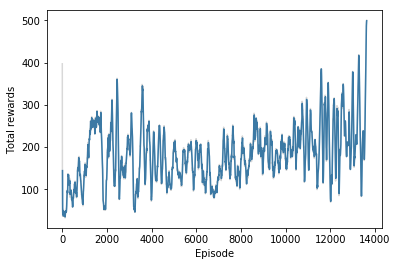

In [32]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

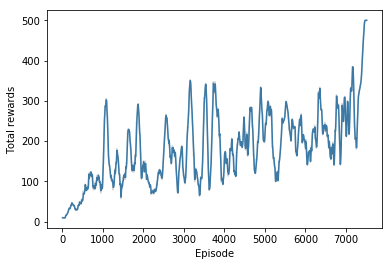

Text(0,0.5,'G losses')

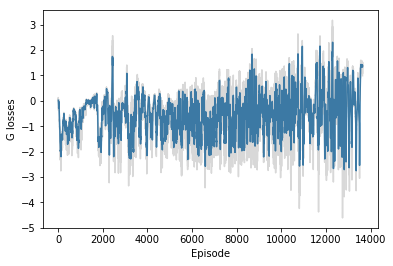

In [33]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

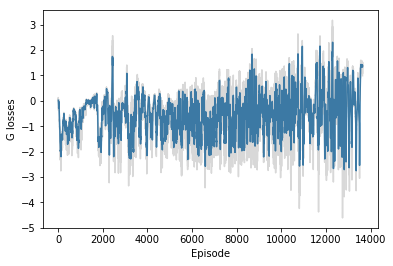

In [30]:
# eps, arr = np.array(g_loss_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('G losses')

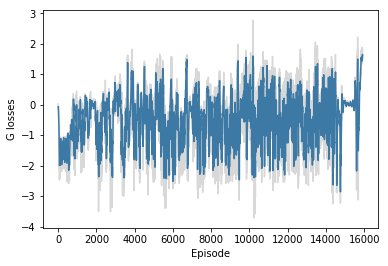
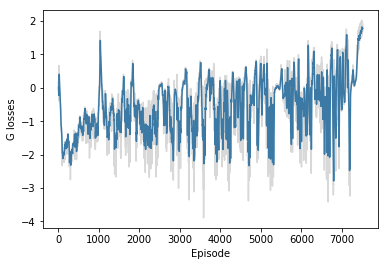

Text(0,0.5,'D losses')

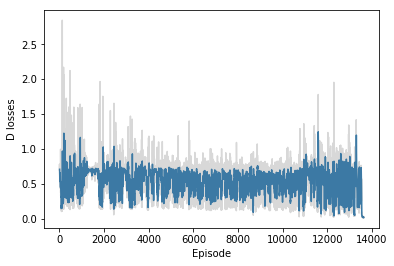

In [34]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

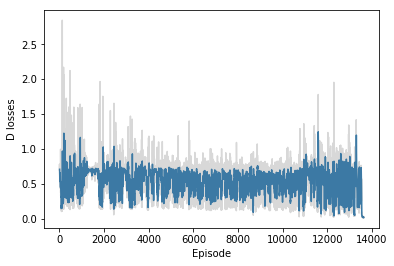

In [31]:
# eps, arr = np.array(d_loss_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('D losses')

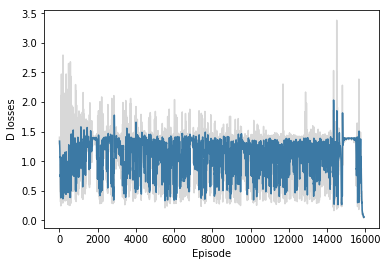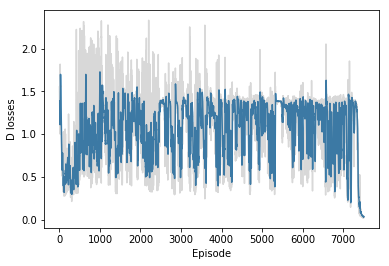

Text(0,0.5,'D losses R')

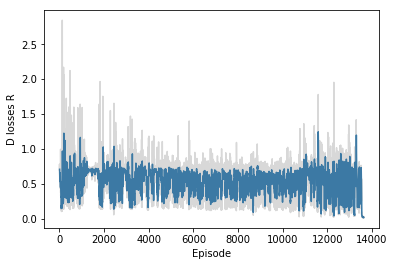

In [35]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

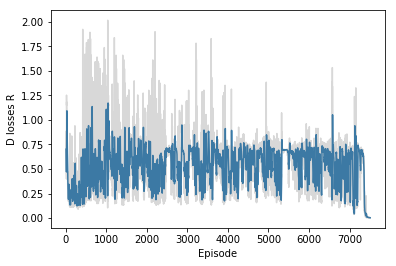

In [32]:
# eps, arr = np.array(d_lossR_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('D losses R')

Text(0,0.5,'D losses Q')

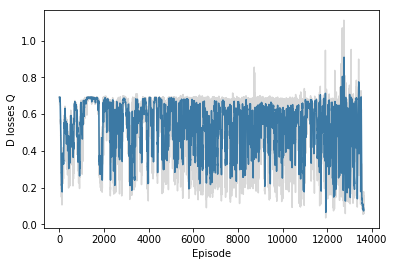

In [36]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

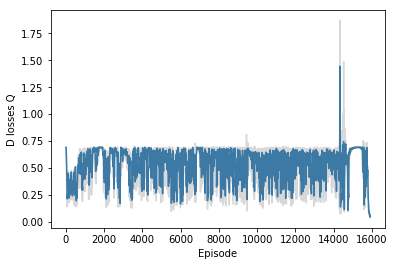

In [33]:
# eps, arr = np.array(d_lossQ_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

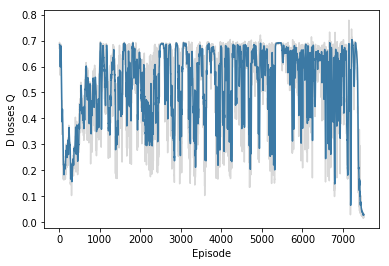

In [33]:
# eps, arr = np.array(d_lossQ_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('D losses Q')

## Testing

Let's checkout how our trained agent plays the game.

In [34]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(100):
    #while True:
        state = env.reset()
        total_reward = 0

        # Steps/batches
        #for _ in range(111111111111111111):
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
        # Print and break condition
        print('total_reward: {}'.format(total_reward))
        # if total_reward == 500:
        #     break
                
# Closing the env
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.